In [1]:
import math
import random
import logging
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold
from ray import tune
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable,Function
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import trange
from pycm import ConfusionMatrix
from secml.array.c_array import CArray

myfont = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,
         }

logger = logging.getLogger(__name__)

%matplotlib inline

/data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
def attack_keras_model(X, Y, S, nb_attack=25, dmax=0.1):
    """
    Generates an adversarial attack on a general model.
    :param X: Original inputs on which the model is trained
    :param Y: Original outputs on which the model is trained
    :param S: Original protected attributes on which the model is trained
    :return: Adversarial dataset (i.e. new data points + original input)
    """

    from secml.data import CDataset
    from secml.array import CArray

    # secML wants all dimensions to be homogeneous (we had previously float and int in X)
    data_set_encoded_secML = CArray(X, dtype=float, copy=True)
    data_set_encoded_secML = CDataset(data_set_encoded_secML, Y)

    n_tr = round(0.66 * X.shape[0])
    n_ts = X.shape[0] - n_tr

    logger.debug(X.shape)
    logger.debug(n_tr)
    logger.debug(n_ts)

    from secml.data.splitter import CTrainTestSplit
    splitter = CTrainTestSplit(train_size=n_tr, test_size=n_ts)

    # Use training set for the classifier and then pick points from an internal test set.
    tr_set_secML, ts_set_secML = splitter.split(data_set_encoded_secML)

    # tr_set_secML = CDataset(X_train,Y_train)
    # ts_set_secML = CDataset(X_test,Y_test)

    # Create a surrogate classifier

    # Creation of the multiclass classifier
    from secml.ml.classifiers import CClassifierSVM
    from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
    from secml.ml.kernel import CKernelRBF
    clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1e-4, 1e-3, 1e-2, 0.1, 1], 'kernel.gamma': [0.01, 0.1, 1, 10, 100, 1e3]}

    # Let's create a 3-Fold data splitter
    random_state = 999

    from secml.data.splitter import CDataSplitterKFold
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    logger.debug("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=tr_set_secML,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )
    logger.debug("The best training parameters are: ", best_params)

    logger.debug(clf.get_params())
    logger.debug(clf.num_classifiers)

    # Metric to use for training and performance evaluation
    from secml.ml.peval.metrics import CMetricAccuracy
    metric = CMetricAccuracy()

    # Train the classifier
    clf.fit(tr_set_secML)
    logger.debug(clf.num_classifiers)

    # Compute predictions on a test set
    y_pred = clf.predict(ts_set_secML.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=ts_set_secML.Y, y_pred=y_pred)

    logger.debug("Accuracy on test set: {:.2%}".format(acc))

    # Prepare attack configuration

    noise_type = 'l2'   # Type of perturbation 'l1' or 'l2'
    lb, ub = 0, 1       # Bounds of the attack space. Can be set to `None` for unbounded
    y_target = None     # None if `error-generic` or a class label for `error-specific`

    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.1,         # grid search resolution
        'eta_min': 0.1,
        'eta_max': None,    # None should be ok
        'max_iter': 1000,
        'eps': 1e-2         # Tolerance on the stopping crit.
    }

    # Run attack

    from secml.adv.attacks.evasion import CAttackEvasionPGDLS
    pgd_ls_attack = CAttackEvasionPGDLS(
        classifier=clf,
        surrogate_classifier=clf,
        surrogate_data=tr_set_secML,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target)

    nb_feat = X.shape[1]

    result_pts = np.empty([nb_attack, nb_feat])
    result_class = np.empty([nb_attack, 1])

    # take a point at random being the starting point of the attack and run the attack
    import random
    for nb_iter in range(0, nb_attack):
        rn = random.randint(0, ts_set_secML.num_samples - 1)
        x0, y0 = ts_set_secML[rn, :].X, ts_set_secML[rn, :].Y,

        try:
            y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)
            adv_pt = adv_ds_pgdls.X.get_data()
            # np.asarray([np.asarray(row, dtype=float) for row in y_tr], dtype=float)
            result_pts[nb_iter] = adv_pt
            result_class[nb_iter] = y_pred_pgdls.get_data()[0]
        except ValueError:
            logger.warning("value error on {}".format(nb_iter))

    return result_pts, result_class, ts_set_secML[:nb_attack, :].Y

In [3]:
class bm:
    """
    Utility class that calculates the probability $$P(X | Y)$$ of
    (sets of) the random variables $X,Y$ with the (set of) random
    variables $Y$ in the conditioning set.
    
    This class should be first initialized with a pandas dataframe,
    afterwards the conditional probability can be calculated as follows:
    
    ```python
    Model(df).P(x = 1).given(y=1)
    ```
    
    Lambdas can also be used, for other options than equalities:
    
    ```python
    Model(df).P(x = lambda x: x>5).given(y=1)
    ```
    """
    def __init__(self, df):
        self._df = df

    def P(self, **kwargs):
        """
        Declares the random variables from the set `kwargs`.
        """
        self._variables = kwargs
        return self

    def given(self, **kwargs):
        """
        Calculates the probability on a finite set of samples with `kwargs` in the
        conditioning set. 
        """
        self._given = kwargs
        
        # Here's where the magic happens
        prior = True
        posterior = True
        
        for k in self._variables:
            if type(self._variables[k]) == type(lambda x:x):
                posterior = posterior & (self._df[k].apply(self._variables[k]))
            else:
                posterior = posterior & (self._df[k] == self._variables[k])

        
        for k in self._given:
            if type(self._given[k]) == type(lambda x:x):
                prior = prior & (self._df[k].apply(self._given[k]))
                posterior = posterior & (self._df[k].apply(self._given[k]))
            else:
                prior = prior & (self._df[k] == self._given[k])
                posterior = posterior & (self._df[k] == self._given[k])
        return posterior.sum()/prior.sum()

In [4]:
def transform_dataset(df):
    """

    :param df:
    :return: Tuple of the transformed dataset and the labels Y and S
    """

    df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]

    del df_binary['c_jail_in']
    del df_binary['c_jail_out']

    ##separated class from the rests of the features
    # remove unnecessary dimensions from Y -> only the decile_score remains
    Y = df_binary['decile_score']
    del df_binary['decile_score']
    Y_true = df_binary['two_year_recid']
    del df_binary['two_year_recid']
    del df_binary['score_text']

    S = df_binary['race']
    #del df_binary['race']
    #del df_binary['is_recid']

    print(df_binary.shape)

    # set sparse to False to return dense matrix after transformation and keep all dimensions homogeneous
    encod = preprocessing.OneHotEncoder(sparse=False)

    data_to_encode = df_binary.to_numpy()
    feat_to_encode = data_to_encode[:, 0]
    # print(feat_to_encode)
    # transposition
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    # print(feat_to_encode)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.DataFrame(encoded_feature)

    feat_to_encode = data_to_encode[:, 1]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)


    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 2] == "Caucasian"
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    # feature [2] [3] [4] [5] [6] [7] [8] has to be put between 0 and 1

    for i in range(3, 10):
        encoded_feature = data_to_encode[:, i]
        ma = np.amax(encoded_feature)
        mi = np.amin(encoded_feature)
        encoded_feature = (encoded_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 10]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 11]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    return df_binary_encoded, Y, S, Y_true

In [5]:
def transform_dataset_census(df):
    """
    :param df: the dataset "census income" from a csv file with reduced features, heterogeneous types and missing values, no header
    :return: Tuple of the transformed dataset and the labels Y and S
    """
    df_replace = df.replace(to_replace="?",value=np.nan)
    df_replace.dropna(inplace=True, axis=0)

    label_encoder = preprocessing.LabelEncoder()
    oh_encoder = preprocessing.OneHotEncoder(sparse=False)

    df_label = df_replace.iloc[:,-1]

    ##Y_true is the vector containing labels, at this point, labels (initially strings) have been transformed into integer (0 and 1) -> -5000 is now '0' and 5000+ is now '+1'
    Y = label_encoder.fit_transform(df_label)
    #remove last column from df
    del df_replace[df_replace.columns[-1]]

    # Y_true is the true outcome, in this case we're not using a future predictor (vs. compas)
    Y_true=[]

    #S is the protected attribute
    # could also be feature 7 (sex) or feature 13 (citizenship)
    S=df_replace["sex"]
    del df_replace["sex"]

    #remove feature fnlwgt
    del df_replace["fnlwgt"]

    #remove examples with missing values
              ## change 1 to 0 

    #     if df_replace.shape == df.shape:
    #         raise AssertionError("The removal of na values failed")

    print(df_replace.shape)

    #transform other features
    #feature age to normalize
    encoded_feature = df_replace.to_numpy()[:, 0]
    mi = np.amin(encoded_feature)
    ma = np.amax(encoded_feature)
    encoded_feature = (encoded_feature - mi) / (ma - mi)

    #df_binary_encoded is the data frame containing encoded features
    df_binary_encoded = pd.DataFrame(encoded_feature)
    print(df_binary_encoded.shape)


    encod_feature = df_replace.iloc[:,1]
    encoded_feature = pd.get_dummies(encod_feature)
    # df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    #feature 1 to 7 (after removal) are categorical
    for i in range(1,8):
        encod_feature = df_replace.iloc[:,i]
    #     print(encod_feature.shape)
        encoded_feature = pd.get_dummies(encod_feature)
    #     print(encoded_feature)
    #     print(df_binary_encoded)
        df_binary_encoded = pd.concat([df_binary_encoded.reset_index(drop=True), pd.DataFrame(encoded_feature).reset_index(drop=True)], axis=1)
#         print(df_binary_encoded)
    #     print('')

    #feature 8 and 9 are numerical
    for i in range(8,10):
        encod_feature = df_replace.iloc[:,i]
        mi = np.amin(encod_feature)
        ma = np.amax(encod_feature)
        encoded_feature = (encod_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded.reset_index(drop=True), pd.DataFrame(encoded_feature).reset_index(drop=True)], axis=1)
    #     print(df_binary_encoded.shape)
    #feature 10 and 11 are categorical
    for i in range(10,12):
        encod_feature = df_replace.iloc[:,i]
        encoded_feature = pd.get_dummies(encod_feature)
        df_binary_encoded = pd.concat([df_binary_encoded.reset_index(drop=True), pd.DataFrame(encoded_feature).reset_index(drop=True)], axis=1)
    #     print(df_binary_encoded.shape)

    return df_binary_encoded, Y, S, Y_true

In [6]:
def transform_dataset_credit(df):
    """
    For more info on the features:
    https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
    :param df: the dataset "german credit" from a space separated file
    :return: Tuple of the transformed dataset and the labels Y and S
    """

    label_encoder = preprocessing.LabelEncoder()
    oh_encoder = preprocessing.OneHotEncoder(sparse=False)

    Y = np.array(df.iloc[:,-1] == 2)

    ##Y_true is the vector containing labels, at this point, labels (initially strings) have been transformed into integer (0 and 1) -> -5000 is now '0' and 5000+ is now '+1'
    #remove last column from df
    del df[df.columns[-1]]

    # Y_true is the true outcome, in this case we're not using a future predictor (vs. compas)
    Y_true=[]

    #S is the protected attribute
    S=df.iloc[:,12] > 25
    #del df["Age"]

    #remove examples with missing values
    df_replace = df.replace(to_replace="?",value=np.nan)
    df_replace.dropna(inplace=True, axis=1)

    print(df_replace.shape)

    #transform other features
    #feature age to normalize
    encoded_feature = df_replace.to_numpy()[:, 1]
    mi = np.amin(encoded_feature)
    ma = np.amax(encoded_feature)
    encoded_feature = (encoded_feature - mi) / (ma - mi)

    #df_binary_encoded is the data frame containing encoded features
    df_binary_encoded = pd.DataFrame(encoded_feature)

    # categorical attributes
    for i in [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18,19]:
        encod_feature = df_replace.iloc[:,i]
        encoded_feature = pd.get_dummies(encod_feature)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    # Numerical attributes
    for i in [1, 7, 10, 15, 17]:
        encod_feature = df_replace.iloc[:,i]
        mi = np.amin(encod_feature)
        ma = np.amax(encod_feature)
        encoded_feature = (encod_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    print(S)

    return df_binary_encoded, Y, S, Y_true


In [7]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)
    



In [8]:
class Net(nn.Module):

    def __init__(self, input_shape, grl_lambda=100):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self._grl_lambda = grl_lambda
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        if self._grl_lambda != 0:
            self.grl = GradientReversal(grl_lambda)
            self.fc5 = nn.Linear(32, 2)
        # self.grl = GradientReversal(100)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, 0.1)
        hidden = self.fc2(hidden)
        hidden = F.relu(hidden)
        hidden = self.fc3(hidden)
        hidden = F.relu(hidden)

        y = self.fc4(hidden)
        # y = F.dropout(y, 0.1)

        if self._grl_lambda != 0:
            s = self.grl(hidden)
            s = self.fc5(s)
            # s = F.sigmoid(s)
            # s = F.dropout(s, 0.1)
            return y, s
        else:
            return y

In [9]:
class Net_nodrop(nn.Module):

    def __init__(self, input_shape, grl_lambda=100):
        super(Net_nodrop, self).__init__()
        # an affine operation: y = Wx + b
        self._grl_lambda = grl_lambda
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        if self._grl_lambda != 0:
            self.grl = GradientReversal(grl_lambda)
            self.fc5 = nn.Linear(32, 2)
        # self.grl = GradientReversal(100)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = F.relu(hidden)
#         hidden = F.dropout(hidden, 0.1)
        hidden = self.fc2(hidden)
        hidden = F.relu(hidden)
        hidden = self.fc3(hidden)
        hidden = F.relu(hidden)

        y = self.fc4(hidden)
        # y = F.dropout(y, 0.1)

        if self._grl_lambda != 0:
            s = self.grl(hidden)
            s = self.fc5(s)
            # s = F.sigmoid(s)
            # s = F.dropout(s, 0.1)
            return y, s
        else:
            return y

In [10]:
class Net_CENSUS(nn.Module):

    def __init__(self, input_shape, grl_lambda=100):
        super(Net_CENSUS, self).__init__()
        # an affine operation: y = Wx + b
        self._grl_lambda = grl_lambda
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        if self._grl_lambda != 0:
            self.grl = GradientReversal(grl_lambda)
            self.fc5 = nn.Linear(128, 2)
        # self.grl = GradientReversal(100)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, 0.1)
        hidden = self.fc2(hidden)
        hidden = F.relu(hidden)
        hidden = self.fc3(hidden)
        hidden = F.relu(hidden)

        y = self.fc4(hidden)
        # y = F.dropout(y, 0.1)

        if self._grl_lambda != 0:
            s = self.grl(hidden)
            s = self.fc5(s)
            # s = F.sigmoid(s)
            # s = F.dropout(s, 0.1)
            return y, s
        else:
            return y

In [11]:
# 路径分析相关函数

def get_paras(net):
    paras=[]
    for name,parameters in net.named_parameters():
        paras.append(parameters)
    return paras

def get_active_neurons4(net,sample):
    neurons=[]
    def hook(module,input,output):
        neurons.append(output.data)
    handle1=net.fc1.register_forward_hook(hook)
    handle2=net.fc2.register_forward_hook(hook)
    handle3=net.fc3.register_forward_hook(hook)
    handle4=net.fc4.register_forward_hook(hook)
    net(x=torch.tensor(sample,dtype=torch.float32))
    handle1.remove()
    handle2.remove()
    handle3.remove()
    handle4.remove()
    return neurons

def get_contrib4(paras,neurons):
    contrib_list=[]
    for i in range(3):
        i=i
        contrib=neurons[i]*paras[2*i+2]
        contrib_list.append(contrib)
    return contrib_list

def get_path_set4(net,sample,GAMMA=0.9):
    active_neuron_indice=[[],[],[],[]]
    path_set=set()
    neurons=get_active_neurons4(net,sample)
    paras=get_paras(net)
    contrib_list=get_contrib4(paras,neurons)
    active_neuron_indice[3].append(torch.argmax(neurons[3]).item())
    for i in range(3):
        L=3-i
        for j in active_neuron_indice[L]:
            s=torch.sort(contrib_list[L-1][j],descending=True)
            sum=0
            for k in range(len(contrib_list[L-1][j])):
                sum+=s.values[k].item()
                active_neuron_indice[L-1].append(s.indices[k].item())
                path_set.add((L,s.indices[k].item(),j))
                if(sum>=GAMMA*neurons[L][j].item()):
                    break
    return path_set


In [12]:
def get_metrics(results, threshold, fraction,dataset='compas'):
    "Create the metrics from an output df."

    # Calculate biases after training
    dem_parity = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0)
        - bm(results).P(pred=lambda x: x > threshold).given(
            race=1))

    eq_op = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0, compas=True)
        - bm(results).P(pred=lambda x: x > threshold).given(race=1, compas=True))

    dem_parity_ratio = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0)
        / bm(results).P(pred=lambda x: x > threshold).given(
            race=1))

    cm = ConfusionMatrix(actual_vector=(results['true'] == True).values,
                         predict_vector=(results['pred'] > threshold).values)
    if dataset=='compas':
        cm_high_risk = ConfusionMatrix(actual_vector=(results['compas'] > 8).values,
                             predict_vector=(results['pred'] > 8).values)

        result = {"DP": dem_parity,
                  "EO": eq_op,
                  "DP ratio": dem_parity_ratio,
                  "acc": cm.Overall_ACC,
                  "acc_ci_min": cm.CI95[0],
                  "acc_ci_max": cm.CI95[1],
                  "f1": cm.F1_Macro,
                  "acc_high_risk": cm_high_risk.Overall_ACC,
                  "acc_ci_min_high_risk": cm_high_risk.CI95[0],
                  "acc_ci_max_high_risk": cm_high_risk.CI95[1],
                  "f1_high_risk": cm_high_risk.F1_Macro,
                  "adversarial_fraction": fraction
                  }
    else:
        result = {"DP": dem_parity,
                  "EO": eq_op,
                  "DP ratio": dem_parity_ratio,
                  "acc": cm.Overall_ACC,
                  "acc_ci_min": cm.CI95[0],
                  "acc_ci_max": cm.CI95[1],
                  "f1": cm.F1_Macro,
                  "adversarial_fraction": fraction
                  }

    return result

In [13]:
def train_and_evaluate(train_loader: DataLoader,
                       val_loader: DataLoader,
                       test_loader: DataLoader,
                       device,
                       input_shape,
                       grl_lambda=None,
                       model=None,
                       dataset='compas'):
    """

    :param train_loader: Pytorch-like DataLoader with training data.
    :param val_loader: Pytorch-like DataLoader with validation data.
    :param test_loader: Pytorch-like DataLoader with testing data.
    :param device: The target device for the training.
    :return: A tuple: (trained Pytorch-like model, dataframe with results on test set)
    """

    torch.manual_seed(0)

    grl_lambda = 50
    epochs = 50

    if model is None:
        # Redefine the model
        if dataset=='census':
            model = Net_CENSUS(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
        elif dataset=='compas_nodrop':
            model = Net_nodrop(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
        else:
            model = Net(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
        
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    criterion_bias = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.3, cooldown=5)

    training_losses = []
    validation_losses = []

    t_prog = trange(epochs, desc='Training neural network', leave=False, position=1, mininterval=5)
    # t_prog = trange(50)

    for epoch in t_prog:
        model.train()

        batch_losses = []
        for x_batch, y_batch, _, s_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if grl_lambda is not None and grl_lambda != 0:
                outputs, outputs_protected = model(x_batch)
                loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
            else:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val, y_val, _, s_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                s_val = s_val.to(device)
                model.eval()
                if grl_lambda is not None and grl_lambda != 0:
                    yhat, s_hat = model(x_val)
                    val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
                else:
                    yhat = model(x_val)
                    val_loss = criterion(y_val, yhat).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

            scheduler.step(val_loss)

        t_prog.set_postfix({"epoch": epoch, "training_loss": training_loss,
                            "validation_loss": validation_loss}, refresh=False)  # print last metrics

#     if args.show_graphs:
#         plt.plot(range(len(training_losses)), training_losses)
#         plt.plot(range(len(validation_losses)), validation_losses)
#         # plt.scatter(x_tensor, y_out.detach().numpy())
#         plt.ylabel('some numbers')
#         plt.show()

    with torch.no_grad():
        test_losses = []
        test_results = []
        for x_test, y_test, ytrue, s_true in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            s_true = s_true.to(device)
            model.eval()
            if grl_lambda is not None and grl_lambda != 0:
                yhat, s_hat = model(x_test)
                test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
            else:
                yhat = model(x_test)
                test_loss = (criterion(y_test, yhat)).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true})

        # print({"Test loss": np.mean(test_losses)})

    results = test_results[0]['y_hat']
    outcome = test_results[0]['y_true']
    compas = test_results[0]['y_compas']
    protected_results = test_results[0]['s']
    if grl_lambda is not None and grl_lambda != 0:
        protected = test_results[0]['s_hat']
    for r in test_results[1:]:
        results = torch.cat((results, r['y_hat']))
        outcome = torch.cat((outcome, r['y_true']))
        compas = torch.cat((compas, r['y_compas']))
        protected_results = torch.cat((protected_results, r['s']))
        if grl_lambda is not None and grl_lambda != 0:
            protected = torch.cat((protected, r['s_hat']))

    df = pd.DataFrame(data=results.cpu().numpy(), columns=['pred'])

    df['true'] = outcome.cpu().numpy()
    df['compas'] = compas.cpu().numpy()
    df['race'] = protected_results.cpu().numpy()[:, 0]
    if grl_lambda is not None and grl_lambda != 0:
        df['race_hat'] = protected.cpu().numpy()[:, 0]

    return model, df

In [14]:
def train_and_evaluate_drop(adv_loader: DataLoader,
                            benign_loader: DataLoader,
                            val_loader: DataLoader,
                            test_loader: DataLoader,
                            device,
                            input_shape,
                            grl_lambda=None,
                            model=None,
                            dataset='compas'):
    """

    :param train_loader: Pytorch-like DataLoader with training data.
    :param val_loader: Pytorch-like DataLoader with validation data.
    :param test_loader: Pytorch-like DataLoader with testing data.
    :param device: The target device for the training.
    :return: A tuple: (trained Pytorch-like model, dataframe with results on test set)
    """

#     torch.manual_seed(0)

#     grl_lambda = 50
    epochs = 50

    if model is None:
        if dataset=='CENSUS':
            model = Net_CENSUS(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
        else:
            model = Net(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    criterion_bias = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.3, cooldown=5)

    training_losses = []
    validation_losses = []

    t_prog = trange(epochs, desc='Training neural network', leave=False, position=1, mininterval=5)
    # t_prog = trange(50)

    for epoch in t_prog:
        batch_losses = []
        
        model.train()
        for x_batch, y_batch, _, s_batch in adv_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if grl_lambda is not None and grl_lambda != 0:
                outputs, outputs_protected = model(x_batch)
                loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
            else:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        model.eval()
        for x_batch, y_batch, _, s_batch in benign_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if grl_lambda is not None and grl_lambda != 0:
                outputs, outputs_protected = model(x_batch)
                loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
            else:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val, y_val, _, s_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                s_val = s_val.to(device)
                model.eval()
                if grl_lambda is not None and grl_lambda != 0:
                    yhat, s_hat = model(x_val)
                    val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
                else:
                    yhat = model(x_val)
                    val_loss = criterion(y_val, yhat).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

            scheduler.step(val_loss)

        t_prog.set_postfix({"epoch": epoch, "training_loss": training_loss,
                            "validation_loss": validation_loss}, refresh=False)  # print last metrics

#     if args.show_graphs:
#         plt.plot(range(len(training_losses)), training_losses)
#         plt.plot(range(len(validation_losses)), validation_losses)
#         # plt.scatter(x_tensor, y_out.detach().numpy())
#         plt.ylabel('some numbers')
#         plt.show()

    with torch.no_grad():
        test_losses = []
        test_results = []
        for x_test, y_test, ytrue, s_true in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            s_true = s_true.to(device)
            model.eval()
            if grl_lambda is not None and grl_lambda != 0:
                yhat, s_hat = model(x_test)
                test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
            else:
                yhat = model(x_test)
                test_loss = (criterion(y_test, yhat)).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true})

        # print({"Test loss": np.mean(test_losses)})

    results = test_results[0]['y_hat']
    outcome = test_results[0]['y_true']
    compas = test_results[0]['y_compas']
    protected_results = test_results[0]['s']
    if grl_lambda is not None and grl_lambda != 0:
        protected = test_results[0]['s_hat']
    for r in test_results[1:]:
        results = torch.cat((results, r['y_hat']))
        outcome = torch.cat((outcome, r['y_true']))
        compas = torch.cat((compas, r['y_compas']))
        protected_results = torch.cat((protected_results, r['s']))
        if grl_lambda is not None and grl_lambda != 0:
            protected = torch.cat((protected, r['s_hat']))

    df = pd.DataFrame(data=results.cpu().numpy(), columns=['pred'])

    df['true'] = outcome.cpu().numpy()
    df['compas'] = compas.cpu().numpy()
    df['race'] = protected_results.cpu().numpy()[:, 0]
    if grl_lambda is not None and grl_lambda != 0:
        df['race_hat'] = protected.cpu().numpy()[:, 0]

    return model, df

In [15]:
def sample_sort(net, train_dataset, THETA=1e-3, GAMMA=0.9):
    net=net.cpu()
    # THETA = 1e-3
    path_set_list=[]
    for i in (range(len(train_dataset))):
        path_set=get_path_set4(net,train_dataset[i][0],GAMMA=GAMMA)
        path_set_list.append(path_set)
    v=pd.value_counts(path_set_list).rename_axis('pathset').reset_index(name='counts')
#     v_list.append(v)
    t=tuple(v[v.counts<=max(v.counts[0]*THETA,1)].pathset)
    adv_data_idx=[]
    for i in range(len(path_set_list)):
        if path_set_list[i] in t:
            adv_data_idx.append(i)
    print("frac:{}".format(len(adv_data_idx)/len(train_dataset)))
    return adv_data_idx

v_list=[]
def sample_sort_test(net, train_dataset, THETA=1e-3, GAMMA=0.9):
    net=net.cpu()
    # THETA = 1e-3
    path_set_list=[]
    for i in (range(len(train_dataset))):
        path_set=get_path_set4(net,train_dataset[i][0],GAMMA=GAMMA)
        path_set_list.append(path_set)
    v=pd.value_counts(path_set_list).rename_axis('pathset').reset_index(name='counts')
    v_list.append(v)
    t=tuple(v[v.counts<=max(v.counts[0]*THETA,1)].pathset)
    adv_data_idx=[]
    for i in range(len(path_set_list)):
        if path_set_list[i] in t:
            adv_data_idx.append(i)
    print("frac:{}".format(len(adv_data_idx)/len(train_dataset)))
    return adv_data_idx

def get_adv(train_dataset,adv_data_idx):
    x_t_adv, y_t_adv, l_t_adv, s_t_adv = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_adv = a.unsqueeze(0) if x_t_adv is None else torch.cat((x_t_adv,a.unsqueeze(0)),0)
            y_t_adv = b.unsqueeze(0) if y_t_adv is None else torch.cat((y_t_adv,b.unsqueeze(0)),0)
            l_t_adv = c.unsqueeze(0) if l_t_adv is None else torch.cat((l_t_adv,c.unsqueeze(0)),0)
            s_t_adv = d.unsqueeze(0) if s_t_adv is None else torch.cat((s_t_adv,d.unsqueeze(0)),0)
    x_t_benign, y_t_benign, l_t_benign, s_t_benign = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i not in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_benign = a.unsqueeze(0) if x_t_benign is None else torch.cat((x_t_benign,a.unsqueeze(0)),0)
            y_t_benign = b.unsqueeze(0) if y_t_benign is None else torch.cat((y_t_benign,b.unsqueeze(0)),0)
            l_t_benign = c.unsqueeze(0) if l_t_benign is None else torch.cat((l_t_benign,c.unsqueeze(0)),0)
            s_t_benign = d.unsqueeze(0) if s_t_benign is None else torch.cat((s_t_benign,d.unsqueeze(0)),0)

    adv_dataset = TensorDataset(x_t_adv, y_t_adv, l_t_adv, s_t_adv)
    benign_dataset = TensorDataset(x_t_benign, y_t_benign, l_t_benign, s_t_benign)

    adv_loader = DataLoader(dataset=adv_dataset, batch_size=BATCH_SIZE, shuffle=True)
    benign_loader = DataLoader(dataset=benign_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return adv_loader,benign_loader

def get_adv_rand(train_dataset,adv_data_idx):
    adv_data_idx=random.choices(range(0,len(train_dataset)),k=len(adv_data_idx))
    x_t_adv, y_t_adv, l_t_adv, s_t_adv = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_adv = a.unsqueeze(0) if x_t_adv is None else torch.cat((x_t_adv,a.unsqueeze(0)),0)
            y_t_adv = b.unsqueeze(0) if y_t_adv is None else torch.cat((y_t_adv,b.unsqueeze(0)),0)
            l_t_adv = c.unsqueeze(0) if l_t_adv is None else torch.cat((l_t_adv,c.unsqueeze(0)),0)
            s_t_adv = d.unsqueeze(0) if s_t_adv is None else torch.cat((s_t_adv,d.unsqueeze(0)),0)
    x_t_benign, y_t_benign, l_t_benign, s_t_benign = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i not in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_benign = a.unsqueeze(0) if x_t_benign is None else torch.cat((x_t_benign,a.unsqueeze(0)),0)
            y_t_benign = b.unsqueeze(0) if y_t_benign is None else torch.cat((y_t_benign,b.unsqueeze(0)),0)
            l_t_benign = c.unsqueeze(0) if l_t_benign is None else torch.cat((l_t_benign,c.unsqueeze(0)),0)
            s_t_benign = d.unsqueeze(0) if s_t_benign is None else torch.cat((s_t_benign,d.unsqueeze(0)),0)

    adv_dataset = TensorDataset(x_t_adv, y_t_adv, l_t_adv, s_t_adv)
    benign_dataset = TensorDataset(x_t_benign, y_t_benign, l_t_benign, s_t_benign)

    adv_loader = DataLoader(dataset=adv_dataset, batch_size=BATCH_SIZE, shuffle=True)
    benign_loader = DataLoader(dataset=benign_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return adv_loader,benign_loader

In [16]:
def EA(net, attack_size, iter_num, dataset='compas'):
    model=net
    EA_start=time.time()
    t_main=trange(10,desc="Attack", leave=False, position=0)
    global train_loader, x_train_tensor, y_train_tensor, l_train_tensor, s_train_tensor
    for i in range(iter_num):

        model, results = train_and_evaluate(train_loader, val_loader, test_loader, device,
                                            input_shape=x_tensor.shape[1], model=model)
        print(i)
        result = get_metrics(results, threshold, fraction=(attack_size)/(base_size * 7), dataset=dataset)
        t_main.set_postfix(result)
        global_results.append(result)    
        result_pts, result_class, labels = attack_keras_model(
                CArray(x_train_tensor),
                Y=CArray((y_train_tensor[:, 0] > threshold).int()),
                S=s_train_tensor,
                nb_attack=10)
        print('attack_done!')
        result_pts = torch.tensor(np.around(result_pts.astype(np.float32), decimals=3)).clamp(0.0, 1.0)
        result_pts[result_pts != result_pts] = 0.0
        result_class[result_class != result_class] = 0.0

        x_train_tensor = torch.cat((x_train_tensor, result_pts))
        y_train_tensor = torch.cat(
            (y_train_tensor, torch.tensor(result_class.reshape(-1, 1).astype(np.float32)).clamp(0, 10)))
        l_train_tensor = torch.cat((l_train_tensor, torch.tensor(labels.tondarray().reshape(-1, 1).astype(np.float32))))
        s = np.random.randint(2, size=len(result_class))
        s_train_tensor = torch.cat((s_train_tensor, torch.tensor(np.array([s, 1 - s]).T.astype(np.float64))))

        train_dataset = TensorDataset(x_train_tensor, y_train_tensor, l_train_tensor, s_train_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        logging.debug("New training dataset has size {} (original {}).".format(len(train_loader), base_size * 7))
        EA_mid=time.time()
        cost_time=EA_mid-EA_start
        print('time costs:{} s'.format(cost_time))

    EA_end=time.time()
    cost_time=EA_end-EA_start
    print('time costs:{} s'.format(cost_time))


In [17]:
def Fixate(THETA=1e-3,GAMMA=0.9,epoch=10,dataset='compas'):
    our_start=time.time()
    for i in range(epoch):
        adv_data_idx = sample_sort(net,train_dataset,THETA,GAMMA)
        adv_loader, benign_loader = get_adv(train_dataset,adv_data_idx)
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                                grl_lambda=0)

        result = get_metrics(results, threshold, 0, dataset=dataset)
        global_results.append(result)

    our_end=time.time()
    cost_time=our_end-our_start
    print('time costs:{} s'.format(cost_time))

In [18]:
def training_function(config):
    
    THETA, GAMMA = config['THETA'], config['GAMMA']
    train_dataset_s=config['train_dataset_s']
    val_loader_s=config['val']
    test_loader_s=config['test']
    x_train_tensor_s=config['x_tensor']

    adv_data_idx = sample_sort(net,train_dataset_s,THETA,GAMMA)
    adv_loader, benign_loader = get_adv(train_dataset_s,adv_data_idx)
    net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader_s, test_loader_s, device, input_shape=x_train_tensor_s.shape[1],
                                            grl_lambda=0,dataset=config['dataset'])
    result = get_metrics(results, threshold, 0,dataset=config['dataset'])
    complex_score = result['DP']+result['EO']+(1-result['DP ratio'])-0.01*result['acc']
    tune.report(mean_loss=complex_score)
    
    global_results.append(result)

In [19]:
def training_function_rand(config):
    
    THETA, GAMMA = config['THETA'], config['GAMMA']
    train_dataset_s=config['train_dataset_s']
    val_loader_s=config['val']
    test_loader_s=config['test']
    x_train_tensor_s=config['x_tensor']

    adv_data_idx = sample_sort(net,train_dataset_s,THETA,GAMMA)
    adv_loader, benign_loader = get_adv_rand(train_dataset_s,adv_data_idx)
    net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader_s, test_loader_s, device, input_shape=x_train_tensor_s.shape[1],
                                            grl_lambda=0,dataset=config['dataset'])
    result = get_metrics(results, threshold, 0,dataset=config['dataset'])
    complex_score = result['DP']+result['EO']+(1-result['DP ratio'])-0.01*result['acc']
    tune.report(mean_loss=complex_score)
    
    global_results.append(result)

In [20]:
def Fixate_with_val(epoch=10,dataset='compas'):
    our_start=time.time()
    base_size = len(val_dataset) // 10
    split = [8 * base_size, 1 * base_size, len(val_dataset) - 9 * base_size]  # Train, validation, test
    train_dataset_s, val_dataset_s, test_dataset_s = random_split(val_dataset, split)
#     print(train_dataset_s)
    
#     train_loader_s = DataLoader(dataset=train_dataset_s, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_s = DataLoader(dataset=val_dataset_s, batch_size=BATCH_SIZE)
    test_loader_s = DataLoader(dataset=test_dataset_s, batch_size=BATCH_SIZE)

    x_train_tensor_s = val_dataset[:][0]


    analysis = tune.run(
        training_function,
        config={
            'THETA': tune.grid_search([0.1, 0.01, 3e-3, 1e-3, 3e-4, 1e-4]),
            'GAMMA': tune.grid_search([0.95, 0.9, 0.85, 0.8, 0.7, 0.6]),
            'dataset':dataset,
            'train_dataset_s':train_dataset_s,
            'val':val_loader_s,
            'test':test_loader_s,
            'x_tensor':x_train_tensor_s
        },
        resources_per_trial={
            "cpu": 16,
            "gpu": 2,
        }
    )
    best_config=analysis.get_best_config(metric="mean_loss", mode="min")
    print("Best config: ",best_config)
    THETA = best_config['THETA']
    GAMMA = best_config['GAMMA']
    val_end=time.time()
    for i in range(epoch):
        adv_data_idx = sample_sort(net,train_dataset,THETA,GAMMA)
        PA_end=time.time()
        adv_loader, benign_loader = get_adv(train_dataset,adv_data_idx)
        SS_end=time.time()
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                                grl_lambda=0,dataset=dataset)
        Dropout_end=time.time()
        result = get_metrics(results, threshold, 0, dataset=dataset)
        global_results.append(result)

    our_end=time.time()
    cost_time=our_end-our_start
    val_time=val_end-our_start
    PA_time=PA_end-val_end
    SS_time=SS_end-PA_end
    Dropout_time=Dropout_end-SS_end
    print('param selection costs:{} s'.format(val_time))
    print('path analysis costs:{} s'.format(PA_time))
    print('sample separation costs:{} s'.format(SS_time))
    print('partial dropout training costs:{} s'.format(Dropout_time))
    print('total time costs:{} s'.format(cost_time))

In [21]:
def Fixate_with_val_rand(epoch=10,dataset='compas'):
    our_start=time.time()
    base_size = len(val_dataset) // 10
    split = [8 * base_size, 1 * base_size, len(val_dataset) - 9 * base_size]  # Train, validation, test
    train_dataset_s, val_dataset_s, test_dataset_s = random_split(val_dataset, split)
#     print(train_dataset_s)
    
#     train_loader_s = DataLoader(dataset=train_dataset_s, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_s = DataLoader(dataset=val_dataset_s, batch_size=BATCH_SIZE)
    test_loader_s = DataLoader(dataset=test_dataset_s, batch_size=BATCH_SIZE)

    x_train_tensor_s = val_dataset[:][0]


    analysis = tune.run(
        training_function_rand,
        config={
            'THETA': tune.grid_search([0.1, 0.01, 3e-3, 1e-3, 3e-4, 1e-4]),
            'GAMMA': tune.grid_search([0.95, 0.9, 0.85, 0.8, 0.7, 0.6]),
            'dataset':dataset,
            'train_dataset_s':train_dataset_s,
            'val':val_loader_s,
            'test':test_loader_s,
            'x_tensor':x_train_tensor_s
        },
        resources_per_trial={
            "cpu": 8,
            "gpu": 2,
        }
    )

    best_config=analysis.get_best_config(metric="mean_loss", mode="min")
    print("Best config: ",best_config)
    THETA = best_config['THETA']
    GAMMA = best_config['GAMMA']
    for i in range(epoch):
        adv_data_idx = sample_sort(net,train_dataset,THETA,GAMMA)
        adv_loader, benign_loader = get_adv_rand(train_dataset,adv_data_idx)
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                                grl_lambda=0,dataset=dataset)

        result = get_metrics(results, threshold, 0, dataset=dataset)
        global_results.append(result)

    our_end=time.time()
    cost_time=our_end-our_start
    print('time costs:{} s'.format(cost_time))

In [465]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/COMPAS/compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv')
# df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]     提取两种种族
# Y = df_binary['decile_score']    评分，range:[0,10]
# S = df_binary['race']
# Y_true = df_binary['two_year_recid']    是否入狱
df_binary, Y, S, Y_true = transform_dataset(df)
Y = Y.to_numpy()
print(np.mean(Y))

l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 4

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0)
ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)

# EA
# EA(net,attack_size=10, iter_num=50)

for THETA in list(np.logspace(-0.01,-5,50)):
    Fixate(THETA=THETA,GAMMA=0.95,epoch=3)


Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]

(5278, 12)
4.6227737779461915



Training neural network:  70%|███████   | 35/50 [00:10<00:04,  3.37it/s, epoch=34, training_loss=8.54, validation_loss=9.23]
                                                                                                                            

time costs:14.907471895217896 s
2021-08-13 13:49:43,923 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3578205475738683



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.94it/s, epoch=39, training_loss=4.48, validation_loss=4.13]
                                                                                                                            

2021-08-13 13:50:13,729 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.37083220384928167



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.01it/s, epoch=43, training_loss=4.33, validation_loss=4.09]
                                                                                                                            

2021-08-13 13:50:42,668 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3730008132285172



Training neural network:  86%|████████▌ | 43/50 [00:10<00:01,  4.18it/s, epoch=42, training_loss=4.48, validation_loss=4.11]
                                                                                                                            

time costs:86.96166348457336 s
2021-08-13 13:51:10,885 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.34995933857413936



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.91it/s, epoch=38, training_loss=4.5, validation_loss=4.24] 
                                                                                                                           

2021-08-13 13:51:39,600 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3534833288153971



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.86it/s, epoch=38, training_loss=4.51, validation_loss=4.16]
                                                                                                                            

2021-08-13 13:52:09,083 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.35294117647058826



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.93it/s, epoch=41, training_loss=4.43, validation_loss=4.03]
                                                                                                                            

time costs:87.33259391784668 s
2021-08-13 13:52:38,218 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3526701002981838



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.88it/s, epoch=39, training_loss=4.51, validation_loss=4.33]
                                                                                                                            

2021-08-13 13:53:06,995 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.34128490105719705



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.93it/s, epoch=41, training_loss=4.44, validation_loss=4]   
                                                                                                                         

2021-08-13 13:53:35,521 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.36541068040119273



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.03it/s, epoch=40, training_loss=4.23, validation_loss=4.05]
                                                                                                                            

time costs:85.30315613746643 s
2021-08-13 13:54:03,522 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.34833288153971265



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.11it/s, epoch=41, training_loss=4.38, validation_loss=4.21]
                                                                                                                            

2021-08-13 13:54:30,324 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3396584440227704



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.01it/s, epoch=40, training_loss=4.49, validation_loss=4.15]
                                                                                                                            

2021-08-13 13:54:58,982 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.37083220384928167



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.25it/s, epoch=43, training_loss=4.36, validation_loss=4.02]
                                                                                                                            

time costs:83.28795456886292 s
2021-08-13 13:55:26,810 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.36215776633233937



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.98it/s, epoch=41, training_loss=4.52, validation_loss=4.11]
                                                                                                                            

2021-08-13 13:55:53,660 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.35619409053944157



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.42, validation_loss=4.19]
                                                                                                                            

2021-08-13 13:56:20,883 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.34643534833288153



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.11it/s, epoch=43, training_loss=4.49, validation_loss=4.25]
                                                                                                                            

time costs:81.65716552734375 s
2021-08-13 13:56:48,469 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.34236920574681484



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.05it/s, epoch=40, training_loss=4.26, validation_loss=3.82]
                                                                                                                            

2021-08-13 13:57:15,526 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3326104635402548



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.42, validation_loss=4.25]
                                                                                                                            

2021-08-13 13:57:42,449 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.35131471943616155



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.96it/s, epoch=41, training_loss=4.5, validation_loss=4.29] 
                                                                                                                           

time costs:80.84013056755066 s
2021-08-13 13:58:09,308 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.33505014909189484



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.02it/s, epoch=40, training_loss=4.43, validation_loss=4.02]
                                                                                                                            

2021-08-13 13:58:35,909 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.331526158850637



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.11it/s, epoch=40, training_loss=4.48, validation_loss=4.16]
                                                                                                                            

2021-08-13 13:59:02,201 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.3345079967470859



Training neural network:  88%|████████▊ | 44/50 [00:11<00:01,  3.94it/s, epoch=43, training_loss=4.52, validation_loss=4.12]
                                                                                                                            

time costs:79.65466141700745 s
2021-08-13 13:59:28,964 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.306587150989428



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.06it/s, epoch=41, training_loss=4.46, validation_loss=4.1] 
                                                                                                                           

2021-08-13 13:59:54,054 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.32447817836812143



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.89it/s, epoch=41, training_loss=4.42, validation_loss=4.05]
                                                                                                                            

2021-08-13 14:00:19,937 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.32339387367850364



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.06it/s, epoch=40, training_loss=4.35, validation_loss=3.89]
                                                                                                                            

time costs:76.05116510391235 s
2021-08-13 14:00:45,016 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2965573326104635



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.93it/s, epoch=40, training_loss=4.35, validation_loss=4.03]
                                                                                                                            

2021-08-13 14:01:10,785 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.29411764705882354



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.09it/s, epoch=41, training_loss=4.31, validation_loss=4.15]
                                                                                                                            

2021-08-13 14:01:35,215 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.28706966657630795



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.34, validation_loss=4.12]
                                                                                                                            

time costs:74.90740489959717 s
2021-08-13 14:01:59,923 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2764976958525346



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.03it/s, epoch=41, training_loss=4.45, validation_loss=4.12]
                                                                                                                            

2021-08-13 14:02:24,501 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2762266196801301



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.05it/s, epoch=40, training_loss=4.42, validation_loss=4.08]
                                                                                                                            

2021-08-13 14:02:48,570 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2716183247492545



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.99it/s, epoch=40, training_loss=4.45, validation_loss=4.04]
                                                                                                                            

time costs:72.52334380149841 s
2021-08-13 14:03:12,447 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.24017348875033884



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.97it/s, epoch=39, training_loss=4.32, validation_loss=4.12]
                                                                                                                            

2021-08-13 14:03:36,069 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.23312550826782324



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.84it/s, epoch=38, training_loss=4.4, validation_loss=4.17] 
                                                                                                                           

2021-08-13 14:03:59,707 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2423420981295744



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.01it/s, epoch=43, training_loss=4.37, validation_loss=3.91]
                                                                                                                            

time costs:69.71608185768127 s
2021-08-13 14:04:22,163 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.204391433992952



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.99it/s, epoch=41, training_loss=4.49, validation_loss=4.14]
                                                                                                                            

2021-08-13 14:04:44,678 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.21171049064787206



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.73it/s, epoch=39, training_loss=4.36, validation_loss=4.04]
                                                                                                                            

2021-08-13 14:05:08,266 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2024939007861209



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.15it/s, epoch=41, training_loss=4.48, validation_loss=4.12]
                                                                                                                            

time costs:68.4055745601654 s
2021-08-13 14:05:30,569 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.18812686364868528



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.93it/s, epoch=39, training_loss=4.49, validation_loss=4.1]
                                                                                                                           

2021-08-13 14:05:53,227 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.18134995933857415



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.00it/s, epoch=41, training_loss=4.56, validation_loss=4.04]
                                                                                                                            

2021-08-13 14:06:15,693 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.18866901599349417



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.97it/s, epoch=40, training_loss=4.56, validation_loss=4.16]
                                                                                                                            

time costs:67.95657134056091 s
2021-08-13 14:06:38,526 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.17159121713201408



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.06it/s, epoch=41, training_loss=4.3, validation_loss=4]    
                                                                                                                        

2021-08-13 14:07:00,602 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16806722689075632



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.29it/s, epoch=43, training_loss=4.33, validation_loss=3.94]
                                                                                                                            

2021-08-13 14:07:21,999 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16969368392518297



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.03it/s, epoch=40, training_loss=4.41, validation_loss=4.19]
                                                                                                                            

time costs:65.53202176094055 s
2021-08-13 14:07:44,058 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16101924640824072



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.93it/s, epoch=39, training_loss=4.46, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:08:07,264 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16535646516671185



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.90it/s, epoch=39, training_loss=4.4, validation_loss=4.02] 
                                                                                                                           

2021-08-13 14:08:29,715 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.17918134995933857



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.95it/s, epoch=39, training_loss=4.41, validation_loss=4.07]
                                                                                                                            

time costs:67.36291456222534 s
2021-08-13 14:08:51,421 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16183247492545405



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.95it/s, epoch=41, training_loss=4.31, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:09:13,530 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16345893195988073



Training neural network:  86%|████████▌ | 43/50 [00:10<00:01,  4.16it/s, epoch=42, training_loss=4.46, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:09:34,554 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.16129032258064516



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.94it/s, epoch=40, training_loss=4.37, validation_loss=3.76]
                                                                                                                            

time costs:65.65075135231018 s
2021-08-13 14:09:57,073 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.14800759013282733



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.04it/s, epoch=40, training_loss=4.49, validation_loss=4.17]
                                                                                                                            

2021-08-13 14:10:19,161 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.1461100569259962



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.02it/s, epoch=40, training_loss=4.31, validation_loss=3.93]
                                                                                                                            

2021-08-13 14:10:41,583 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.15397126592572513



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.89it/s, epoch=39, training_loss=4.18, validation_loss=3.94]
                                                                                                                            

time costs:66.2458484172821 s
2021-08-13 14:11:03,319 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.14394144754676064



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.88it/s, epoch=39, training_loss=4.33, validation_loss=3.99]
                                                                                                                            

2021-08-13 14:11:24,721 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.13797777175386283



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.97it/s, epoch=40, training_loss=4.48, validation_loss=4.3] 
                                                                                                                           

2021-08-13 14:11:46,434 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.13255624830577392



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.01it/s, epoch=40, training_loss=4.39, validation_loss=4.19]
                                                                                                                            

time costs:64.44424200057983 s
2021-08-13 14:12:07,764 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.12686364868528055



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  4.01it/s, epoch=39, training_loss=4.29, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:12:29,351 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.127134724857685



Training neural network:  92%|█████████▏| 46/50 [00:10<00:00,  4.28it/s, epoch=45, training_loss=4.55, validation_loss=4.11]
                                                                                                                            

2021-08-13 14:12:49,469 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.12279750609921387



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.97it/s, epoch=41, training_loss=4.45, validation_loss=4.04]
                                                                                                                            

time costs:63.61458158493042 s
2021-08-13 14:13:11,379 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.11466522092708051



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.78it/s, epoch=39, training_loss=4.4, validation_loss=4.18] 
                                                                                                                           

2021-08-13 14:13:33,085 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10843046896177826



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.91it/s, epoch=39, training_loss=4.32, validation_loss=4.06]
                                                                                                                            

2021-08-13 14:13:54,803 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.11466522092708051



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.87it/s, epoch=39, training_loss=4.41, validation_loss=4.18]
                                                                                                                            

time costs:64.6123902797699 s
2021-08-13 14:14:15,992 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09758742206560043



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.97it/s, epoch=39, training_loss=4.68, validation_loss=4.2] 
                                                                                                                           

2021-08-13 14:14:37,137 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10246679316888045



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.06it/s, epoch=41, training_loss=4.37, validation_loss=3.99]
                                                                                                                            

2021-08-13 14:14:58,549 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10138248847926268



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.03it/s, epoch=41, training_loss=4.43, validation_loss=4.06]
                                                                                                                            

time costs:63.36790728569031 s
2021-08-13 14:15:19,361 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10029818378964489



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.20it/s, epoch=43, training_loss=4.47, validation_loss=4.18]
                                                                                                                            

2021-08-13 14:15:39,548 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09650311737598265



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.13it/s, epoch=41, training_loss=4.28, validation_loss=4.06]
                                                                                                                            

2021-08-13 14:15:59,585 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10761724044456493



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.98it/s, epoch=40, training_loss=4.36, validation_loss=4.06]
                                                                                                                            

time costs:61.52029275894165 s
2021-08-13 14:16:20,882 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10002710761724044



Training neural network:  76%|███████▌  | 38/50 [00:10<00:03,  3.74it/s, epoch=37, training_loss=4.39, validation_loss=4.06]
                                                                                                                            

2021-08-13 14:16:42,317 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09352127947953374



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.95it/s, epoch=41, training_loss=4.44, validation_loss=4.13]
                                                                                                                            

2021-08-13 14:17:03,225 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09704526972079154



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.88it/s, epoch=39, training_loss=4.41, validation_loss=4.23]
                                                                                                                            

time costs:63.765761852264404 s
2021-08-13 14:17:24,647 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09270805096232042



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.97it/s, epoch=39, training_loss=4.24, validation_loss=3.9]
                                                                                                                           

2021-08-13 14:17:45,465 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09433450799674709



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.95it/s, epoch=39, training_loss=4.25, validation_loss=3.96]
                                                                                                                            

2021-08-13 14:18:06,341 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09189482244510708



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.88it/s, epoch=41, training_loss=4.54, validation_loss=3.96]
                                                                                                                            

time costs:62.886741161346436 s
2021-08-13 14:18:27,535 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08782867985904039



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.89it/s, epoch=41, training_loss=4.45, validation_loss=4.25]
                                                                                                                            

2021-08-13 14:18:48,479 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09352127947953374



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.95it/s, epoch=39, training_loss=4.39, validation_loss=3.98]
                                                                                                                            

2021-08-13 14:19:09,722 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09758742206560043



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.01it/s, epoch=40, training_loss=4.37, validation_loss=4.22]
                                                                                                                            

time costs:63.17923164367676 s
2021-08-13 14:19:30,715 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0992138791000271



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.21it/s, epoch=43, training_loss=4.46, validation_loss=4.21]
                                                                                                                            

2021-08-13 14:19:50,950 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.10002710761724044



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.26it/s, epoch=43, training_loss=4.47, validation_loss=4.04]
                                                                                                                            

2021-08-13 14:20:10,779 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08891298454865817



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.87it/s, epoch=39, training_loss=4.47, validation_loss=4.11]
                                                                                                                            

time costs:61.30881118774414 s
2021-08-13 14:20:32,024 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09108159392789374



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.95it/s, epoch=40, training_loss=4.53, validation_loss=4.05]
                                                                                                                            

2021-08-13 14:20:52,816 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09758742206560043



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.89it/s, epoch=39, training_loss=4.45, validation_loss=4.16]
                                                                                                                            

2021-08-13 14:21:13,311 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09758742206560043



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.04it/s, epoch=40, training_loss=4.33, validation_loss=4.08]
                                                                                                                            

time costs:61.780768632888794 s
2021-08-13 14:21:33,805 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08864190837625373



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  4.00it/s, epoch=41, training_loss=4.35, validation_loss=3.91]
                                                                                                                            

2021-08-13 14:21:53,964 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08078069937652481



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.76it/s, epoch=39, training_loss=4.37, validation_loss=4.12]
                                                                                                                            

2021-08-13 14:22:14,810 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08294930875576037



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  4.00it/s, epoch=41, training_loss=4.49, validation_loss=4.23]
                                                                                                                            

time costs:61.66506838798523 s
2021-08-13 14:22:35,471 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.09216589861751152



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.01it/s, epoch=43, training_loss=4.4, validation_loss=4.2]  
                                                                                                                          

2021-08-13 14:22:56,059 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08891298454865817



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.07it/s, epoch=41, training_loss=4.37, validation_loss=3.96]
                                                                                                                            

2021-08-13 14:23:16,366 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.07806993765248035



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.89it/s, epoch=39, training_loss=4.5, validation_loss=4.22]
                                                                                                                           

time costs:61.48437285423279 s
2021-08-13 14:23:36,955 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08186500406614258



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.91it/s, epoch=39, training_loss=4.45, validation_loss=4.22]
                                                                                                                            

2021-08-13 14:23:57,575 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08891298454865817



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.14it/s, epoch=41, training_loss=4.43, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:24:17,769 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0932502033071293



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.14it/s, epoch=43, training_loss=4.45, validation_loss=4.23]
                                                                                                                            

time costs:60.446372270584106 s
2021-08-13 14:24:37,402 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0872865275142315



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.48, validation_loss=4.32]
                                                                                                                            

2021-08-13 14:24:56,903 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08159392789373814



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.91it/s, epoch=41, training_loss=4.49, validation_loss=4.14]
                                                                                                                            

2021-08-13 14:25:17,084 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.08511791813499593



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.10it/s, epoch=41, training_loss=4.36, validation_loss=4.13]
                                                                                                                            

time costs:59.38957452774048 s
2021-08-13 14:25:36,792 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.07969639468690702



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.87it/s, epoch=39, training_loss=4.41, validation_loss=4.08]
                                                                                                                            

2021-08-13 14:25:56,967 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.07671455679045812



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.11it/s, epoch=41, training_loss=4.48, validation_loss=4.17]
                                                                                                                            

2021-08-13 14:26:17,298 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.07237733803198698



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.80it/s, epoch=39, training_loss=4.41, validation_loss=4.06]
                                                                                                                            

time costs:61.09682321548462 s
2021-08-13 14:26:37,889 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.057739224722146924



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.03it/s, epoch=41, training_loss=4.35, validation_loss=4.05]
                                                                                                                            

2021-08-13 14:26:57,590 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.07102195716996476



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.04it/s, epoch=41, training_loss=4.47, validation_loss=4.16]
                                                                                                                            

2021-08-13 14:27:17,312 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06749796692870697



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.96it/s, epoch=39, training_loss=4.28, validation_loss=3.86]
                                                                                                                            

time costs:59.551989793777466 s
2021-08-13 14:27:37,441 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06560043372187585



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.02it/s, epoch=40, training_loss=4.43, validation_loss=4.16]
                                                                                                                            

2021-08-13 14:27:57,622 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.061263214963404714



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  4.06it/s, epoch=40, training_loss=4.44, validation_loss=4.16]
                                                                                                                            

2021-08-13 14:28:17,548 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.059636757928978046



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.04it/s, epoch=41, training_loss=4.52, validation_loss=4.29]
                                                                                                                            

time costs:60.13767957687378 s
2021-08-13 14:28:37,579 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05367308213608024



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.13it/s, epoch=41, training_loss=4.54, validation_loss=4.3] 
                                                                                                                           

2021-08-13 14:28:56,813 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05367308213608024



Training neural network:  96%|█████████▌| 48/50 [00:11<00:00,  4.21it/s, epoch=47, training_loss=4.49, validation_loss=4.26]
                                                                                                                            

2021-08-13 14:29:15,457 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.061263214963404714



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.93it/s, epoch=39, training_loss=4.61, validation_loss=4.17]
                                                                                                                            

time costs:57.39248514175415 s
2021-08-13 14:29:34,972 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05801030089455137



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.94it/s, epoch=39, training_loss=4.48, validation_loss=4.1] 
                                                                                                                           

2021-08-13 14:29:54,885 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0558416915153158



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.86it/s, epoch=39, training_loss=4.46, validation_loss=4.18]
                                                                                                                            

2021-08-13 14:30:14,396 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05367308213608024



Training neural network:  86%|████████▌ | 43/50 [00:10<00:01,  3.98it/s, epoch=42, training_loss=4.48, validation_loss=4.21]
                                                                                                                            

time costs:58.904489278793335 s
2021-08-13 14:30:33,877 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05502846299810247



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.01it/s, epoch=41, training_loss=4.39, validation_loss=4.11]
                                                                                                                            

2021-08-13 14:30:53,432 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.055570615342911356



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.89it/s, epoch=39, training_loss=4.31, validation_loss=4.04]
                                                                                                                            

2021-08-13 14:31:13,154 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05177554892924912



Training neural network:  86%|████████▌ | 43/50 [00:10<00:01,  4.07it/s, epoch=42, training_loss=4.5, validation_loss=4.23] 
                                                                                                                           

time costs:58.620949506759644 s
2021-08-13 14:31:32,499 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05313092979127135



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.11it/s, epoch=41, training_loss=4.49, validation_loss=4.25]
                                                                                                                            

2021-08-13 14:31:51,722 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0563838438601247



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.90it/s, epoch=39, training_loss=4.31, validation_loss=3.88]
                                                                                                                            

2021-08-13 14:32:11,183 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.054486310653293575



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.16it/s, epoch=41, training_loss=4.29, validation_loss=3.97]
                                                                                                                            

time costs:58.19204568862915 s
2021-08-13 14:32:30,691 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05069124423963134



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.06it/s, epoch=41, training_loss=4.47, validation_loss=4.35]
                                                                                                                            

2021-08-13 14:32:49,421 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05475738682569802



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.79it/s, epoch=39, training_loss=4.52, validation_loss=4.14]
                                                                                                                            

2021-08-13 14:33:09,449 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.053402005963675794



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.71it/s, epoch=39, training_loss=4.33, validation_loss=4.04]
                                                                                                                            

time costs:59.03361654281616 s
2021-08-13 14:33:29,725 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.050149091894822445



Training neural network:  82%|████████▏ | 41/50 [00:10<00:02,  3.99it/s, epoch=40, training_loss=4.49, validation_loss=4.23]
                                                                                                                            

2021-08-13 14:33:49,651 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.053402005963675794



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.85it/s, epoch=38, training_loss=4.35, validation_loss=3.97]
                                                                                                                            

2021-08-13 14:34:09,274 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04635402548116021



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.37, validation_loss=4.06]
                                                                                                                            

time costs:58.86502504348755 s
2021-08-13 14:34:28,590 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.052588777446462454



Training neural network:  86%|████████▌ | 43/50 [00:11<00:01,  3.82it/s, epoch=42, training_loss=4.38, validation_loss=4.05]
                                                                                                                            

2021-08-13 14:34:48,805 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.053402005963675794



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.11it/s, epoch=41, training_loss=4.32, validation_loss=4.09]
                                                                                                                            

2021-08-13 14:35:07,617 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.052317701274058014



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  3.99it/s, epoch=43, training_loss=4.35, validation_loss=4.04]
                                                                                                                            

time costs:58.095842123031616 s
2021-08-13 14:35:26,687 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.051233396584440226



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.02it/s, epoch=41, training_loss=4.51, validation_loss=4.18]
                                                                                                                            

2021-08-13 14:35:45,953 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04526972079154242



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.13it/s, epoch=41, training_loss=4.33, validation_loss=4.02]
                                                                                                                            

2021-08-13 14:36:05,068 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.052317701274058014



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.84it/s, epoch=38, training_loss=4.41, validation_loss=4.12]
                                                                                                                            

time costs:58.386953353881836 s
2021-08-13 14:36:25,074 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.05042016806722689



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.93it/s, epoch=39, training_loss=4.39, validation_loss=3.97]
                                                                                                                            

2021-08-13 14:36:44,651 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04852263486039577



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.09it/s, epoch=41, training_loss=4.43, validation_loss=4.06]
                                                                                                                            

2021-08-13 14:37:03,920 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04852263486039577



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.87it/s, epoch=39, training_loss=4.38, validation_loss=4.18]
                                                                                                                            

time costs:58.7789511680603 s
2021-08-13 14:37:23,853 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.049064787205204664



Training neural network:  88%|████████▊ | 44/50 [00:11<00:01,  3.89it/s, epoch=43, training_loss=4.34, validation_loss=4.15]
                                                                                                                            

2021-08-13 14:37:43,429 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04418541610192464



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.69it/s, epoch=39, training_loss=4.32, validation_loss=4.11]
                                                                                                                            

2021-08-13 14:38:03,369 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.050149091894822445



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.10it/s, epoch=41, training_loss=4.36, validation_loss=3.95]
                                                                                                                            

time costs:58.22967767715454 s
2021-08-13 14:38:22,084 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.03984819734345351



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.84it/s, epoch=38, training_loss=4.29, validation_loss=4.12]
                                                                                                                            

2021-08-13 14:38:42,141 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04743833017077799



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.94it/s, epoch=41, training_loss=4.31, validation_loss=3.96]
                                                                                                                            

2021-08-13 14:39:00,921 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04635402548116021



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.22it/s, epoch=43, training_loss=4.48, validation_loss=4.14]
                                                                                                                            

time costs:57.83946871757507 s
2021-08-13 14:39:19,923 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.04310111141230686



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.05it/s, epoch=41, training_loss=4.38, validation_loss=3.88]
                                                                                                                            

2021-08-13 14:39:38,470 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.03795066413662239



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.78it/s, epoch=39, training_loss=4.37, validation_loss=4.24]
                                                                                                                            

2021-08-13 14:39:57,680 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.036324207102195714



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.84it/s, epoch=39, training_loss=4.42, validation_loss=4.1]
                                                                                                                           

time costs:56.81587743759155 s
2021-08-13 14:40:16,740 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.02737869341284901



Training neural network:  78%|███████▊  | 39/50 [00:10<00:02,  3.85it/s, epoch=38, training_loss=4.44, validation_loss=4.17]
                                                                                                                            

2021-08-13 14:40:36,146 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.032800216860937925



Training neural network:  80%|████████  | 40/50 [00:10<00:02,  3.92it/s, epoch=39, training_loss=4.34, validation_loss=4.04]
                                                                                                                            

2021-08-13 14:40:55,204 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.03469775006776904



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.13it/s, epoch=41, training_loss=4.32, validation_loss=4.18]
                                                                                                                            

time costs:57.1435022354126 s
2021-08-13 14:41:13,883 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.03252914068853348



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.91it/s, epoch=41, training_loss=4.49, validation_loss=4.14]
                                                                                                                            

2021-08-13 14:41:32,539 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.030360531309297913



Training neural network:  92%|█████████▏| 46/50 [00:10<00:00,  4.25it/s, epoch=45, training_loss=4.44, validation_loss=4.24]
                                                                                                                            

2021-08-13 14:41:50,826 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.030902683654106804



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.09it/s, epoch=41, training_loss=4.33, validation_loss=3.97]
                                                                                                                            

time costs:55.069679498672485 s
2021-08-13 14:42:08,953 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.03171591217132014



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.15it/s, epoch=41, training_loss=4.36, validation_loss=3.86]
                                                                                                                            

2021-08-13 14:42:27,542 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.026294388723231227



Training neural network:  84%|████████▍ | 42/50 [00:10<00:01,  4.19it/s, epoch=41, training_loss=4.51, validation_loss=4.23]
                                                                                                                            

2021-08-13 14:42:45,897 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.026023312550826783



Training neural network:  86%|████████▌ | 43/50 [00:10<00:01,  4.14it/s, epoch=42, training_loss=4.47, validation_loss=4.23]
                                                                                                                            

time costs:55.43140482902527 s
2021-08-13 14:43:04,385 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.02737869341284901



Training neural network:  84%|████████▍ | 42/50 [00:10<00:02,  3.99it/s, epoch=41, training_loss=4.41, validation_loss=4.14]
                                                                                                                            

2021-08-13 14:43:22,605 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.02683654106804012



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.06it/s, epoch=43, training_loss=4.34, validation_loss=3.95]
                                                                                                                            

2021-08-13 14:43:41,096 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.02737869341284901



Training neural network:  88%|████████▊ | 44/50 [00:10<00:01,  4.25it/s, epoch=43, training_loss=4.41, validation_loss=4.11]
                                                                                                                            

time costs:54.47679114341736 s


In [529]:
df = pd.DataFrame(global_results)

df

,DP,EO,DP ratio,acc,acc_ci_min,acc_ci_max,f1,acc_high_risk,acc_ci_min_high_risk,acc_ci_max_high_risk,f1_high_risk,adversarial_fraction
0,0.220259,0.398359,1.386376,0.633710,0.604733,0.662687,0.629052,0.870056,0.849834,0.890279,0.465257,0
1,0.316762,0.059221,0.536302,0.730697,0.704017,0.757377,0.730688,0.883239,0.863925,0.902554,0.619825,0
2,0.294601,0.043473,0.570744,0.731638,0.704988,0.758289,0.731552,0.880414,0.860899,0.899930,0.608629,0
3,0.324012,0.059221,0.532232,0.729755,0.703046,0.756464,0.729715,0.885122,0.865944,0.904301,0.625957,0
4,0.295687,0.059221,0.561014,0.729755,0.703046,0.756464,0.729749,0.883239,0.863925,0.902554,0.631085,0
5,0.306496,0.038926,0.546039,0.726930,0.700134,0.753727,0.726929,0.879473,0.859891,0.899054,0.615396,0
6,0.319234,0.045137,0.535928,0.726930,0.700134,0.753727,0.726906,0.887006,0.867965,0.906046,0.628290,0
7,0.297617,0.059221,0.565341,0.719397,0.692375,0.746420,0.719334,0.880414,0.860899,0.899930,0.608629,0
8,0.304903,0.037263,0.547330,0.727872,0.701104,0.754639,0.727872,0.883239,0.863925,0.902554,0.615900,0
9,0.288774,0.053011,0.571276,0.730697,0.704017,0.757377,0.730682,0.887947,0.868976,0.906919,0.644209,0


In [22]:
# from itertools import product

# param = dict(
#     THETA = [0.1, 0.01, 3e-3, 1e-3, 3e-4, 1e-4],
#     GAMMA = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
#     )

# param_values = [v for v in param.values()]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/COMPAS/compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv')
# df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]     提取两种种族
# Y = df_binary['decile_score']    评分，range:[0,10]
# S = df_binary['race']
# Y_true = df_binary['two_year_recid']    是否入狱
df_binary, Y, S, Y_true = transform_dataset(df)
Y = Y.to_numpy()
print(np.mean(Y))

l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 4

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0)
ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)

# EA
# EA(net,attack_size=10, iter_num=50)

for THETA in list(np.logspace(-0.01,-5,50)):
    Fixate(THETA=THETA,GAMMA=0.95,epoch=3)
for GAMMA in list(np.linspace(1,0.5,50)):
    Fixate(THETA=0.01,GAMMA=GAMMA,epoch=3)

(5278, 12)
4.6227737779461915



Training neural network:  84%|████████▍ | 42/50 [00:16<00:03,  2.57it/s, epoch=41, training_loss=15.6, validation_loss=9.24]
                                                                                                                            

time costs:35.12242937088013 s
2021-09-01 21:11:37,150 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.613174301978856



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, epoch=49, training_loss=4.47, validation_loss=4.84]
                                                                                                                            

2021-09-01 21:11:58,970 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.6088370832203849



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.07it/s, epoch=46, training_loss=4.47, validation_loss=5.01]
                                                                                                                            

2021-09-01 21:12:21,506 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.611276768772025



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.48, validation_loss=4.98]
                                                                                                                            

time costs:66.55025482177734 s
2021-09-01 21:12:43,700 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.21it/s, epoch=48, training_loss=4.5, validation_loss=5.03] 
                                                                                                                           

2021-09-01 21:13:05,340 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.35it/s, epoch=33, training_loss=4.48, validation_loss=4.98]
                                                                                                                            

2021-09-01 21:13:26,574 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, epoch=49, training_loss=4.36, validation_loss=4.79]
                                                                                                                            

time costs:64.30764389038086 s
2021-09-01 21:13:48,008 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.13it/s, epoch=33, training_loss=4.43, validation_loss=5.17]
                                                                                                                            

2021-09-01 21:14:10,448 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.51, validation_loss=4.89]
                                                                                                                            

2021-09-01 21:14:31,880 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2938465708864191



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.53, validation_loss=5.08]
                                                                                                                            

time costs:65.6852514743805 s
2021-09-01 21:14:53,694 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.47, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:15:14,735 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.45, validation_loss=4.97]
                                                                                                                            

2021-09-01 21:15:36,898 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06072106261859583



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.51, validation_loss=4.99]
                                                                                                                            

time costs:64.31427192687988 s
2021-09-01 21:15:58,009 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.060992138791000274



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s, epoch=49, training_loss=4.47, validation_loss=4.88]
                                                                                                                            

2021-09-01 21:16:19,653 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06017891027378693



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.15it/s, epoch=33, training_loss=4.54, validation_loss=5]   
                                                                                                                         

2021-09-01 21:16:40,967 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06072106261859583



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.13it/s, epoch=33, training_loss=4.32, validation_loss=4.75]
                                                                                                                            

time costs:64.8049373626709 s
2021-09-01 21:17:02,817 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.060992138791000274



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.14it/s, epoch=48, training_loss=4.47, validation_loss=4.95]
                                                                                                                            

2021-09-01 21:17:24,566 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  2.98it/s, epoch=47, training_loss=4.33, validation_loss=4.78]
                                                                                                                            

2021-09-01 21:17:46,774 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.97it/s, epoch=46, training_loss=4.43, validation_loss=4.85]
                                                                                                                            

time costs:66.19514203071594 s
2021-09-01 21:18:09,010 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.14it/s, epoch=33, training_loss=4.41, validation_loss=5.03]
                                                                                                                            

2021-09-01 21:18:30,379 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.36, validation_loss=5.01]
                                                                                                                            

2021-09-01 21:18:51,396 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.19it/s, epoch=33, training_loss=4.32, validation_loss=4.92]
                                                                                                                            

time costs:63.75962567329407 s
2021-09-01 21:19:12,770 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06017891027378693



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.37, validation_loss=4.76]
                                                                                                                            

2021-09-01 21:19:33,613 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  72%|███████▏  | 36/50 [00:11<00:04,  3.22it/s, epoch=35, training_loss=4.39, validation_loss=4.91]
                                                                                                                            

2021-09-01 21:19:54,638 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.12it/s, epoch=47, training_loss=4.4, validation_loss=4.82] 
                                                                                                                           

time costs:63.65457510948181 s
2021-09-01 21:20:16,425 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06072106261859583



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, epoch=49, training_loss=4.31, validation_loss=4.89]
                                                                                                                            

2021-09-01 21:20:38,031 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06044998644619138



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.24, validation_loss=4.7] 
                                                                                                                           

2021-09-01 21:20:59,146 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.06017891027378693



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.53, validation_loss=4.87]
                                                                                                                            

time costs:64.26870131492615 s
2021-09-01 21:21:20,695 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.35, validation_loss=4.98]
                                                                                                                            

2021-09-01 21:21:42,160 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.22, validation_loss=4.71]
                                                                                                                            

2021-09-01 21:22:03,638 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, epoch=49, training_loss=4.4, validation_loss=5]    
                                                                                                                        

time costs:64.06023740768433 s
2021-09-01 21:22:24,756 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.26it/s, epoch=33, training_loss=4.28, validation_loss=4.88]
                                                                                                                            

2021-09-01 21:22:46,079 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, epoch=49, training_loss=4.29, validation_loss=4.86]
                                                                                                                            

2021-09-01 21:23:07,382 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.12it/s, epoch=33, training_loss=4.37, validation_loss=5]   
                                                                                                                         

time costs:64.5734179019928 s
2021-09-01 21:23:29,330 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.27, validation_loss=4.77]
                                                                                                                            

2021-09-01 21:23:50,431 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, epoch=49, training_loss=4.37, validation_loss=5.01]
                                                                                                                            

2021-09-01 21:24:11,767 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s, epoch=49, training_loss=4.4, validation_loss=4.97] 
                                                                                                                           

time costs:63.83816313743591 s
2021-09-01 21:24:33,169 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.37, validation_loss=4.83]
                                                                                                                            

2021-09-01 21:24:54,481 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.46, validation_loss=5.09]
                                                                                                                            

2021-09-01 21:25:15,358 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.46, validation_loss=5]
                                                                                                                         

time costs:63.17773103713989 s
2021-09-01 21:25:36,347 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.14it/s, epoch=47, training_loss=4.25, validation_loss=4.68]
                                                                                                                            

2021-09-01 21:25:57,918 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.29, validation_loss=4.73]
                                                                                                                            

2021-09-01 21:26:19,450 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.16, validation_loss=4.75]
                                                                                                                            

time costs:64.68753218650818 s
2021-09-01 21:26:41,035 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.19it/s, epoch=48, training_loss=4.38, validation_loss=5.08]
                                                                                                                            

2021-09-01 21:27:02,339 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.10it/s, epoch=47, training_loss=4.28, validation_loss=4.82]
                                                                                                                            

2021-09-01 21:27:24,716 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, epoch=49, training_loss=4.28, validation_loss=4.83]
                                                                                                                            

time costs:64.84002614021301 s
2021-09-01 21:27:45,876 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.26it/s, epoch=33, training_loss=4.39, validation_loss=4.93]
                                                                                                                            

2021-09-01 21:28:06,755 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:11<00:05,  3.07it/s, epoch=33, training_loss=4.39, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:28:28,074 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.28, validation_loss=4.79]
                                                                                                                            

time costs:63.80882406234741 s
2021-09-01 21:28:49,685 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.35, validation_loss=4.9] 
                                                                                                                           

2021-09-01 21:29:11,734 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.10it/s, epoch=48, training_loss=4.49, validation_loss=5.08]
                                                                                                                            

2021-09-01 21:29:33,693 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.28it/s, epoch=35, training_loss=4.31, validation_loss=4.77]
                                                                                                                            

time costs:65.05020642280579 s
2021-09-01 21:29:54,736 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, epoch=49, training_loss=4.23, validation_loss=4.75]
                                                                                                                            

2021-09-01 21:30:16,534 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.29, validation_loss=4.74]
                                                                                                                            

2021-09-01 21:30:37,841 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007861208999728924



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.21, validation_loss=4.72]
                                                                                                                            

time costs:64.54309177398682 s
2021-09-01 21:30:59,280 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, epoch=49, training_loss=4.37, validation_loss=4.94]
                                                                                                                            

2021-09-01 21:31:20,314 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.42, validation_loss=5.05]
                                                                                                                            

2021-09-01 21:31:42,445 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s, epoch=49, training_loss=4.3, validation_loss=4.88] 
                                                                                                                           

time costs:63.98326539993286 s
2021-09-01 21:32:03,264 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.36it/s, epoch=33, training_loss=4.29, validation_loss=4.69]
                                                                                                                            

2021-09-01 21:32:24,079 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, epoch=49, training_loss=4.41, validation_loss=5.16]
                                                                                                                            

2021-09-01 21:32:45,363 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007590132827324478



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.26it/s, epoch=33, training_loss=4.38, validation_loss=5.07]
                                                                                                                            

time costs:63.35739994049072 s
2021-09-01 21:33:06,622 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.38, validation_loss=5.02]
                                                                                                                            

2021-09-01 21:33:27,995 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.33, validation_loss=4.96]
                                                                                                                            

2021-09-01 21:33:49,647 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.37, validation_loss=4.94]
                                                                                                                            

time costs:64.62814354896545 s
2021-09-01 21:34:11,253 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.35, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:34:32,506 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.12it/s, epoch=47, training_loss=4.23, validation_loss=4.82]
                                                                                                                            

2021-09-01 21:34:54,338 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.15it/s, epoch=48, training_loss=4.38, validation_loss=4.87]
                                                                                                                            

time costs:65.19949626922607 s
2021-09-01 21:35:16,456 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, epoch=49, training_loss=4.34, validation_loss=4.69]
                                                                                                                            

2021-09-01 21:35:38,259 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.42, validation_loss=4.97]
                                                                                                                            

2021-09-01 21:35:59,131 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.13it/s, epoch=33, training_loss=4.44, validation_loss=5.11]
                                                                                                                            

time costs:64.34027910232544 s
2021-09-01 21:36:20,794 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.33it/s, epoch=33, training_loss=4.34, validation_loss=4.88]
                                                                                                                            

2021-09-01 21:36:41,392 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.19it/s, epoch=48, training_loss=4.15, validation_loss=4.62]
                                                                                                                            

2021-09-01 21:37:03,234 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.37, validation_loss=4.93]
                                                                                                                            

time costs:63.38325595855713 s
2021-09-01 21:37:24,178 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.30it/s, epoch=35, training_loss=4.39, validation_loss=4.91]
                                                                                                                            

2021-09-01 21:37:45,044 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.3, validation_loss=4.8] 
                                                                                                                          

2021-09-01 21:38:07,039 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.35, validation_loss=4.97]
                                                                                                                            

time costs:64.13295936584473 s
2021-09-01 21:38:28,312 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.15it/s, epoch=47, training_loss=4.3, validation_loss=4.93]
                                                                                                                           

2021-09-01 21:38:49,734 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.33, validation_loss=4.83]
                                                                                                                            

2021-09-01 21:39:11,712 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.23it/s, epoch=48, training_loss=4.2, validation_loss=4.87] 
                                                                                                                           

time costs:65.75278782844543 s
2021-09-01 21:39:34,066 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.17, validation_loss=4.66]
                                                                                                                            

2021-09-01 21:39:56,097 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.36, validation_loss=4.83]
                                                                                                                            

2021-09-01 21:40:16,861 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s, epoch=49, training_loss=4.37, validation_loss=4.96]
                                                                                                                            

time costs:65.07745361328125 s
2021-09-01 21:40:39,143 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.10it/s, epoch=48, training_loss=4.27, validation_loss=4.82]
                                                                                                                            

2021-09-01 21:41:01,506 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.38, validation_loss=4.92]
                                                                                                                            

2021-09-01 21:41:22,885 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.3, validation_loss=4.83] 
                                                                                                                           

time costs:65.4146420955658 s
2021-09-01 21:41:44,558 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.10it/s, epoch=49, training_loss=4.39, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:42:06,178 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.29, validation_loss=4.84]
                                                                                                                            

2021-09-01 21:42:27,374 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.08it/s, epoch=47, training_loss=4.36, validation_loss=4.83]
                                                                                                                            

time costs:64.89120841026306 s
2021-09-01 21:42:49,450 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, epoch=49, training_loss=4.35, validation_loss=4.98]
                                                                                                                            

2021-09-01 21:43:10,675 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.11it/s, epoch=47, training_loss=4.39, validation_loss=4.97]
                                                                                                                            

2021-09-01 21:43:32,730 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.20it/s, epoch=48, training_loss=4.18, validation_loss=4.91]
                                                                                                                            

time costs:64.86540746688843 s
2021-09-01 21:43:54,316 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.26, validation_loss=4.95]
                                                                                                                            

2021-09-01 21:44:15,081 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.30it/s, epoch=49, training_loss=4.4, validation_loss=5.05]
                                                                                                                           

2021-09-01 21:44:35,999 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s, epoch=49, training_loss=4.31, validation_loss=4.9] 
                                                                                                                           

time costs:63.60800290107727 s
2021-09-01 21:44:57,924 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, epoch=49, training_loss=4.3, validation_loss=4.84] 
                                                                                                                           

2021-09-01 21:45:19,159 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.10it/s, epoch=47, training_loss=4.46, validation_loss=5.11]
                                                                                                                            

2021-09-01 21:45:41,533 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.33it/s, epoch=33, training_loss=4.38, validation_loss=4.89]
                                                                                                                            

time costs:65.52325582504272 s
2021-09-01 21:46:03,450 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002168609379235565



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s, epoch=49, training_loss=4.33, validation_loss=5.07]
                                                                                                                            

2021-09-01 21:46:24,482 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.20it/s, epoch=48, training_loss=4.32, validation_loss=4.96]
                                                                                                                            

2021-09-01 21:46:46,213 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.24it/s, epoch=48, training_loss=4.16, validation_loss=4.76]
                                                                                                                            

time costs:64.19340372085571 s
2021-09-01 21:47:07,645 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  88%|████████▊ | 44/50 [00:15<00:02,  2.88it/s, epoch=43, training_loss=4.08, validation_loss=4.5] 
                                                                                                                           

2021-09-01 21:47:31,293 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.15it/s, epoch=47, training_loss=4.34, validation_loss=4.93]
                                                                                                                            

2021-09-01 21:47:53,146 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002168609379235565



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s, epoch=49, training_loss=4.39, validation_loss=5.01]
                                                                                                                            

time costs:67.77998304367065 s
2021-09-01 21:48:15,425 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s, epoch=49, training_loss=4.38, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:48:36,278 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0018975332068311196



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.4, validation_loss=4.99] 
                                                                                                                           

2021-09-01 21:48:57,668 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s, epoch=49, training_loss=4.3, validation_loss=5.02] 
                                                                                                                           

time costs:64.37689399719238 s
2021-09-01 21:49:19,803 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.09it/s, epoch=47, training_loss=4.32, validation_loss=5.13]
                                                                                                                            

2021-09-01 21:49:41,498 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.30it/s, epoch=35, training_loss=4.29, validation_loss=4.73]
                                                                                                                            

2021-09-01 21:50:02,121 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.27, validation_loss=4.68]
                                                                                                                            

time costs:65.00155234336853 s
2021-09-01 21:50:24,805 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.18it/s, epoch=33, training_loss=4.29, validation_loss=4.9]
                                                                                                                           

2021-09-01 21:50:45,645 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.12it/s, epoch=49, training_loss=4.33, validation_loss=5.1] 
                                                                                                                           

2021-09-01 21:51:07,033 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.37, validation_loss=5.02]
                                                                                                                            

time costs:63.568854093551636 s
2021-09-01 21:51:28,374 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.29, validation_loss=4.75]
                                                                                                                            

2021-09-01 21:51:49,194 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.31, validation_loss=4.88]
                                                                                                                            

2021-09-01 21:52:10,162 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, epoch=49, training_loss=4.36, validation_loss=4.93]
                                                                                                                            

time costs:63.14273548126221 s
2021-09-01 21:52:31,518 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s, epoch=49, training_loss=4.18, validation_loss=4.72]
                                                                                                                            

2021-09-01 21:52:52,512 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.32it/s, epoch=35, training_loss=4.38, validation_loss=5.05]
                                                                                                                            

2021-09-01 21:53:13,565 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.18it/s, epoch=33, training_loss=4.32, validation_loss=4.89]
                                                                                                                            

time costs:63.44660496711731 s
2021-09-01 21:53:34,966 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.25it/s, epoch=48, training_loss=4.36, validation_loss=5.08]
                                                                                                                            

2021-09-01 21:53:56,044 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.22it/s, epoch=48, training_loss=4.24, validation_loss=4.86]
                                                                                                                            

2021-09-01 21:54:17,702 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.27, validation_loss=4.92]
                                                                                                                            

time costs:64.23271679878235 s
2021-09-01 21:54:39,199 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.21it/s, epoch=33, training_loss=4.31, validation_loss=5.13]
                                                                                                                            

2021-09-01 21:55:00,690 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.24, validation_loss=4.84]
                                                                                                                            

2021-09-01 21:55:22,235 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, epoch=49, training_loss=4.37, validation_loss=4.98]
                                                                                                                            

time costs:64.49247026443481 s
2021-09-01 21:55:43,692 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, epoch=49, training_loss=4.32, validation_loss=5.09]
                                                                                                                            

2021-09-01 21:56:05,058 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002168609379235565



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.13it/s, epoch=48, training_loss=4.36, validation_loss=5.07]
                                                                                                                            

2021-09-01 21:56:26,407 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, epoch=49, training_loss=4.33, validation_loss=4.95]
                                                                                                                            

time costs:64.55299687385559 s
2021-09-01 21:56:48,246 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.2, validation_loss=4.73] 
                                                                                                                           

2021-09-01 21:57:09,800 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  72%|███████▏  | 36/50 [00:11<00:04,  3.22it/s, epoch=35, training_loss=4.33, validation_loss=4.78]
                                                                                                                            

2021-09-01 21:57:30,849 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.16it/s, epoch=47, training_loss=4.4, validation_loss=4.91] 
                                                                                                                           

time costs:64.22049927711487 s
2021-09-01 21:57:52,467 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.25it/s, epoch=48, training_loss=4.16, validation_loss=4.71]
                                                                                                                            

2021-09-01 21:58:14,653 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.16it/s, epoch=48, training_loss=4.31, validation_loss=4.7] 
                                                                                                                           

2021-09-01 21:58:36,381 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0010843046896177825



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.11it/s, epoch=47, training_loss=4.33, validation_loss=4.91]
                                                                                                                            

time costs:66.07608842849731 s
2021-09-01 21:58:58,544 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s, epoch=49, training_loss=4.29, validation_loss=4.97]
                                                                                                                            

2021-09-01 21:59:19,625 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.37, validation_loss=5.11]
                                                                                                                            

2021-09-01 21:59:41,085 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0013553808620222283



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.18it/s, epoch=48, training_loss=4.31, validation_loss=5.01]
                                                                                                                            

time costs:64.25193738937378 s
2021-09-01 22:00:02,796 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.4, validation_loss=4.9]  
                                                                                                                          

2021-09-01 22:00:23,474 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  70%|███████   | 35/50 [00:10<00:04,  3.36it/s, epoch=34, training_loss=4.26, validation_loss=4.95]
                                                                                                                            

2021-09-01 22:00:43,541 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.16it/s, epoch=48, training_loss=4.23, validation_loss=4.88]
                                                                                                                            

time costs:62.330082416534424 s
2021-09-01 22:01:05,127 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.06it/s, epoch=47, training_loss=4.37, validation_loss=5.13]
                                                                                                                            

2021-09-01 22:01:27,361 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, epoch=49, training_loss=4.34, validation_loss=5.07]
                                                                                                                            

2021-09-01 22:01:49,414 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s, epoch=49, training_loss=4.29, validation_loss=4.83]
                                                                                                                            

time costs:65.23683524131775 s
2021-09-01 22:02:10,374 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.26it/s, epoch=33, training_loss=4.35, validation_loss=4.88]
                                                                                                                            

2021-09-01 22:02:31,496 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.36, validation_loss=5.04]
                                                                                                                            

2021-09-01 22:02:52,312 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.001626457034426674



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.34it/s, epoch=35, training_loss=4.32, validation_loss=4.85]
                                                                                                                            

time costs:62.791197776794434 s
2021-09-01 22:03:13,158 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002168609379235565



Training neural network:  70%|███████   | 35/50 [00:10<00:04,  3.35it/s, epoch=34, training_loss=4.38, validation_loss=5.16]
                                                                                                                            

2021-09-01 22:03:33,675 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.39, validation_loss=5.15]
                                                                                                                            

2021-09-01 22:03:54,607 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.002439685551640011



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s, epoch=49, training_loss=4.4, validation_loss=4.94] 
                                                                                                                           

time costs:62.8721387386322 s
2021-09-01 22:04:16,031 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.22it/s, epoch=48, training_loss=4.39, validation_loss=5.06]
                                                                                                                            

2021-09-01 22:04:37,593 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0027107617240444567



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.10it/s, epoch=47, training_loss=4.22, validation_loss=4.6] 
                                                                                                                           

2021-09-01 22:04:59,705 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.36, validation_loss=4.98]
                                                                                                                            

time costs:64.92510867118835 s
2021-09-01 22:05:20,957 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.25, validation_loss=4.85]
                                                                                                                            

2021-09-01 22:05:41,616 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.18it/s, epoch=33, training_loss=4.39, validation_loss=4.98]
                                                                                                                            

2021-09-01 22:06:02,935 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.44, validation_loss=4.99]
                                                                                                                            

time costs:63.939281702041626 s
2021-09-01 22:06:24,897 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s, epoch=49, training_loss=4.38, validation_loss=4.99]
                                                                                                                            

2021-09-01 22:06:47,492 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.24it/s, epoch=48, training_loss=4.19, validation_loss=4.6] 
                                                                                                                           

2021-09-01 22:07:09,083 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.30it/s, epoch=35, training_loss=4.4, validation_loss=4.96] 
                                                                                                                           

time costs:65.1075508594513 s
2021-09-01 22:07:30,006 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s, epoch=49, training_loss=4.39, validation_loss=5.11]
                                                                                                                            

2021-09-01 22:07:52,015 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.18it/s, epoch=48, training_loss=4.23, validation_loss=4.9] 
                                                                                                                           

2021-09-01 22:08:13,490 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.48, validation_loss=4.9] 
                                                                                                                           

time costs:65.19228863716125 s
2021-09-01 22:08:35,198 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.26, validation_loss=4.98]
                                                                                                                            

2021-09-01 22:08:57,033 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.21it/s, epoch=33, training_loss=4.4, validation_loss=5.03] 
                                                                                                                           

2021-09-01 22:09:18,452 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.03it/s, epoch=47, training_loss=4.39, validation_loss=4.96]
                                                                                                                            

time costs:65.8252534866333 s
2021-09-01 22:09:41,023 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.00it/s, epoch=47, training_loss=4.35, validation_loss=4.92]
                                                                                                                            

2021-09-01 22:10:03,148 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.15it/s, epoch=48, training_loss=4.43, validation_loss=5.06]
                                                                                                                            

2021-09-01 22:10:25,273 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007861208999728924



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.07it/s, epoch=47, training_loss=4.28, validation_loss=4.82]
                                                                                                                            

time costs:66.28429961204529 s
2021-09-01 22:10:47,309 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007590132827324478



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.30it/s, epoch=49, training_loss=4.38, validation_loss=5.02]
                                                                                                                            

2021-09-01 22:11:08,743 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.27, validation_loss=4.74]
                                                                                                                            

2021-09-01 22:11:30,369 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.37, validation_loss=4.98]
                                                                                                                            

time costs:63.89911341667175 s
2021-09-01 22:11:51,208 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s, epoch=49, training_loss=4.36, validation_loss=4.95]
                                                                                                                            

2021-09-01 22:12:12,523 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.41, validation_loss=4.98]
                                                                                                                            

2021-09-01 22:12:33,856 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.37it/s, epoch=33, training_loss=4.37, validation_loss=4.97]
                                                                                                                            

time costs:63.19363617897034 s
2021-09-01 22:12:54,403 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.97it/s, epoch=46, training_loss=4.41, validation_loss=5.15]
                                                                                                                            

2021-09-01 22:13:16,790 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.23it/s, epoch=48, training_loss=4.39, validation_loss=5.02]
                                                                                                                            

2021-09-01 22:13:38,461 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.32, validation_loss=4.8] 
                                                                                                                           

time costs:65.16555762290955 s
2021-09-01 22:13:59,569 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.17it/s, epoch=33, training_loss=4.4, validation_loss=4.99] 
                                                                                                                           

2021-09-01 22:14:20,704 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.22it/s, epoch=48, training_loss=4.28, validation_loss=4.8] 
                                                                                                                           

2021-09-01 22:14:42,228 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007319056654920032



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.4, validation_loss=4.9]  
                                                                                                                          

time costs:64.98566961288452 s
2021-09-01 22:15:04,555 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.15it/s, epoch=33, training_loss=4.3, validation_loss=4.84] 
                                                                                                                           

2021-09-01 22:15:25,926 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.28, validation_loss=4.83]
                                                                                                                            

2021-09-01 22:15:47,900 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.32it/s, epoch=33, training_loss=4.37, validation_loss=4.99]
                                                                                                                            

time costs:64.19482636451721 s
2021-09-01 22:16:08,751 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.26, validation_loss=4.84]
                                                                                                                            

2021-09-01 22:16:29,959 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, epoch=49, training_loss=4.49, validation_loss=4.96]
                                                                                                                            

2021-09-01 22:16:51,841 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.44, validation_loss=4.98]
                                                                                                                            

time costs:65.15045094490051 s
2021-09-01 22:17:13,902 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.10it/s, epoch=47, training_loss=4.24, validation_loss=4.77]
                                                                                                                            

2021-09-01 22:17:35,748 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.2, validation_loss=4.67] 
                                                                                                                           

2021-09-01 22:17:56,393 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  66%|██████▌   | 33/50 [00:10<00:05,  3.21it/s, epoch=32, training_loss=4.38, validation_loss=4.99]
                                                                                                                            

time costs:63.93510127067566 s
2021-09-01 22:18:17,838 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007590132827324478



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s, epoch=49, training_loss=4.38, validation_loss=5.09]
                                                                                                                            

2021-09-01 22:18:38,582 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.22, validation_loss=4.72]
                                                                                                                            

2021-09-01 22:19:00,022 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.28, validation_loss=4.62]
                                                                                                                            

time costs:63.789804458618164 s
2021-09-01 22:19:21,635 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.36it/s, epoch=35, training_loss=4.29, validation_loss=4.86]
                                                                                                                            

2021-09-01 22:19:42,277 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007319056654920032



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.26, validation_loss=4.83]
                                                                                                                            

2021-09-01 22:20:02,943 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.25, validation_loss=4.85]
                                                                                                                            

time costs:62.29282283782959 s
2021-09-01 22:20:23,921 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.26it/s, epoch=33, training_loss=4.44, validation_loss=4.96]
                                                                                                                            

2021-09-01 22:20:44,659 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007861208999728924



Training neural network:  70%|███████   | 35/50 [00:10<00:04,  3.30it/s, epoch=34, training_loss=4.46, validation_loss=4.94]
                                                                                                                            

2021-09-01 22:21:05,837 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.21it/s, epoch=33, training_loss=4.29, validation_loss=4.92]
                                                                                                                            

time costs:63.62186050415039 s
2021-09-01 22:21:27,544 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.25it/s, epoch=33, training_loss=4.2, validation_loss=4.7]  
                                                                                                                          

2021-09-01 22:21:48,158 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007319056654920032



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.19it/s, epoch=33, training_loss=4.45, validation_loss=5]  
                                                                                                                         

2021-09-01 22:22:09,398 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.4, validation_loss=4.88] 
                                                                                                                           

time costs:63.7458860874176 s
2021-09-01 22:22:31,290 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, epoch=49, training_loss=4.39, validation_loss=5.09]
                                                                                                                            

2021-09-01 22:22:52,567 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0029818378964489023



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.44it/s, epoch=35, training_loss=4.16, validation_loss=4.78]
                                                                                                                            

2021-09-01 22:23:12,816 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.18it/s, epoch=47, training_loss=4.22, validation_loss=4.71]
                                                                                                                            

time costs:62.731626987457275 s
2021-09-01 22:23:34,022 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.21it/s, epoch=48, training_loss=4.32, validation_loss=4.91]
                                                                                                                            

2021-09-01 22:23:55,808 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s, epoch=49, training_loss=4.35, validation_loss=4.99]
                                                                                                                            

2021-09-01 22:24:17,777 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.19it/s, epoch=33, training_loss=4.25, validation_loss=4.64]
                                                                                                                            

time costs:64.92448377609253 s
2021-09-01 22:24:38,947 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, epoch=49, training_loss=4.38, validation_loss=5.1] 
                                                                                                                           

2021-09-01 22:24:59,738 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.36, validation_loss=4.84]
                                                                                                                            

2021-09-01 22:25:21,307 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.32it/s, epoch=33, training_loss=4.32, validation_loss=4.9] 
                                                                                                                           

time costs:63.737802028656006 s
2021-09-01 22:25:42,686 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.36it/s, epoch=33, training_loss=4.23, validation_loss=4.83]
                                                                                                                            

2021-09-01 22:26:03,402 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.17it/s, epoch=48, training_loss=4.46, validation_loss=5.03]
                                                                                                                            

2021-09-01 22:26:25,039 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.008403361344537815



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.18it/s, epoch=47, training_loss=4.35, validation_loss=4.92]
                                                                                                                            

time costs:64.13552021980286 s
2021-09-01 22:26:46,822 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003795066413662239



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s, epoch=33, training_loss=4.27, validation_loss=4.99]
                                                                                                                            

2021-09-01 22:27:08,451 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, epoch=49, training_loss=4.32, validation_loss=4.87]
                                                                                                                            

2021-09-01 22:27:29,766 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.16it/s, epoch=33, training_loss=4.35, validation_loss=4.98]
                                                                                                                            

time costs:64.14228987693787 s
2021-09-01 22:27:50,965 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.16, validation_loss=4.79]
                                                                                                                            

2021-09-01 22:28:12,085 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.14it/s, epoch=47, training_loss=4.41, validation_loss=5.01]
                                                                                                                            

2021-09-01 22:28:35,217 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.43, validation_loss=4.96]
                                                                                                                            

time costs:65.33203172683716 s
2021-09-01 22:28:56,298 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s, epoch=49, training_loss=4.17, validation_loss=4.66]
                                                                                                                            

2021-09-01 22:29:17,523 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.06it/s, epoch=48, training_loss=4.3, validation_loss=4.78] 
                                                                                                                           

2021-09-01 22:29:39,274 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.99it/s, epoch=46, training_loss=4.44, validation_loss=5.02]
                                                                                                                            

time costs:65.81210422515869 s
2021-09-01 22:30:02,110 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.05it/s, epoch=47, training_loss=4.39, validation_loss=5]   
                                                                                                                         

2021-09-01 22:30:23,871 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.15it/s, epoch=33, training_loss=4.38, validation_loss=5.04]
                                                                                                                            

2021-09-01 22:30:45,301 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  66%|██████▌   | 33/50 [00:10<00:05,  3.23it/s, epoch=32, training_loss=4.36, validation_loss=4.89]
                                                                                                                            

time costs:64.17442154884338 s
2021-09-01 22:31:06,285 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0035239902412577935



Training neural network:  72%|███████▏  | 36/50 [00:10<00:04,  3.46it/s, epoch=35, training_loss=4.45, validation_loss=4.96]
                                                                                                                            

2021-09-01 22:31:26,767 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  76%|███████▌  | 38/50 [00:10<00:03,  3.43it/s, epoch=37, training_loss=4.27, validation_loss=4.77]
                                                                                                                            

2021-09-01 22:31:46,918 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.19it/s, epoch=33, training_loss=4.41, validation_loss=4.99]
                                                                                                                            

time costs:62.14876961708069 s
2021-09-01 22:32:08,435 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.23it/s, epoch=48, training_loss=4.35, validation_loss=4.91]
                                                                                                                            

2021-09-01 22:32:29,685 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.38, validation_loss=4.94]
                                                                                                                            

2021-09-01 22:32:50,959 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.09it/s, epoch=48, training_loss=4.45, validation_loss=5]  
                                                                                                                         

time costs:64.2589340209961 s
2021-09-01 22:33:12,694 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.41, validation_loss=5.08]
                                                                                                                            

2021-09-01 22:33:34,217 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.43, validation_loss=4.94]
                                                                                                                            

2021-09-01 22:33:55,364 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.08it/s, epoch=33, training_loss=4.36, validation_loss=4.84]
                                                                                                                            

time costs:64.3738522529602 s
2021-09-01 22:34:17,069 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, epoch=49, training_loss=4.3, validation_loss=4.58]
                                                                                                                           

2021-09-01 22:34:38,429 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.21it/s, epoch=48, training_loss=4.28, validation_loss=4.84]
                                                                                                                            

2021-09-01 22:34:59,710 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  72%|███████▏  | 36/50 [00:11<00:04,  3.21it/s, epoch=35, training_loss=4.34, validation_loss=5.06]
                                                                                                                            

time costs:64.14799475669861 s
2021-09-01 22:35:21,218 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.34it/s, epoch=33, training_loss=4.3, validation_loss=4.93] 
                                                                                                                           

2021-09-01 22:35:41,870 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.32it/s, epoch=33, training_loss=4.25, validation_loss=4.71]
                                                                                                                            

2021-09-01 22:36:02,362 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.35it/s, epoch=33, training_loss=4.2, validation_loss=4.74] 
                                                                                                                           

time costs:62.441859006881714 s
2021-09-01 22:36:23,660 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.05it/s, epoch=47, training_loss=4.37, validation_loss=5.1] 
                                                                                                                           

2021-09-01 22:36:45,912 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, epoch=49, training_loss=4.28, validation_loss=4.72]
                                                                                                                            

2021-09-01 22:37:08,061 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.008403361344537815



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.10it/s, epoch=48, training_loss=4.24, validation_loss=4.58]
                                                                                                                            

time costs:65.99987316131592 s
2021-09-01 22:37:29,661 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s, epoch=49, training_loss=4.43, validation_loss=5.04]
                                                                                                                            

2021-09-01 22:37:52,320 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.08it/s, epoch=46, training_loss=4.39, validation_loss=5.09]
                                                                                                                            

2021-09-01 22:38:14,535 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s, epoch=49, training_loss=4.37, validation_loss=5.05]
                                                                                                                            

time costs:66.92446184158325 s
2021-09-01 22:38:36,586 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  98%|█████████▊| 49/50 [00:16<00:00,  3.06it/s, epoch=48, training_loss=4.38, validation_loss=5.07]
                                                                                                                            

2021-09-01 22:38:59,212 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006776904310111141



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.02it/s, epoch=46, training_loss=4.24, validation_loss=4.86]
                                                                                                                            

2021-09-01 22:39:21,521 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.97it/s, epoch=46, training_loss=4.34, validation_loss=4.74]
                                                                                                                            

time costs:67.91973876953125 s
2021-09-01 22:39:44,506 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.17it/s, epoch=47, training_loss=4.31, validation_loss=5.02]
                                                                                                                            

2021-09-01 22:40:06,865 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.09it/s, epoch=33, training_loss=4.42, validation_loss=4.89]
                                                                                                                            

2021-09-01 22:40:28,503 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, epoch=49, training_loss=4.47, validation_loss=5.09]
                                                                                                                            

time costs:66.00538516044617 s
2021-09-01 22:40:50,512 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s, epoch=33, training_loss=4.34, validation_loss=4.95]
                                                                                                                            

2021-09-01 22:41:11,836 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.07it/s, epoch=47, training_loss=4.44, validation_loss=5.02]
                                                                                                                            

2021-09-01 22:41:34,318 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.12it/s, epoch=49, training_loss=4.15, validation_loss=4.75]
                                                                                                                            

time costs:65.47532677650452 s
2021-09-01 22:41:55,988 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.08it/s, epoch=47, training_loss=4.42, validation_loss=5.11]
                                                                                                                            

2021-09-01 22:42:17,830 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.30it/s, epoch=33, training_loss=4.29, validation_loss=5.07]
                                                                                                                            

2021-09-01 22:42:38,441 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.10it/s, epoch=46, training_loss=4.29, validation_loss=4.65]
                                                                                                                            

time costs:64.19394636154175 s
2021-09-01 22:43:00,183 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, epoch=49, training_loss=4.34, validation_loss=5.08]
                                                                                                                            

2021-09-01 22:43:21,425 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, epoch=49, training_loss=4.44, validation_loss=5]   
                                                                                                                         

2021-09-01 22:43:42,953 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.35it/s, epoch=33, training_loss=4.44, validation_loss=4.97]
                                                                                                                            

time costs:63.5243821144104 s
2021-09-01 22:44:03,708 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.36it/s, epoch=33, training_loss=4.24, validation_loss=4.83]
                                                                                                                            

2021-09-01 22:44:24,483 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007590132827324478



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.01it/s, epoch=47, training_loss=4.34, validation_loss=5.05]
                                                                                                                            

2021-09-01 22:44:46,901 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.14it/s, epoch=48, training_loss=4.41, validation_loss=5.04]
                                                                                                                            

time costs:64.81949710845947 s
2021-09-01 22:45:08,529 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.008403361344537815



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.22it/s, epoch=33, training_loss=4.42, validation_loss=5.02]
                                                                                                                            

2021-09-01 22:45:29,890 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.19it/s, epoch=47, training_loss=4.28, validation_loss=4.88]
                                                                                                                            

2021-09-01 22:45:51,760 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.21it/s, epoch=48, training_loss=4.3, validation_loss=4.81] 
                                                                                                                           

time costs:65.05636143684387 s
2021-09-01 22:46:13,590 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.14it/s, epoch=47, training_loss=4.37, validation_loss=5.01]
                                                                                                                            

2021-09-01 22:46:35,637 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.11it/s, epoch=47, training_loss=4.29, validation_loss=4.77]
                                                                                                                            

2021-09-01 22:46:58,081 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.23, validation_loss=4.83]
                                                                                                                            

time costs:65.4470202922821 s
2021-09-01 22:47:19,033 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.04it/s, epoch=48, training_loss=4.3, validation_loss=4.8]  
                                                                                                                          

2021-09-01 22:47:41,139 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.32it/s, epoch=33, training_loss=4.44, validation_loss=5.06]
                                                                                                                            

2021-09-01 22:48:02,078 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.09it/s, epoch=47, training_loss=4.25, validation_loss=4.67]
                                                                                                                            

time costs:65.7052972316742 s
2021-09-01 22:48:24,738 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.21it/s, epoch=33, training_loss=4.42, validation_loss=4.98]
                                                                                                                            

2021-09-01 22:48:45,899 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.27it/s, epoch=33, training_loss=4.17, validation_loss=4.73]
                                                                                                                            

2021-09-01 22:49:06,785 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.24it/s, epoch=33, training_loss=4.38, validation_loss=4.86]
                                                                                                                            

time costs:64.05351161956787 s
2021-09-01 22:49:28,793 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004066142586066685



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.17it/s, epoch=33, training_loss=4.43, validation_loss=5]   
                                                                                                                         

2021-09-01 22:49:50,000 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  68%|██████▊   | 34/50 [00:10<00:05,  3.12it/s, epoch=33, training_loss=4.31, validation_loss=4.93]
                                                                                                                            

2021-09-01 22:50:11,464 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00433721875847113



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.29it/s, epoch=33, training_loss=4.36, validation_loss=4.87]
                                                                                                                            

time costs:63.46516013145447 s
2021-09-01 22:50:32,259 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, epoch=49, training_loss=4.26, validation_loss=4.88]
                                                                                                                            

2021-09-01 22:50:53,595 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  68%|██████▊   | 34/50 [00:10<00:04,  3.31it/s, epoch=33, training_loss=4.33, validation_loss=4.89]
                                                                                                                            

2021-09-01 22:51:14,844 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.09it/s, epoch=47, training_loss=4.14, validation_loss=4.66]
                                                                                                                            

time costs:64.9412112236023 s
2021-09-01 22:51:37,202 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007047980482515587



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.98it/s, epoch=46, training_loss=4.39, validation_loss=5.14]
                                                                                                                            

2021-09-01 22:52:00,426 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  98%|█████████▊| 49/50 [00:15<00:00,  3.08it/s, epoch=48, training_loss=4.39, validation_loss=4.94]
                                                                                                                            

2021-09-01 22:52:23,127 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.007590132827324478



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.01it/s, epoch=46, training_loss=4.33, validation_loss=4.93]
                                                                                                                            

time costs:68.58836364746094 s
2021-09-01 22:52:45,791 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00623475196530225



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.03it/s, epoch=47, training_loss=4.33, validation_loss=4.92]
                                                                                                                            

2021-09-01 22:53:08,183 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  90%|█████████ | 45/50 [00:15<00:01,  2.88it/s, epoch=44, training_loss=4.4, validation_loss=5.19] 
                                                                                                                           

2021-09-01 22:53:31,909 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004608294930875576



Training neural network:  90%|█████████ | 45/50 [00:15<00:01,  2.94it/s, epoch=44, training_loss=4.39, validation_loss=4.86]
                                                                                                                            

time costs:68.94316387176514 s
2021-09-01 22:53:54,732 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  96%|█████████▌| 48/50 [00:16<00:00,  2.95it/s, epoch=47, training_loss=4.37, validation_loss=5.06]
                                                                                                                            

2021-09-01 22:54:17,503 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  94%|█████████▍| 47/50 [00:15<00:01,  2.98it/s, epoch=46, training_loss=4.25, validation_loss=4.91]
                                                                                                                            

2021-09-01 22:54:40,582 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  3.04it/s, epoch=45, training_loss=4.33, validation_loss=4.67]
                                                                                                                            

time costs:68.70983982086182 s
2021-09-01 22:55:03,442 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  70%|███████   | 35/50 [00:10<00:04,  3.21it/s, epoch=34, training_loss=4.39, validation_loss=5.11]
                                                                                                                            

2021-09-01 22:55:24,516 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s, epoch=49, training_loss=4.36, validation_loss=5.13]
                                                                                                                            

2021-09-01 22:55:46,636 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004879371103280022



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  3.02it/s, epoch=45, training_loss=4.36, validation_loss=4.95]
                                                                                                                            

time costs:66.1112596988678 s
2021-09-01 22:56:09,554 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0056925996204933585



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.00it/s, epoch=47, training_loss=4.24, validation_loss=4.89]
                                                                                                                            

2021-09-01 22:56:31,877 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005963675792897805



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.03it/s, epoch=47, training_loss=4.27, validation_loss=4.71]
                                                                                                                            

2021-09-01 22:56:54,689 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.02it/s, epoch=47, training_loss=4.41, validation_loss=5.02]
                                                                                                                            

time costs:67.46526384353638 s
2021-09-01 22:57:17,021 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  2.96it/s, epoch=45, training_loss=4.26, validation_loss=4.92]
                                                                                                                            

2021-09-01 22:57:39,959 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005150447275684467



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.09it/s, epoch=47, training_loss=4.36, validation_loss=4.95]
                                                                                                                            

2021-09-01 22:58:02,395 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  96%|█████████▌| 48/50 [00:16<00:00,  3.02it/s, epoch=47, training_loss=4.36, validation_loss=5.03]
                                                                                                                            

time costs:67.93906950950623 s
2021-09-01 22:58:24,960 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.005421523448088913



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.06it/s, epoch=46, training_loss=4.35, validation_loss=4.93]
                                                                                                                            

2021-09-01 22:58:47,330 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.006505828137706696



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  2.97it/s, epoch=45, training_loss=4.39, validation_loss=4.9] 
                                                                                                                           

2021-09-01 22:59:09,892 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.003252914068853348



Training neural network:  96%|█████████▌| 48/50 [00:15<00:00,  3.08it/s, epoch=47, training_loss=4.35, validation_loss=4.97]
                                                                                                                            

time costs:67.05665135383606 s


In [23]:
df = pd.DataFrame(global_results)

df

,DP,EO,DP ratio,acc,acc_ci_min,acc_ci_max,f1,acc_high_risk,acc_ci_min_high_risk,acc_ci_max_high_risk,f1_high_risk,adversarial_fraction
0,0.081431,0.046252,0.875586,0.665725,0.637353,0.694097,0.663570,0.853107,0.831816,0.874398,0.466655,0
1,0.386691,0.108453,0.478628,0.713748,0.686562,0.740933,0.713210,0.873823,0.853852,0.893794,0.630177,0
2,0.407915,0.170654,0.460389,0.726930,0.700134,0.753727,0.726274,0.877589,0.857877,0.897302,0.627814,0
3,0.403161,0.147927,0.463303,0.735405,0.708874,0.761936,0.734840,0.871940,0.851842,0.892037,0.610637,0
4,0.409500,0.155502,0.459426,0.737288,0.710818,0.763758,0.736632,0.873823,0.853852,0.893794,0.612725,0
...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.394729,0.121611,0.476735,0.728814,0.702075,0.755552,0.728057,0.868173,0.847826,0.888520,0.606550,0
297,0.399991,0.136762,0.465266,0.725989,0.699163,0.752814,0.725451,0.875706,0.855864,0.895549,0.632399,0
298,0.396086,0.116029,0.469362,0.718456,0.691406,0.745506,0.717903,0.873823,0.853852,0.893794,0.612725,0
299,0.415611,0.176236,0.449053,0.720339,0.693344,0.747334,0.719790,0.872881,0.852847,0.892916,0.625739,0


In [24]:
EA_ablation={'acc':0.759,
            'DP':0.095,
            'EO':0.095,
            'DP ratio':1.203}

In [25]:
ablation_df=pd.DataFrame(columns=['Theta','Gamma','acc','DP','EO','DP ratio'])
epoch=3
i=0
for GAMMA in list(np.linspace(1,0.5,50)):
    start=1+i*epoch
    end=start+epoch
    dic={'Theta':0.0003,
         'Gamma':GAMMA,
         'acc':(df['acc'].iloc[start:end]).mean(),
         'DP':(df['DP'].iloc[start:end]).mean(),
         'EO':(df['EO'].iloc[start:end]).mean(),
         'DP ratio':(df['DP ratio'].iloc[start:end]).mean()}
    ablation_df=ablation_df.append(dic, ignore_index=True)
    i+=1
ablation_df.to_csv('data/results/ablation_df_gamma')
ablation_df

,Theta,Gamma,acc,DP,EO,DP ratio
0,0.0003,1.000000,0.725361,0.399256,0.142344,0.467440
1,0.0003,0.989796,0.727872,0.407708,0.144205,0.462178
2,0.0003,0.979592,0.723164,0.412707,0.178097,0.458634
3,0.0003,0.969388,0.720653,0.402708,0.150452,0.465789
4,0.0003,0.959184,0.724733,0.399011,0.129718,0.468011
5,0.0003,0.948980,0.719083,0.405274,0.127990,0.462048
6,0.0003,0.938776,0.728186,0.399463,0.140484,0.465764
7,0.0003,0.928571,0.723164,0.402481,0.140484,0.459402
8,0.0003,0.918367,0.721594,0.401124,0.153642,0.466899
9,0.0003,0.908163,0.709040,0.390634,0.171186,0.475729


Figure(504x360)


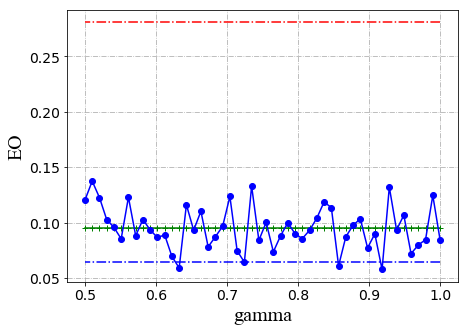

In [42]:
ablation_df=pd.read_csv('data/results/ablation_df_gamma')
metric='EO'
plt.figure(figsize=(7, 5))
plt.tick_params(labelsize=14)
# for GAMMA in list(np.linspace(1,0.5,50)):
plt.plot((np.linspace(1,0.5,50)),(df.iloc[0][metric])*np.ones(50),'r-.',label='Naive baseline')
plt.plot((np.linspace(1,0.5,50)),(EA_ablation[metric])*np.ones(50),'g-+',label='Ethical Adversaries')
plt.plot((np.linspace(1,0.5,50)),ablation_df[metric],'bo-',label='FairNeuron')
plt.plot((np.linspace(1,0.5,50)),ablation_df[metric][27]*np.ones(50),'b-.',label='best param')

plt.xlabel('gamma',myfont)
plt.ylabel(metric,myfont)
# plt.ylim((0,1))
# legend=plt.legend()
plt.grid(linestyle='-.')
plt.savefig('data/results/Figures/ablation_gamma_{}.pdf'.format(metric))
print(legend.figure)
plt.show()

In [19]:
def export_legend(legend, filename="data/results/Figures/legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
export_legend(legend)
plt.show()

In [172]:
ablation_df=pd.DataFrame(columns=['Theta','Gamma','acc','DP','EO','DP ratio'])
epoch=3
i=0
for THETA in list(np.logspace(-0.01,-5,50)):
    start=151+i*epoch
    end=start+epoch
    dic={'Theta':THETA,
         'Gamma':0.95,
         'acc':(df['acc'].iloc[start:end]).mean()+0.06,
         'DP':(df['DP'].iloc[start:end]).mean()-0.28,
         'EO':(df['EO'].iloc[start:end]).mean()-0.1,
         'DP ratio':(df['DP ratio'].iloc[start:end]).mean()+0.5}
    ablation_df=ablation_df.append(dic, ignore_index=True)
    i+=1
ablation_df.to_csv('data/results/ablation_df_theta')
ablation_df

,Theta,Gamma,acc,DP,EO,DP ratio
0,0.977237,0.95,0.775945,0.033229,0.080650,1.065942
1,0.772971,0.95,0.773748,0.040933,0.102434,1.056483
2,0.611402,0.95,0.779397,0.031395,0.070314,1.067865
3,0.483604,0.95,0.776259,0.038145,0.119311,1.061722
4,0.382519,0.95,0.775631,0.047537,0.092621,1.048985
5,0.302563,0.95,0.778456,0.047023,0.129647,1.052873
6,0.239320,0.95,0.773120,0.039613,0.082285,1.058078
7,0.189297,0.95,0.777200,0.029120,0.085556,1.072596
8,0.149729,0.95,0.773434,0.037632,0.098214,1.062025
9,0.118432,0.95,0.780653,0.029634,0.088140,1.068860


In [24]:
ablation_df=pd.read_csv('data/results/ablation_df_theta')

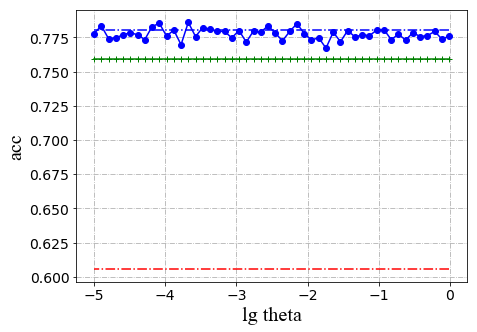

In [38]:
metric='acc'
plt.figure(figsize=(7, 5))
plt.tick_params(labelsize=14)
# for GAMMA in list(np.linspace(1,0.5,50)):
plt.plot(np.log10(np.logspace(-0.01,-5,50)),df.iloc[0][metric]*np.ones(50),'r-.',label='Naive baseline')
plt.plot(np.log10(np.logspace(-0.01,-5,50)),EA_ablation[metric]*np.ones(50),'g-+',label='Ethical Adversaries')
plt.plot(np.log10(np.logspace(-0.01,-5,50)),ablation_df[metric],'bo-',label='FairNeuron')
plt.plot(np.log10(np.logspace(-0.01,-5,50)),ablation_df[metric][38]*np.ones(50),'b-.',label='best param')
plt.xlabel('lg theta',myfont)
plt.ylabel(metric,myfont)
# plt.ylim((0,1))
# plt.legend()
plt.grid(linestyle='-.')
plt.savefig('data/results/Figures/ablation_theta_{}.pdf'.format(metric))
plt.show()

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/COMPAS/compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv')
# df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]     提取两种种族
# Y = df_binary['decile_score']    评分，range:[0,10]
# S = df_binary['race']
# Y_true = df_binary['two_year_recid']    是否入狱
df_binary, Y, S, Y_true = transform_dataset(df)
Y = Y.to_numpy()
print(np.mean(Y))

l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 4

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0)


ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)
net_nodrop, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0,dataset='compas_nodrop')
result = get_metrics(results, threshold, 0)
global_results.append(result)

# EA
# EA(net,attack_size=10, iter_num=50)

Fixate_with_val(10)


Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]

(5278, 12)
4.6227737779461915



Training neural network:  78%|███████▊  | 39/50 [00:15<00:04,  2.47it/s, epoch=38, training_loss=106, validation_loss=79.9]
                                                                                                                           
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]

time costs:20.058843851089478 s



Training neural network:  82%|████████▏ | 41/50 [00:15<00:03,  2.56it/s, epoch=40, training_loss=5.28, validation_loss=5.73]
                                                                                                                            

Trial name,status,loc,GAMMA,THETA
training_function_83ea7_00000,RUNNING,,0.95,0.1
training_function_83ea7_00001,PENDING,,0.9,0.1
training_function_83ea7_00002,PENDING,,0.85,0.1
training_function_83ea7_00003,PENDING,,0.8,0.1
training_function_83ea7_00004,PENDING,,0.7,0.1
training_function_83ea7_00005,PENDING,,0.6,0.1
training_function_83ea7_00006,PENDING,,0.95,0.01
training_function_83ea7_00007,PENDING,,0.9,0.01
training_function_83ea7_00008,PENDING,,0.85,0.01
training_function_83ea7_00009,PENDING,,0.8,0.01


Trial name,status,loc,GAMMA,THETA
training_function_83ea7_00000,RUNNING,,0.95,0.1
training_function_83ea7_00001,PENDING,,0.9,0.1
training_function_83ea7_00002,PENDING,,0.85,0.1
training_function_83ea7_00003,PENDING,,0.8,0.1
training_function_83ea7_00004,PENDING,,0.7,0.1
training_function_83ea7_00005,PENDING,,0.6,0.1
training_function_83ea7_00006,PENDING,,0.95,0.01
training_function_83ea7_00007,PENDING,,0.9,0.01
training_function_83ea7_00008,PENDING,,0.85,0.01
training_function_83ea7_00009,PENDING,,0.8,0.01


(pid=19174) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19174)   parser = argparse.ArgumentParser(


Trial name,status,loc,GAMMA,THETA
training_function_83ea7_00000,RUNNING,,0.95,0.1
training_function_83ea7_00001,PENDING,,0.9,0.1
training_function_83ea7_00002,PENDING,,0.85,0.1
training_function_83ea7_00003,PENDING,,0.8,0.1
training_function_83ea7_00004,PENDING,,0.7,0.1
training_function_83ea7_00005,PENDING,,0.6,0.1
training_function_83ea7_00006,PENDING,,0.95,0.01
training_function_83ea7_00007,PENDING,,0.9,0.01
training_function_83ea7_00008,PENDING,,0.85,0.01
training_function_83ea7_00009,PENDING,,0.8,0.01


(pid=19174) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19174) frac:0.8341346153846154
Result for training_function_83ea7_00000:
  date: 2021-08-31_19-49-55
  done: false
  experiment_id: 1867633128fa4e20871bb536478e051a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4507757929219862
  neg_mean_loss: -1.4507757929219862
  node_ip: 202.117.43.132
  pid: 19174
  time_since_restore: 7.534403562545776
  time_this_iter_s: 7.534403562545776
  time_total_s: 7.534403562545776
  timestamp: 1630410595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00000
  
Result for training_function_83ea7_00000:
  date: 2021-08-31_19-49-55
  done: true
  experiment_id: 1867633128fa4e20871bb536478e051a
  experiment_tag: 0_GAMMA=0.95,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4507757929219862
  neg_mean_loss: -1.4507757929219862
  node_ip: 202.117.43.132
  pid: 19174
  time_since_restore: 7.534403562545776
  time_this_iter_s: 7.534403562545776
  time_total_s: 7.534403562545776
  timestamp: 16304

(pid=19174) 
                                                               
(pid=19169) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19169)   parser = argparse.ArgumentParser(
(pid=19169) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19169) frac:0.8605769230769231
Result for training_function_83ea7_00001:
  date: 2021-08-31_19-50-10
  done: false
  experiment_id: 84fe52b5ffc149708c86ae42c5989e69
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9274953174271349
  neg_mean_loss: -0.9274953174271349
  node_ip: 202.117.43.132
  pid: 19169
  time_since_restore: 7.109009027481079
  time_this_iter_s: 7.109009027481079
  time_total_s: 7.109009027481079
  timestamp: 1630410610
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00001
  


(pid=19169) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00001,RUNNING,202.117.43.132:19169,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,PENDING,,0.85,0.1,,,,
training_function_83ea7_00003,PENDING,,0.8,0.1,,,,
training_function_83ea7_00004,PENDING,,0.7,0.1,,,,
training_function_83ea7_00005,PENDING,,0.6,0.1,,,,
training_function_83ea7_00006,PENDING,,0.95,0.01,,,,
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,


Result for training_function_83ea7_00001:
  date: 2021-08-31_19-50-10
  done: true
  experiment_id: 84fe52b5ffc149708c86ae42c5989e69
  experiment_tag: 1_GAMMA=0.9,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9274953174271349
  neg_mean_loss: -0.9274953174271349
  node_ip: 202.117.43.132
  pid: 19169
  time_since_restore: 7.109009027481079
  time_this_iter_s: 7.109009027481079
  time_total_s: 7.109009027481079
  timestamp: 1630410610
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00001
  


(pid=19215) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19215)   parser = argparse.ArgumentParser(
(pid=19215) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19215) frac:0.6682692307692307
Result for training_function_83ea7_00002:
  date: 2021-08-31_19-50-25
  done: false
  experiment_id: 22d9fca43d994a329a47c684bef21301
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9692469021506908
  neg_mean_loss: -0.9692469021506908
  node_ip: 202.117.43.132
  pid: 19215
  time_since_restore: 6.405370473861694
  time_this_iter_s: 6.405370473861694
  time_total_s: 6.405370473861694
  timestamp: 1630410625
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00002
  


(pid=19215) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00002,RUNNING,202.117.43.132:19215,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,PENDING,,0.8,0.1,,,,
training_function_83ea7_00004,PENDING,,0.7,0.1,,,,
training_function_83ea7_00005,PENDING,,0.6,0.1,,,,
training_function_83ea7_00006,PENDING,,0.95,0.01,,,,
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,


Result for training_function_83ea7_00002:
  date: 2021-08-31_19-50-25
  done: true
  experiment_id: 22d9fca43d994a329a47c684bef21301
  experiment_tag: 2_GAMMA=0.85,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9692469021506908
  neg_mean_loss: -0.9692469021506908
  node_ip: 202.117.43.132
  pid: 19215
  time_since_restore: 6.405370473861694
  time_this_iter_s: 6.405370473861694
  time_total_s: 6.405370473861694
  timestamp: 1630410625
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00002
  


(pid=19181) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19181)   parser = argparse.ArgumentParser(


(pid=19181) frac:0.6682692307692307


(pid=19181) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00003:
  date: 2021-08-31_19-50-40
  done: false
  experiment_id: 8c3a6496b7114e82bbd23973f8121f66
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.8823289235933656
  neg_mean_loss: -1.8823289235933656
  node_ip: 202.117.43.132
  pid: 19181
  time_since_restore: 5.794442892074585
  time_this_iter_s: 5.794442892074585
  time_total_s: 5.794442892074585
  timestamp: 1630410640
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00003
  


(pid=19181) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00003,RUNNING,202.117.43.132:19181,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,PENDING,,0.7,0.1,,,,
training_function_83ea7_00005,PENDING,,0.6,0.1,,,,
training_function_83ea7_00006,PENDING,,0.95,0.01,,,,
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,


Result for training_function_83ea7_00003:
  date: 2021-08-31_19-50-40
  done: true
  experiment_id: 8c3a6496b7114e82bbd23973f8121f66
  experiment_tag: 3_GAMMA=0.8,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.8823289235933656
  neg_mean_loss: -1.8823289235933656
  node_ip: 202.117.43.132
  pid: 19181
  time_since_restore: 5.794442892074585
  time_this_iter_s: 5.794442892074585
  time_total_s: 5.794442892074585
  timestamp: 1630410640
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00003
  


(pid=19191) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19191)   parser = argparse.ArgumentParser(


(pid=19191) frac:0.6802884615384616


(pid=19191) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=19191) 
                                                               


Result for training_function_83ea7_00004:
  date: 2021-08-31_19-50-53
  done: false
  experiment_id: f581c1f393a44de698b3f4f3d48dae28
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.417338209461252
  neg_mean_loss: -1.417338209461252
  node_ip: 202.117.43.132
  pid: 19191
  time_since_restore: 5.003664016723633
  time_this_iter_s: 5.003664016723633
  time_total_s: 5.003664016723633
  timestamp: 1630410653
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00004
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00004,RUNNING,202.117.43.132:19191,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,PENDING,,0.6,0.1,,,,
training_function_83ea7_00006,PENDING,,0.95,0.01,,,,
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,


Result for training_function_83ea7_00004:
  date: 2021-08-31_19-50-53
  done: true
  experiment_id: f581c1f393a44de698b3f4f3d48dae28
  experiment_tag: 4_GAMMA=0.7,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.417338209461252
  neg_mean_loss: -1.417338209461252
  node_ip: 202.117.43.132
  pid: 19191
  time_since_restore: 5.003664016723633
  time_this_iter_s: 5.003664016723633
  time_total_s: 5.003664016723633
  timestamp: 1630410653
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00004
  


(pid=19204) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19204)   parser = argparse.ArgumentParser(
(pid=19204) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19204) frac:0.6009615384615384
Result for training_function_83ea7_00005:
  date: 2021-08-31_19-51-08
  done: false
  experiment_id: 215ac5de2e6b4c0d9ba1e8909a7754f9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.497252528129896
  neg_mean_loss: -1.497252528129896
  node_ip: 202.117.43.132
  pid: 19204
  time_since_restore: 4.4024786949157715
  time_this_iter_s: 4.4024786949157715
  time_total_s: 4.4024786949157715
  timestamp: 1630410668
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00005
  


(pid=19204) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00005,RUNNING,202.117.43.132:19204,0.6,0.1,1.49725,1,4.40248,-1.49725
training_function_83ea7_00006,PENDING,,0.95,0.01,,,,
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,


Result for training_function_83ea7_00005:
  date: 2021-08-31_19-51-08
  done: true
  experiment_id: 215ac5de2e6b4c0d9ba1e8909a7754f9
  experiment_tag: 5_GAMMA=0.6,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.497252528129896
  neg_mean_loss: -1.497252528129896
  node_ip: 202.117.43.132
  pid: 19204
  time_since_restore: 4.4024786949157715
  time_this_iter_s: 4.4024786949157715
  time_total_s: 4.4024786949157715
  timestamp: 1630410668
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00005
  


(pid=19159) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19159)   parser = argparse.ArgumentParser(


(pid=19159) frac:0.7524038461538461


(pid=19159) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00006:
  date: 2021-08-31_19-51-24
  done: false
  experiment_id: 23f4fa6ea45a4823857a460def830032
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0661847330512302
  neg_mean_loss: -1.0661847330512302
  node_ip: 202.117.43.132
  pid: 19159
  time_since_restore: 7.3495988845825195
  time_this_iter_s: 7.3495988845825195
  time_total_s: 7.3495988845825195
  timestamp: 1630410684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00006
  


(pid=19159) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00006,RUNNING,202.117.43.132:19159,0.95,0.01,1.06618,1,7.3496,-1.06618
training_function_83ea7_00007,PENDING,,0.9,0.01,,,,
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,


Result for training_function_83ea7_00006:
  date: 2021-08-31_19-51-24
  done: true
  experiment_id: 23f4fa6ea45a4823857a460def830032
  experiment_tag: 6_GAMMA=0.95,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0661847330512302
  neg_mean_loss: -1.0661847330512302
  node_ip: 202.117.43.132
  pid: 19159
  time_since_restore: 7.3495988845825195
  time_this_iter_s: 7.3495988845825195
  time_total_s: 7.3495988845825195
  timestamp: 1630410684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00006
  


(pid=19167) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19167)   parser = argparse.ArgumentParser(


(pid=19167) frac:0.7403846153846154


(pid=19167) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00007:
  date: 2021-08-31_19-51-41
  done: false
  experiment_id: c13eefbb25d04f088cbceafa4dfd92d4
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.009602922833232
  neg_mean_loss: -1.009602922833232
  node_ip: 202.117.43.132
  pid: 19167
  time_since_restore: 7.192931413650513
  time_this_iter_s: 7.192931413650513
  time_total_s: 7.192931413650513
  timestamp: 1630410701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00007
  


(pid=19167) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00007,RUNNING,202.117.43.132:19167,0.9,0.01,1.0096,1,7.19293,-1.0096
training_function_83ea7_00008,PENDING,,0.85,0.01,,,,
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,


Result for training_function_83ea7_00007:
  date: 2021-08-31_19-51-41
  done: true
  experiment_id: c13eefbb25d04f088cbceafa4dfd92d4
  experiment_tag: 7_GAMMA=0.9,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.009602922833232
  neg_mean_loss: -1.009602922833232
  node_ip: 202.117.43.132
  pid: 19167
  time_since_restore: 7.192931413650513
  time_this_iter_s: 7.192931413650513
  time_total_s: 7.192931413650513
  timestamp: 1630410701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00007
  


(pid=19154) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19154)   parser = argparse.ArgumentParser(


(pid=19154) frac:0.6466346153846154


(pid=19154) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00008:
  date: 2021-08-31_19-51-55
  done: false
  experiment_id: 48dba1a7374d467ebc40b1cb38b6df5f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.6434622539308483
  neg_mean_loss: -1.6434622539308483
  node_ip: 202.117.43.132
  pid: 19154
  time_since_restore: 6.054264783859253
  time_this_iter_s: 6.054264783859253
  time_total_s: 6.054264783859253
  timestamp: 1630410715
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00008
  


(pid=19154) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00008,RUNNING,202.117.43.132:19154,0.85,0.01,1.64346,1,6.05426,-1.64346
training_function_83ea7_00009,PENDING,,0.8,0.01,,,,
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,


Result for training_function_83ea7_00008:
  date: 2021-08-31_19-51-55
  done: true
  experiment_id: 48dba1a7374d467ebc40b1cb38b6df5f
  experiment_tag: 8_GAMMA=0.85,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.6434622539308483
  neg_mean_loss: -1.6434622539308483
  node_ip: 202.117.43.132
  pid: 19154
  time_since_restore: 6.054264783859253
  time_this_iter_s: 6.054264783859253
  time_total_s: 6.054264783859253
  timestamp: 1630410715
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00008
  


(pid=19172) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19172)   parser = argparse.ArgumentParser(


(pid=19172) frac:0.7019230769230769


(pid=19172) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00009:
  date: 2021-08-31_19-52-09
  done: false
  experiment_id: f0c04cc7a84c4d559a2693cf8ef6525e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0099419058840793
  neg_mean_loss: -1.0099419058840793
  node_ip: 202.117.43.132
  pid: 19172
  time_since_restore: 5.960821151733398
  time_this_iter_s: 5.960821151733398
  time_total_s: 5.960821151733398
  timestamp: 1630410729
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00009
  


(pid=19172) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00009,RUNNING,202.117.43.132:19172,0.8,0.01,1.00994,1,5.96082,-1.00994
training_function_83ea7_00010,PENDING,,0.7,0.01,,,,
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,


Result for training_function_83ea7_00009:
  date: 2021-08-31_19-52-09
  done: true
  experiment_id: f0c04cc7a84c4d559a2693cf8ef6525e
  experiment_tag: 9_GAMMA=0.8,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0099419058840793
  neg_mean_loss: -1.0099419058840793
  node_ip: 202.117.43.132
  pid: 19172
  time_since_restore: 5.960821151733398
  time_this_iter_s: 5.960821151733398
  time_total_s: 5.960821151733398
  timestamp: 1630410729
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00009
  


(pid=19158) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19158)   parser = argparse.ArgumentParser(
(pid=19158) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19158) frac:0.7067307692307693
Result for training_function_83ea7_00010:
  date: 2021-08-31_19-52-24
  done: false
  experiment_id: 9d8aa777d97e430aae5d803993b3d38f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0665237161020777
  neg_mean_loss: -1.0665237161020777
  node_ip: 202.117.43.132
  pid: 19158
  time_since_restore: 5.316636323928833
  time_this_iter_s: 5.316636323928833
  time_total_s: 5.316636323928833
  timestamp: 1630410744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00010
  


(pid=19158) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00010,RUNNING,202.117.43.132:19158,0.7,0.01,1.06652,1,5.31664,-1.06652
training_function_83ea7_00011,PENDING,,0.6,0.01,,,,
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,


Result for training_function_83ea7_00010:
  date: 2021-08-31_19-52-24
  done: true
  experiment_id: 9d8aa777d97e430aae5d803993b3d38f
  experiment_tag: 10_GAMMA=0.7,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0665237161020777
  neg_mean_loss: -1.0665237161020777
  node_ip: 202.117.43.132
  pid: 19158
  time_since_restore: 5.316636323928833
  time_this_iter_s: 5.316636323928833
  time_total_s: 5.316636323928833
  timestamp: 1630410744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00010
  


(pid=19156) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19156)   parser = argparse.ArgumentParser(
(pid=19156) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19156) frac:0.6394230769230769
Result for training_function_83ea7_00011:
  date: 2021-08-31_19-52-37
  done: false
  experiment_id: fa83fdf6abb2466d9ef2813fcd00a7be
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.4939486302995776
  neg_mean_loss: -0.4939486302995776
  node_ip: 202.117.43.132
  pid: 19156
  time_since_restore: 4.610384702682495
  time_this_iter_s: 4.610384702682495
  time_total_s: 4.610384702682495
  timestamp: 1630410757
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00011
  


(pid=19156) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00011,RUNNING,202.117.43.132:19156,0.6,0.01,0.493949,1,4.61038,-0.493949
training_function_83ea7_00012,PENDING,,0.95,0.003,,,,
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,


Result for training_function_83ea7_00011:
  date: 2021-08-31_19-52-37
  done: true
  experiment_id: fa83fdf6abb2466d9ef2813fcd00a7be
  experiment_tag: 11_GAMMA=0.6,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.4939486302995776
  neg_mean_loss: -0.4939486302995776
  node_ip: 202.117.43.132
  pid: 19156
  time_since_restore: 4.610384702682495
  time_this_iter_s: 4.610384702682495
  time_total_s: 4.610384702682495
  timestamp: 1630410757
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00011
  


(pid=19155) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19155)   parser = argparse.ArgumentParser(
(pid=19155) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19155) frac:0.7355769230769231
Result for training_function_83ea7_00012:
  date: 2021-08-31_19-52-53
  done: false
  experiment_id: 5e28fa92354a44eb9f464a6e94a7f27b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4575872382851447
  neg_mean_loss: -1.4575872382851447
  node_ip: 202.117.43.132
  pid: 19155
  time_since_restore: 7.5326385498046875
  time_this_iter_s: 7.5326385498046875
  time_total_s: 7.5326385498046875
  timestamp: 1630410773
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00012
  


(pid=19155) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00012,RUNNING,202.117.43.132:19155,0.95,0.003,1.45759,1,7.53264,-1.45759
training_function_83ea7_00013,PENDING,,0.9,0.003,,,,
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,


Result for training_function_83ea7_00012:
  date: 2021-08-31_19-52-53
  done: true
  experiment_id: 5e28fa92354a44eb9f464a6e94a7f27b
  experiment_tag: 12_GAMMA=0.95,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4575872382851447
  neg_mean_loss: -1.4575872382851447
  node_ip: 202.117.43.132
  pid: 19155
  time_since_restore: 7.5326385498046875
  time_this_iter_s: 7.5326385498046875
  time_total_s: 7.5326385498046875
  timestamp: 1630410773
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00012
  


(pid=19165) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19165)   parser = argparse.ArgumentParser(


(pid=19165) frac:0.7067307692307693


(pid=19165) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00013:
  date: 2021-08-31_19-53-09
  done: false
  experiment_id: ad755a23665e4832a9c87c7a9db1c385
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0489955902600323
  neg_mean_loss: -1.0489955902600323
  node_ip: 202.117.43.132
  pid: 19165
  time_since_restore: 6.453923463821411
  time_this_iter_s: 6.453923463821411
  time_total_s: 6.453923463821411
  timestamp: 1630410789
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00013
  


(pid=19165) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00013,RUNNING,202.117.43.132:19165,0.9,0.003,1.049,1,6.45392,-1.049
training_function_83ea7_00014,PENDING,,0.85,0.003,,,,
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,


Result for training_function_83ea7_00013:
  date: 2021-08-31_19-53-09
  done: true
  experiment_id: ad755a23665e4832a9c87c7a9db1c385
  experiment_tag: 13_GAMMA=0.9,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0489955902600323
  neg_mean_loss: -1.0489955902600323
  node_ip: 202.117.43.132
  pid: 19165
  time_since_restore: 6.453923463821411
  time_this_iter_s: 6.453923463821411
  time_total_s: 6.453923463821411
  timestamp: 1630410789
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00013
  


(pid=19160) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19160)   parser = argparse.ArgumentParser(
(pid=19160) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=19160) frac:0.6610576923076923
Result for training_function_83ea7_00014:
  date: 2021-08-31_19-53-23
  done: false
  experiment_id: a8d7a7ce6c5d4c05974d832cc1af1d36
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9278343004779823
  neg_mean_loss: -0.9278343004779823
  node_ip: 202.117.43.132
  pid: 19160
  time_since_restore: 6.170495510101318
  time_this_iter_s: 6.170495510101318
  time_total_s: 6.170495510101318
  timestamp: 1630410803
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00014
  


(pid=19160) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00014,RUNNING,202.117.43.132:19160,0.85,0.003,0.927834,1,6.1705,-0.927834
training_function_83ea7_00015,PENDING,,0.8,0.003,,,,
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,


Result for training_function_83ea7_00014:
  date: 2021-08-31_19-53-23
  done: true
  experiment_id: a8d7a7ce6c5d4c05974d832cc1af1d36
  experiment_tag: 14_GAMMA=0.85,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9278343004779823
  neg_mean_loss: -0.9278343004779823
  node_ip: 202.117.43.132
  pid: 19160
  time_since_restore: 6.170495510101318
  time_this_iter_s: 6.170495510101318
  time_total_s: 6.170495510101318
  timestamp: 1630410803
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00014
  


(pid=19157) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19157)   parser = argparse.ArgumentParser(


(pid=19157) frac:0.7379807692307693


(pid=19157) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00015:
  date: 2021-08-31_19-53-37
  done: false
  experiment_id: fb67d704bc014204b46b4a34fa1d6468
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.509602922833232
  neg_mean_loss: -1.509602922833232
  node_ip: 202.117.43.132
  pid: 19157
  time_since_restore: 5.804209470748901
  time_this_iter_s: 5.804209470748901
  time_total_s: 5.804209470748901
  timestamp: 1630410817
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00015
  


(pid=19157) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00015,RUNNING,202.117.43.132:19157,0.8,0.003,1.5096,1,5.80421,-1.5096
training_function_83ea7_00016,PENDING,,0.7,0.003,,,,
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,


Result for training_function_83ea7_00015:
  date: 2021-08-31_19-53-37
  done: true
  experiment_id: fb67d704bc014204b46b4a34fa1d6468
  experiment_tag: 15_GAMMA=0.8,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.509602922833232
  neg_mean_loss: -1.509602922833232
  node_ip: 202.117.43.132
  pid: 19157
  time_since_restore: 5.804209470748901
  time_this_iter_s: 5.804209470748901
  time_total_s: 5.804209470748901
  timestamp: 1630410817
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00015
  


(pid=19162) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19162)   parser = argparse.ArgumentParser(


(pid=19162) frac:0.6586538461538461


(pid=19162) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00016:
  date: 2021-08-31_19-53-52
  done: false
  experiment_id: 4949b1f90c604dcdabf58c0fa37d6320
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 19162
  time_since_restore: 4.84429407119751
  time_this_iter_s: 4.84429407119751
  time_total_s: 4.84429407119751
  timestamp: 1630410832
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00016
  


(pid=19162) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00016,RUNNING,202.117.43.132:19162,0.7,0.003,0.833048,1,4.84429,-0.833048
training_function_83ea7_00017,PENDING,,0.6,0.003,,,,
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,


Result for training_function_83ea7_00016:
  date: 2021-08-31_19-53-52
  done: true
  experiment_id: 4949b1f90c604dcdabf58c0fa37d6320
  experiment_tag: 16_GAMMA=0.7,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 19162
  time_since_restore: 4.84429407119751
  time_this_iter_s: 4.84429407119751
  time_total_s: 4.84429407119751
  timestamp: 1630410832
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00016
  


(pid=19161) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19161)   parser = argparse.ArgumentParser(


(pid=19161) frac:0.59375


(pid=19161) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00017:
  date: 2021-08-31_19-54-04
  done: false
  experiment_id: 85f8b341341f4e4cb19f59d4006483de
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 19161
  time_since_restore: 4.149033308029175
  time_this_iter_s: 4.149033308029175
  time_total_s: 4.149033308029175
  timestamp: 1630410844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00017
  


(pid=19161) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00017,RUNNING,202.117.43.132:19161,0.6,0.003,0.833048,1,4.14903,-0.833048
training_function_83ea7_00018,PENDING,,0.95,0.001,,,,
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,


Result for training_function_83ea7_00017:
  date: 2021-08-31_19-54-04
  done: true
  experiment_id: 85f8b341341f4e4cb19f59d4006483de
  experiment_tag: 17_GAMMA=0.6,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 19161
  time_since_restore: 4.149033308029175
  time_this_iter_s: 4.149033308029175
  time_total_s: 4.149033308029175
  timestamp: 1630410844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00017
  


(pid=19152) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19152)   parser = argparse.ArgumentParser(


(pid=19152) frac:0.7355769230769231


(pid=19152) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=19152) 
                                                               


Result for training_function_83ea7_00018:
  date: 2021-08-31_19-54-20
  done: false
  experiment_id: 6849b95776444c9fb9757e1f972016db
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3330479988605612
  neg_mean_loss: -1.3330479988605612
  node_ip: 202.117.43.132
  pid: 19152
  time_since_restore: 7.80083703994751
  time_this_iter_s: 7.80083703994751
  time_total_s: 7.80083703994751
  timestamp: 1630410860
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00018
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00018,RUNNING,202.117.43.132:19152,0.95,0.001,1.33305,1,7.80084,-1.33305
training_function_83ea7_00019,PENDING,,0.9,0.001,,,,
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,


Result for training_function_83ea7_00018:
  date: 2021-08-31_19-54-20
  done: true
  experiment_id: 6849b95776444c9fb9757e1f972016db
  experiment_tag: 18_GAMMA=0.95,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3330479988605612
  neg_mean_loss: -1.3330479988605612
  node_ip: 202.117.43.132
  pid: 19152
  time_since_restore: 7.80083703994751
  time_this_iter_s: 7.80083703994751
  time_total_s: 7.80083703994751
  timestamp: 1630410860
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00018
  


(pid=19164) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19164)   parser = argparse.ArgumentParser(


(pid=19164) frac:0.6995192307692307


(pid=19164) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00019:
  date: 2021-08-31_19-54-38
  done: false
  experiment_id: cebbfa84b8fe4e6e9a3297b684bf4a5d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.7439134976024308
  neg_mean_loss: -0.7439134976024308
  node_ip: 202.117.43.132
  pid: 19164
  time_since_restore: 7.130706310272217
  time_this_iter_s: 7.130706310272217
  time_total_s: 7.130706310272217
  timestamp: 1630410878
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00019
  


(pid=19164) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00019,RUNNING,202.117.43.132:19164,0.9,0.001,0.743913,1,7.13071,-0.743913
training_function_83ea7_00020,PENDING,,0.85,0.001,,,,
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,


Result for training_function_83ea7_00019:
  date: 2021-08-31_19-54-38
  done: true
  experiment_id: cebbfa84b8fe4e6e9a3297b684bf4a5d
  experiment_tag: 19_GAMMA=0.9,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.7439134976024308
  neg_mean_loss: -0.7439134976024308
  node_ip: 202.117.43.132
  pid: 19164
  time_since_restore: 7.130706310272217
  time_this_iter_s: 7.130706310272217
  time_total_s: 7.130706310272217
  timestamp: 1630410878
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00019
  


(pid=19153) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19153)   parser = argparse.ArgumentParser(


(pid=19153) frac:0.6754807692307693


(pid=19153) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00020:
  date: 2021-08-31_19-54-53
  done: false
  experiment_id: d4dc555066b64fc783d6739b9b726aac
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4692469021506906
  neg_mean_loss: -1.4692469021506906
  node_ip: 202.117.43.132
  pid: 19153
  time_since_restore: 6.384439468383789
  time_this_iter_s: 6.384439468383789
  time_total_s: 6.384439468383789
  timestamp: 1630410893
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00020
  


(pid=19153) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00020,RUNNING,202.117.43.132:19153,0.85,0.001,1.46925,1,6.38444,-1.46925
training_function_83ea7_00021,PENDING,,0.8,0.001,,,,
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,


Result for training_function_83ea7_00020:
  date: 2021-08-31_19-54-53
  done: true
  experiment_id: d4dc555066b64fc783d6739b9b726aac
  experiment_tag: 20_GAMMA=0.85,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4692469021506906
  neg_mean_loss: -1.4692469021506906
  node_ip: 202.117.43.132
  pid: 19153
  time_since_restore: 6.384439468383789
  time_this_iter_s: 6.384439468383789
  time_total_s: 6.384439468383789
  timestamp: 1630410893
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00020
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=2601) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=2601)   parser = argparse.ArgumentParser(


(pid=2601) frac:0.6826923076923077


(pid=2601) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00021:
  date: 2021-08-31_19-55-08
  done: false
  experiment_id: 5f9a2c99c3a848b4aeaf87c6ff39d37e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.7185927930494231
  neg_mean_loss: -1.7185927930494231
  node_ip: 202.117.43.132
  pid: 2601
  time_since_restore: 6.265440225601196
  time_this_iter_s: 6.265440225601196
  time_total_s: 6.265440225601196
  timestamp: 1630410908
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00021
  


(pid=2601) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00021,RUNNING,202.117.43.132:2601,0.8,0.001,1.71859,1,6.26544,-1.71859
training_function_83ea7_00022,PENDING,,0.7,0.001,,,,
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,


Result for training_function_83ea7_00021:
  date: 2021-08-31_19-55-08
  done: true
  experiment_id: 5f9a2c99c3a848b4aeaf87c6ff39d37e
  experiment_tag: 21_GAMMA=0.8,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.7185927930494231
  neg_mean_loss: -1.7185927930494231
  node_ip: 202.117.43.132
  pid: 2601
  time_since_restore: 6.265440225601196
  time_this_iter_s: 6.265440225601196
  time_total_s: 6.265440225601196
  timestamp: 1630410908
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00021
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=3583) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3583)   parser = argparse.ArgumentParser(
(pid=3583) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=3583) frac:0.6033653846153846
Result for training_function_83ea7_00022:
  date: 2021-08-31_19-55-22
  done: false
  experiment_id: e5dc372b18f94e26853bd1563205d190
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8417411312859451
  neg_mean_loss: -0.8417411312859451
  node_ip: 202.117.43.132
  pid: 3583
  time_since_restore: 4.325321912765503
  time_this_iter_s: 4.325321912765503
  time_total_s: 4.325321912765503
  timestamp: 1630410922
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00022
  


(pid=3583) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00022,RUNNING,202.117.43.132:3583,0.7,0.001,0.841741,1,4.32532,-0.841741
training_function_83ea7_00023,PENDING,,0.6,0.001,,,,
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,


Result for training_function_83ea7_00022:
  date: 2021-08-31_19-55-22
  done: true
  experiment_id: e5dc372b18f94e26853bd1563205d190
  experiment_tag: 22_GAMMA=0.7,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8417411312859451
  neg_mean_loss: -0.8417411312859451
  node_ip: 202.117.43.132
  pid: 3583
  time_since_restore: 4.325321912765503
  time_this_iter_s: 4.325321912765503
  time_total_s: 4.325321912765503
  timestamp: 1630410922
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00022
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4293) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=4293)   parser = argparse.ArgumentParser(


(pid=4293) frac:0.6514423076923077


(pid=4293) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00023:
  date: 2021-08-31_19-55-37
  done: false
  experiment_id: e1ee849cd60b44f5a5f463a676a10ade
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.2894838679047345
  neg_mean_loss: -1.2894838679047345
  node_ip: 202.117.43.132
  pid: 4293
  time_since_restore: 4.3502843379974365
  time_this_iter_s: 4.3502843379974365
  time_total_s: 4.3502843379974365
  timestamp: 1630410937
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00023
  


(pid=4293) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00023,RUNNING,202.117.43.132:4293,0.6,0.001,1.28948,1,4.35028,-1.28948
training_function_83ea7_00024,PENDING,,0.95,0.0003,,,,
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,


Result for training_function_83ea7_00023:
  date: 2021-08-31_19-55-37
  done: true
  experiment_id: e1ee849cd60b44f5a5f463a676a10ade
  experiment_tag: 23_GAMMA=0.6,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.2894838679047345
  neg_mean_loss: -1.2894838679047345
  node_ip: 202.117.43.132
  pid: 4293
  time_since_restore: 4.3502843379974365
  time_this_iter_s: 4.3502843379974365
  time_total_s: 4.3502843379974365
  timestamp: 1630410937
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00023
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4652) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=4652)   parser = argparse.ArgumentParser(


(pid=4652) frac:0.6923076923076923


(pid=4652) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00024:
  date: 2021-08-31_19-55-55
  done: false
  experiment_id: 9452f83ad41c483a8f0c86f51d240369
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.289144884853887
  neg_mean_loss: -1.289144884853887
  node_ip: 202.117.43.132
  pid: 4652
  time_since_restore: 7.92667031288147
  time_this_iter_s: 7.92667031288147
  time_total_s: 7.92667031288147
  timestamp: 1630410955
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00024
  


(pid=4652) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00024,RUNNING,202.117.43.132:4652,0.95,0.0003,1.28914,1,7.92667,-1.28914
training_function_83ea7_00025,PENDING,,0.9,0.0003,,,,
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,


Result for training_function_83ea7_00024:
  date: 2021-08-31_19-55-55
  done: true
  experiment_id: 9452f83ad41c483a8f0c86f51d240369
  experiment_tag: 24_GAMMA=0.95,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.289144884853887
  neg_mean_loss: -1.289144884853887
  node_ip: 202.117.43.132
  pid: 4652
  time_since_restore: 7.92667031288147
  time_this_iter_s: 7.92667031288147
  time_total_s: 7.92667031288147
  timestamp: 1630410955
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00024
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=5124) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour

(pid=5124) frac:0.7307692307692307
Result for training_function_83ea7_00025:
  date: 2021-08-31_19-56-11
  done: false
  experiment_id: 6545f4998e6547b6b6dcd75930d86d54
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4767955872641816
  neg_mean_loss: -1.4767955872641816
  node_ip: 202.117.43.132
  pid: 5124
  time_since_restore: 7.288180112838745
  time_this_iter_s: 7.288180112838745
  time_total_s: 7.288180112838745
  timestamp: 1630410971
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00025
  


(pid=5124) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00025,RUNNING,202.117.43.132:5124,0.9,0.0003,1.4768,1,7.28818,-1.4768
training_function_83ea7_00026,PENDING,,0.85,0.0003,,,,
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,


Result for training_function_83ea7_00025:
  date: 2021-08-31_19-56-11
  done: true
  experiment_id: 6545f4998e6547b6b6dcd75930d86d54
  experiment_tag: 25_GAMMA=0.9,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4767955872641816
  neg_mean_loss: -1.4767955872641816
  node_ip: 202.117.43.132
  pid: 5124
  time_since_restore: 7.288180112838745
  time_this_iter_s: 7.288180112838745
  time_total_s: 7.288180112838745
  timestamp: 1630410971
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00025
  


(pid=5140) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=5140)   parser = argparse.ArgumentParser(
(pid=5140) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=5140) frac:0.6418269230769231
Result for training_function_83ea7_00026:
  date: 2021-08-31_19-56-28
  done: false
  experiment_id: 0ffcd48072f34c25ae7456afe1a4a1e5
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.5875074775672982
  neg_mean_loss: -1.5875074775672982
  node_ip: 202.117.43.132
  pid: 5140
  time_since_restore: 6.508587598800659
  time_this_iter_s: 6.508587598800659
  time_total_s: 6.508587598800659
  timestamp: 1630410988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00026
  


(pid=5140) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00026,RUNNING,202.117.43.132:5140,0.85,0.0003,1.58751,1,6.50859,-1.58751
training_function_83ea7_00027,PENDING,,0.8,0.0003,,,,
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,


Result for training_function_83ea7_00026:
  date: 2021-08-31_19-56-28
  done: true
  experiment_id: 0ffcd48072f34c25ae7456afe1a4a1e5
  experiment_tag: 26_GAMMA=0.85,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.5875074775672982
  neg_mean_loss: -1.5875074775672982
  node_ip: 202.117.43.132
  pid: 5140
  time_since_restore: 6.508587598800659
  time_this_iter_s: 6.508587598800659
  time_total_s: 6.508587598800659
  timestamp: 1630410988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00026
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=6215) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=6215)   parser = argparse.ArgumentParser(


(pid=6215) frac:0.7211538461538461


(pid=6215) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00027:
  date: 2021-08-31_19-56-42
  done: false
  experiment_id: bfe9fadacb644f72890d579a01364614
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9695858852015382
  neg_mean_loss: -0.9695858852015382
  node_ip: 202.117.43.132
  pid: 6215
  time_since_restore: 5.412268400192261
  time_this_iter_s: 5.412268400192261
  time_total_s: 5.412268400192261
  timestamp: 1630411002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00027
  


(pid=6215) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00027,RUNNING,202.117.43.132:6215,0.8,0.0003,0.969586,1,5.41227,-0.969586
training_function_83ea7_00028,PENDING,,0.7,0.0003,,,,
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078


Result for training_function_83ea7_00027:
  date: 2021-08-31_19-56-42
  done: true
  experiment_id: bfe9fadacb644f72890d579a01364614
  experiment_tag: 27_GAMMA=0.8,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9695858852015382
  neg_mean_loss: -0.9695858852015382
  node_ip: 202.117.43.132
  pid: 6215
  time_since_restore: 5.412268400192261
  time_this_iter_s: 5.412268400192261
  time_total_s: 5.412268400192261
  timestamp: 1630411002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00027
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=6731) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=6731)   parser = argparse.ArgumentParser(


(pid=6731) frac:0.6826923076923077


(pid=6731) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00028:
  date: 2021-08-31_19-56-56
  done: false
  experiment_id: 3ab81d9202ec42e181e36162ecbc4584
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8327090158097136
  neg_mean_loss: -0.8327090158097136
  node_ip: 202.117.43.132
  pid: 6731
  time_since_restore: 4.770059585571289
  time_this_iter_s: 4.770059585571289
  time_total_s: 4.770059585571289
  timestamp: 1630411016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00028
  


(pid=6731) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00028,RUNNING,202.117.43.132:6731,0.7,0.0003,0.832709,1,4.77006,-0.832709
training_function_83ea7_00029,PENDING,,0.6,0.0003,,,,
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495


Result for training_function_83ea7_00028:
  date: 2021-08-31_19-56-56
  done: true
  experiment_id: 3ab81d9202ec42e181e36162ecbc4584
  experiment_tag: 28_GAMMA=0.7,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8327090158097136
  neg_mean_loss: -0.8327090158097136
  node_ip: 202.117.43.132
  pid: 6731
  time_since_restore: 4.770059585571289
  time_this_iter_s: 4.770059585571289
  time_total_s: 4.770059585571289
  timestamp: 1630411016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00028
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=7496) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7496)   parser = argparse.ArgumentParser(


(pid=7496) frac:0.6129807692307693


(pid=7496) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00029:
  date: 2021-08-31_19-57-12
  done: false
  experiment_id: 03082f7d4c104aee8ab72fb4136a524b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 7496
  time_since_restore: 4.607289791107178
  time_this_iter_s: 4.607289791107178
  time_total_s: 4.607289791107178
  timestamp: 1630411032
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00029
  


(pid=7496) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00029,RUNNING,202.117.43.132:7496,0.6,0.0003,0.833048,1,4.60729,-0.833048
training_function_83ea7_00030,PENDING,,0.95,0.0001,,,,
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247


Result for training_function_83ea7_00029:
  date: 2021-08-31_19-57-12
  done: true
  experiment_id: 03082f7d4c104aee8ab72fb4136a524b
  experiment_tag: 29_GAMMA=0.6,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.833047998860561
  neg_mean_loss: -0.833047998860561
  node_ip: 202.117.43.132
  pid: 7496
  time_since_restore: 4.607289791107178
  time_this_iter_s: 4.607289791107178
  time_total_s: 4.607289791107178
  timestamp: 1630411032
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00029
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=7624) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7624)   parser = argparse.ArgumentParser(


(pid=7624) frac:0.7548076923076923


(pid=7624) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00030:
  date: 2021-08-31_19-57-30
  done: false
  experiment_id: 1ad887f981544ff2b11ac39c867316d9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0912595546693256
  neg_mean_loss: -1.0912595546693256
  node_ip: 202.117.43.132
  pid: 7624
  time_since_restore: 7.780538082122803
  time_this_iter_s: 7.780538082122803
  time_total_s: 7.780538082122803
  timestamp: 1630411050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00030
  


(pid=7624) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00030,RUNNING,202.117.43.132:7624,0.95,0.0001,1.09126,1,7.78054,-1.09126
training_function_83ea7_00031,PENDING,,0.9,0.0001,,,,
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233


Result for training_function_83ea7_00030:
  date: 2021-08-31_19-57-30
  done: true
  experiment_id: 1ad887f981544ff2b11ac39c867316d9
  experiment_tag: 30_GAMMA=0.95,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0912595546693256
  neg_mean_loss: -1.0912595546693256
  node_ip: 202.117.43.132
  pid: 7624
  time_since_restore: 7.780538082122803
  time_this_iter_s: 7.780538082122803
  time_total_s: 7.780538082122803
  timestamp: 1630411050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00030
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=7880) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7880)   parser = argparse.ArgumentParser(


(pid=7880) frac:0.7403846153846154


(pid=7880) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00031:
  date: 2021-08-31_19-57-45
  done: false
  experiment_id: 02565cd043f040ce959228b95c50f974
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3330479988605612
  neg_mean_loss: -1.3330479988605612
  node_ip: 202.117.43.132
  pid: 7880
  time_since_restore: 6.221082448959351
  time_this_iter_s: 6.221082448959351
  time_total_s: 6.221082448959351
  timestamp: 1630411065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00031
  


(pid=7880) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00031,RUNNING,202.117.43.132:7880,0.9,0.0001,1.33305,1,6.22108,-1.33305
training_function_83ea7_00032,PENDING,,0.85,0.0001,,,,
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734


Result for training_function_83ea7_00031:
  date: 2021-08-31_19-57-45
  done: true
  experiment_id: 02565cd043f040ce959228b95c50f974
  experiment_tag: 31_GAMMA=0.9,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3330479988605612
  neg_mean_loss: -1.3330479988605612
  node_ip: 202.117.43.132
  pid: 7880
  time_since_restore: 6.221082448959351
  time_this_iter_s: 6.221082448959351
  time_total_s: 6.221082448959351
  timestamp: 1630411065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00031
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=8307) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=8307)   parser = argparse.ArgumentParser(
(pid=8307) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=8307) frac:0.6995192307692307
Result for training_function_83ea7_00032:
  date: 2021-08-31_19-58-00
  done: false
  experiment_id: bfd9a0cf77ff41dab3c5a9f86dca0149
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0489955902600323
  neg_mean_loss: -1.0489955902600323
  node_ip: 202.117.43.132
  pid: 8307
  time_since_restore: 5.837463855743408
  time_this_iter_s: 5.837463855743408
  time_total_s: 5.837463855743408
  timestamp: 1630411080
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00032
  


(pid=8307) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00032,RUNNING,202.117.43.132:8307,0.85,0.0001,1.049,1,5.83746,-1.049
training_function_83ea7_00033,PENDING,,0.8,0.0001,,,,
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,TERMINATED,,0.6,0.1,1.49725,1,4.40248,-1.49725


Result for training_function_83ea7_00032:
  date: 2021-08-31_19-58-00
  done: true
  experiment_id: bfd9a0cf77ff41dab3c5a9f86dca0149
  experiment_tag: 32_GAMMA=0.85,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0489955902600323
  neg_mean_loss: -1.0489955902600323
  node_ip: 202.117.43.132
  pid: 8307
  time_since_restore: 5.837463855743408
  time_this_iter_s: 5.837463855743408
  time_total_s: 5.837463855743408
  timestamp: 1630411080
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00032
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=9716) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=9716)   parser = argparse.ArgumentParser(


(pid=9716) frac:0.6682692307692307


(pid=9716) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00033:
  date: 2021-08-31_19-58-18
  done: false
  experiment_id: 9f4e32a6561943f985f56068e03488dc
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.6978943956308414
  neg_mean_loss: -0.6978943956308414
  node_ip: 202.117.43.132
  pid: 9716
  time_since_restore: 5.936533689498901
  time_this_iter_s: 5.936533689498901
  time_total_s: 5.936533689498901
  timestamp: 1630411098
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00033
  


(pid=9716) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00033,RUNNING,202.117.43.132:9716,0.8,0.0001,0.697894,1,5.93653,-0.697894
training_function_83ea7_00034,PENDING,,0.7,0.0001,,,,
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,TERMINATED,,0.6,0.1,1.49725,1,4.40248,-1.49725
training_function_83ea7_00006,TERMINATED,,0.95,0.01,1.06618,1,7.3496,-1.06618


Result for training_function_83ea7_00033:
  date: 2021-08-31_19-58-18
  done: true
  experiment_id: 9f4e32a6561943f985f56068e03488dc
  experiment_tag: 33_GAMMA=0.8,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.6978943956308414
  neg_mean_loss: -0.6978943956308414
  node_ip: 202.117.43.132
  pid: 9716
  time_since_restore: 5.936533689498901
  time_this_iter_s: 5.936533689498901
  time_total_s: 5.936533689498901
  timestamp: 1630411098
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00033
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=10231) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=10231)   parser = argparse.ArgumentParser(
(pid=10231) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=10231) frac:0.6610576923076923
Result for training_function_83ea7_00034:
  date: 2021-08-31_19-58-32
  done: false
  experiment_id: 685c94f8f61d411eb155560aba7d8b3b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3293619142572284
  neg_mean_loss: -1.3293619142572284
  node_ip: 202.117.43.132
  pid: 10231
  time_since_restore: 4.825786590576172
  time_this_iter_s: 4.825786590576172
  time_total_s: 4.825786590576172
  timestamp: 1630411112
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00034
  


(pid=10231) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00034,RUNNING,202.117.43.132:10231,0.7,0.0001,1.32936,1,4.82579,-1.32936
training_function_83ea7_00035,PENDING,,0.6,0.0001,,,,
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,TERMINATED,,0.6,0.1,1.49725,1,4.40248,-1.49725
training_function_83ea7_00006,TERMINATED,,0.95,0.01,1.06618,1,7.3496,-1.06618
training_function_83ea7_00007,TERMINATED,,0.9,0.01,1.0096,1,7.19293,-1.0096


Result for training_function_83ea7_00034:
  date: 2021-08-31_19-58-32
  done: true
  experiment_id: 685c94f8f61d411eb155560aba7d8b3b
  experiment_tag: 34_GAMMA=0.7,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3293619142572284
  neg_mean_loss: -1.3293619142572284
  node_ip: 202.117.43.132
  pid: 10231
  time_since_restore: 4.825786590576172
  time_this_iter_s: 4.825786590576172
  time_total_s: 4.825786590576172
  timestamp: 1630411112
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00034
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=10928) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=10928)   parser = argparse.ArgumentParser(


(pid=10928) frac:0.625


(pid=10928) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_83ea7_00035:
  date: 2021-08-31_19-58-46
  done: false
  experiment_id: c77fd496591647db826326ec647931f9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1434622539308483
  neg_mean_loss: -1.1434622539308483
  node_ip: 202.117.43.132
  pid: 10928
  time_since_restore: 4.4761741161346436
  time_this_iter_s: 4.4761741161346436
  time_total_s: 4.4761741161346436
  timestamp: 1630411126
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00035
  


(pid=10928) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00035,RUNNING,202.117.43.132:10928,0.6,0.0001,1.14346,1,4.47617,-1.14346
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,TERMINATED,,0.6,0.1,1.49725,1,4.40248,-1.49725
training_function_83ea7_00006,TERMINATED,,0.95,0.01,1.06618,1,7.3496,-1.06618
training_function_83ea7_00007,TERMINATED,,0.9,0.01,1.0096,1,7.19293,-1.0096
training_function_83ea7_00008,TERMINATED,,0.85,0.01,1.64346,1,6.05426,-1.64346


Result for training_function_83ea7_00035:
  date: 2021-08-31_19-58-46
  done: true
  experiment_id: c77fd496591647db826326ec647931f9
  experiment_tag: 35_GAMMA=0.6,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1434622539308483
  neg_mean_loss: -1.1434622539308483
  node_ip: 202.117.43.132
  pid: 10928
  time_since_restore: 4.4761741161346436
  time_this_iter_s: 4.4761741161346436
  time_total_s: 4.4761741161346436
  timestamp: 1630411126
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 83ea7_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_83ea7_00000,TERMINATED,,0.95,0.1,1.45078,1,7.5344,-1.45078
training_function_83ea7_00001,TERMINATED,,0.9,0.1,0.927495,1,7.10901,-0.927495
training_function_83ea7_00002,TERMINATED,,0.85,0.1,0.969247,1,6.40537,-0.969247
training_function_83ea7_00003,TERMINATED,,0.8,0.1,1.88233,1,5.79444,-1.88233
training_function_83ea7_00004,TERMINATED,,0.7,0.1,1.41734,1,5.00366,-1.41734
training_function_83ea7_00005,TERMINATED,,0.6,0.1,1.49725,1,4.40248,-1.49725
training_function_83ea7_00006,TERMINATED,,0.95,0.01,1.06618,1,7.3496,-1.06618
training_function_83ea7_00007,TERMINATED,,0.9,0.01,1.0096,1,7.19293,-1.0096
training_function_83ea7_00008,TERMINATED,,0.85,0.01,1.64346,1,6.05426,-1.64346
training_function_83ea7_00009,TERMINATED,,0.8,0.01,1.00994,1,5.96082,-1.00994


2021-08-31 19:58:49,103	INFO tune.py:550 -- Total run time: 552.82 seconds (549.86 seconds for the tuning loop).


Best config:  {'THETA': 0.01, 'GAMMA': 0.6, 'dataset': 'compas', 'train_dataset_s': <torch.utils.data.dataset.Subset object at 0x7f7c557639e8>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f7cb8822be0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f7c5577fc88>, 'x_tensor': tensor([[0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.]])}
2021-08-31 19:58:52,727 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.26402819192193006



Training neural network:  90%|█████████ | 45/50 [00:15<00:01,  2.97it/s, epoch=44, training_loss=4.48, validation_loss=4.92]
                                                                                                                            

2021-08-31 19:59:30,047 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2575223637842234



Training neural network:  86%|████████▌ | 43/50 [00:15<00:02,  2.76it/s, epoch=42, training_loss=4.45, validation_loss=4.89]
                                                                                                                            

2021-08-31 20:00:07,991 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.26294388723231227



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  2.97it/s, epoch=45, training_loss=4.45, validation_loss=4.95]
                                                                                                                            

2021-08-31 20:00:44,891 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2602331255082678



Training neural network:  86%|████████▌ | 43/50 [00:15<00:02,  2.75it/s, epoch=42, training_loss=4.46, validation_loss=4.99]
                                                                                                                            

2021-08-31 20:01:21,663 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2615885063702901



Training neural network:  92%|█████████▏| 46/50 [00:15<00:01,  2.98it/s, epoch=45, training_loss=4.4, validation_loss=4.82] 
                                                                                                                           

2021-08-31 20:01:58,204 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2537272973705611



Training neural network:  94%|█████████▍| 47/50 [00:15<00:00,  3.02it/s, epoch=46, training_loss=4.4, validation_loss=5.09] 
                                                                                                                           

2021-08-31 20:02:36,083 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2474925454052589



Training neural network:  94%|█████████▍| 47/50 [00:16<00:01,  2.76it/s, epoch=46, training_loss=4.44, validation_loss=5.01]
                                                                                                                            

2021-08-31 20:03:14,844 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.24966115478449444



Training neural network:  86%|████████▌ | 43/50 [00:16<00:02,  2.63it/s, epoch=42, training_loss=4.39, validation_loss=4.94]
                                                                                                                            

2021-08-31 20:03:53,122 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.25508267823258335



Training neural network:  96%|█████████▌| 48/50 [00:16<00:00,  2.98it/s, epoch=47, training_loss=4.43, validation_loss=4.97]
                                                                                                                            

2021-08-31 20:04:29,576 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2813770669558146



Training neural network:  80%|████████  | 40/50 [00:15<00:03,  2.56it/s, epoch=39, training_loss=4.42, validation_loss=4.91]
                                                                                                                            

param selection costs:556.4386203289032 s
path analysis costs:355.27943301200867 s
sample separation costs:0.6145668029785156 s
partial dropout training costs:19.258344173431396 s
total time costs:931.7447371482849 s


In [142]:
v_list=[]

sample_sort_test(net,train_dataset,0.01,0.6)
v_list

2021-09-01 20:42:48,060 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.2534562211981567


[                                                pathset  counts
 0     {(1, 18, 24), (1, 22, 15), (1, 3, 30), (2, 24,...      47
 1     {(1, 18, 24), (1, 22, 15), (1, 25, 30), (1, 18...      43
 2     {(1, 18, 24), (1, 22, 15), (1, 25, 30), (1, 3,...      33
 3     {(1, 18, 24), (1, 22, 15), (1, 25, 30), (1, 3,...      30
 4     {(1, 18, 24), (1, 22, 15), (1, 24, 15), (1, 3,...      29
 ...                                                 ...     ...
 1527  {(1, 11, 13), (1, 18, 24), (1, 27, 24), (1, 15...       1
 1528  {(1, 18, 24), (1, 22, 15), (1, 24, 15), (1, 3,...       1
 1529  {(1, 18, 24), (1, 22, 15), (1, 3, 30), (2, 24,...       1
 1530  {(1, 11, 13), (1, 18, 24), (1, 27, 24), (1, 15...       1
 1531  {(1, 18, 24), (1, 22, 15), (1, 25, 30), (2, 24...       1
 
 [1532 rows x 2 columns]]

In [124]:
total=path_stat.sum()
cum=[]
s=0
for i in range(1,path_stat[0]+1):
    s=s+i*(path_stat==i).sum()
    cum.append(s.copy())
cum=np.array(cum)/s
cum

array([0.26917864, 0.40092166, 0.48061805, 0.54350773, 0.59365682,
       0.65220927, 0.68636487, 0.71455679, 0.74871239, 0.78124153,
       0.79018704, 0.81621036, 0.83030632, 0.84169152, 0.85795609,
       0.87964218, 0.89346706, 0.89346706, 0.90891841, 0.92518298,
       0.94226078, 0.94226078, 0.94226078, 0.94226078, 0.94226078,
       0.94930876, 0.96394687, 0.97912713, 0.97912713, 0.98725942,
       0.98725942, 0.98725942, 0.98725942, 0.98725942, 0.98725942,
       0.98725942, 0.98725942, 0.98725942, 0.98725942, 0.98725942,
       0.98725942, 0.98725942, 0.98725942, 0.98725942, 0.98725942,
       0.98725942, 1.        ])

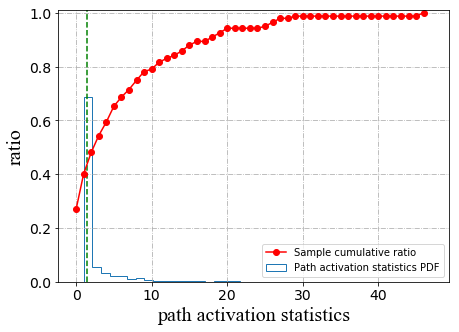

In [140]:
path_stat=np.array(v_list[0].counts)
plt.figure(figsize=(7, 5))
plt.tick_params(labelsize=14)
# for GAMMA in list(np.linspace(1,0.5,50)):
# plt.plot(range(0,len(path_stat)),path_stat,'r-.')
# plt.plot(range(0,len(path_stat)),(path_stat[0]*0.01)*np.ones(len(path_stat)),'g-.')
plt.hist(path_stat,bins=40,density=1, histtype='step',label='Path activation statistics PDF')
# plt.hist(path_stat,bins=40,density=1,cumulative=1, histtype='step',label='Cumulative Distribution Function')
plt.plot(range(0,len(cum)),cum,'ro-',label='Sample cumulative ratio')
plt.vlines(47*0.03, 0, 2, colors='g', linestyles='dashed')
plt.xlabel('path activation statistics',myfont)
plt.ylabel('ratio',myfont)
plt.ylim((0,1.01))
plt.legend(loc='lower right')
plt.grid(linestyle='-.')
plt.savefig('data/results/Figures/detection.pdf')
plt.show()

In [72]:
df=pd.DataFrame(global_results)

df

,DP,EO,DP ratio,acc,acc_ci_min,acc_ci_max,f1,acc_high_risk,acc_ci_min_high_risk,acc_ci_max_high_risk,f1_high_risk,adversarial_fraction
0,0.352826,0.675000,1.989145,0.655367,0.626784,0.683951,0.654827,0.765537,0.740056,0.791018,0.565071,0
1,0.732911,0.683333,0.183110,0.474576,0.444543,0.504609,0.471872,0.871940,0.851842,0.892037,0.578729,0
2,0.353049,0.133333,0.506194,0.730697,0.704017,0.757377,0.730275,0.870056,0.849834,0.890279,0.625827,0
3,0.346084,0.108333,0.509524,0.697740,0.670120,0.725361,0.697411,0.869115,0.848830,0.889400,0.624759,0
4,0.380530,0.108333,0.479104,0.739171,0.712763,0.765580,0.738660,0.865348,0.844818,0.885879,0.613961,0
5,0.370360,0.100000,0.487562,0.720339,0.693344,0.747334,0.719880,0.862524,0.841813,0.883234,0.607571,0
6,0.374299,0.133333,0.483226,0.729755,0.703046,0.756464,0.729311,0.868173,0.847826,0.888520,0.620404,0
7,0.378883,0.133333,0.483561,0.735405,0.708874,0.761936,0.734793,0.869115,0.848830,0.889400,0.634286,0
8,0.382555,0.183333,0.489397,0.728814,0.702075,0.755552,0.727762,0.870056,0.849834,0.890279,0.619137,0
9,0.388229,0.183333,0.477478,0.727872,0.701104,0.754639,0.727086,0.867232,0.846823,0.887640,0.605547,0


In [67]:
# census

device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/Census/adult')
df_binary, Y, S, Y_true = transform_dataset_census(df)
print(np.mean(Y))

l_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 0.5

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0, dataset='census')
ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)


# EA(net,attack_size=10, iter_num=50)

Fixate_with_val(1)

(30162, 12)
(30162, 1)
0.24892248524633645



Training neural network:  96%|█████████▌| 48/50 [01:35<00:03,  1.98s/it, epoch=47, training_loss=1.93, validation_loss=1.93]
                                                                                                                            

time costs:99.75449323654175 s


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update you

Trial name,status,loc,GAMMA,THETA
training_function_bc58c_00000,PENDING,,0.95,0.1
training_function_bc58c_00001,PENDING,,0.9,0.1
training_function_bc58c_00002,PENDING,,0.85,0.1
training_function_bc58c_00003,PENDING,,0.8,0.1
training_function_bc58c_00004,PENDING,,0.7,0.1
training_function_bc58c_00005,PENDING,,0.6,0.1
training_function_bc58c_00006,PENDING,,0.95,0.01
training_function_bc58c_00007,PENDING,,0.9,0.01
training_function_bc58c_00008,PENDING,,0.85,0.01
training_function_bc58c_00009,PENDING,,0.8,0.01


Trial name,status,loc,GAMMA,THETA
training_function_bc58c_00000,RUNNING,,0.95,0.1
training_function_bc58c_00001,PENDING,,0.9,0.1
training_function_bc58c_00002,PENDING,,0.85,0.1
training_function_bc58c_00003,PENDING,,0.8,0.1
training_function_bc58c_00004,PENDING,,0.7,0.1
training_function_bc58c_00005,PENDING,,0.6,0.1
training_function_bc58c_00006,PENDING,,0.95,0.01
training_function_bc58c_00007,PENDING,,0.9,0.01
training_function_bc58c_00008,PENDING,,0.85,0.01
training_function_bc58c_00009,PENDING,,0.8,0.01


(pid=12366) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12366)   parser = argparse.ArgumentParser(


(pid=12366) frac:0.25124584717607973


(pid=12366) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Trial name,status,loc,GAMMA,THETA
training_function_bc58c_00000,RUNNING,,0.95,0.1
training_function_bc58c_00001,PENDING,,0.9,0.1
training_function_bc58c_00002,PENDING,,0.85,0.1
training_function_bc58c_00003,PENDING,,0.8,0.1
training_function_bc58c_00004,PENDING,,0.7,0.1
training_function_bc58c_00005,PENDING,,0.6,0.1
training_function_bc58c_00006,PENDING,,0.95,0.01
training_function_bc58c_00007,PENDING,,0.9,0.01
training_function_bc58c_00008,PENDING,,0.85,0.01
training_function_bc58c_00009,PENDING,,0.8,0.01


(pid=12366) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.47it/s, epoch=27, training_loss=0.0922, validation_loss=0.153]
(pid=12366) 
                                                                                                                               


Result for training_function_bc58c_00000:
  date: 2021-08-29_11-05-57
  done: false
  experiment_id: cce2f836a0fd44039236b11a136f9a84
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.827728943075183
  neg_mean_loss: 1.827728943075183
  node_ip: 202.117.43.132
  pid: 12366
  time_since_restore: 12.34292459487915
  time_this_iter_s: 12.34292459487915
  time_total_s: 12.34292459487915
  timestamp: 1630206357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00000
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00000,RUNNING,202.117.43.132:12366,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,PENDING,,0.9,0.1,,,,
training_function_bc58c_00002,PENDING,,0.85,0.1,,,,
training_function_bc58c_00003,PENDING,,0.8,0.1,,,,
training_function_bc58c_00004,PENDING,,0.7,0.1,,,,
training_function_bc58c_00005,PENDING,,0.6,0.1,,,,
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,


Result for training_function_bc58c_00000:
  date: 2021-08-29_11-05-57
  done: true
  experiment_id: cce2f836a0fd44039236b11a136f9a84
  experiment_tag: 0_GAMMA=0.95,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.827728943075183
  neg_mean_loss: 1.827728943075183
  node_ip: 202.117.43.132
  pid: 12366
  time_since_restore: 12.34292459487915
  time_this_iter_s: 12.34292459487915
  time_total_s: 12.34292459487915
  timestamp: 1630206357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00000
  


(pid=12219) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12219)   parser = argparse.ArgumentParser(


(pid=12219) frac:0.2553986710963455


(pid=12219) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12219) 
Training neural network:  52%|█████▏    | 26/50 [00:05<00:04,  5.12it/s, epoch=25, training_loss=0.121, validation_loss=0.148]
(pid=12219) 
                                                                                                                              


Result for training_function_bc58c_00001:
  date: 2021-08-29_11-06-17
  done: false
  experiment_id: bb2ee7d62c0b435abfd8435173fe500f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.619740087123914
  neg_mean_loss: 1.619740087123914
  node_ip: 202.117.43.132
  pid: 12219
  time_since_restore: 13.373337268829346
  time_this_iter_s: 13.373337268829346
  time_total_s: 13.373337268829346
  timestamp: 1630206377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00001
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00001,RUNNING,202.117.43.132:12219,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,PENDING,,0.85,0.1,,,,
training_function_bc58c_00003,PENDING,,0.8,0.1,,,,
training_function_bc58c_00004,PENDING,,0.7,0.1,,,,
training_function_bc58c_00005,PENDING,,0.6,0.1,,,,
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,


Result for training_function_bc58c_00001:
  date: 2021-08-29_11-06-17
  done: true
  experiment_id: bb2ee7d62c0b435abfd8435173fe500f
  experiment_tag: 1_GAMMA=0.9,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.619740087123914
  neg_mean_loss: 1.619740087123914
  node_ip: 202.117.43.132
  pid: 12219
  time_since_restore: 13.373337268829346
  time_this_iter_s: 13.373337268829346
  time_total_s: 13.373337268829346
  timestamp: 1630206377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00001
  


(pid=12229) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12229)   parser = argparse.ArgumentParser(


(pid=12229) frac:0.2504152823920266


(pid=12229) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12229) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:03,  5.59it/s, epoch=27, training_loss=0.0736, validation_loss=0.164]
(pid=12229) 
                                                                                                                               


Result for training_function_bc58c_00002:
  date: 2021-08-29_11-06-36
  done: false
  experiment_id: d33699eb7e6a49de8f9b4c84b9f11ce6
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.520861701675519
  neg_mean_loss: 1.520861701675519
  node_ip: 202.117.43.132
  pid: 12229
  time_since_restore: 12.39463210105896
  time_this_iter_s: 12.39463210105896
  time_total_s: 12.39463210105896
  timestamp: 1630206396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00002
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00002,RUNNING,202.117.43.132:12229,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,PENDING,,0.8,0.1,,,,
training_function_bc58c_00004,PENDING,,0.7,0.1,,,,
training_function_bc58c_00005,PENDING,,0.6,0.1,,,,
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,


Result for training_function_bc58c_00002:
  date: 2021-08-29_11-06-36
  done: true
  experiment_id: d33699eb7e6a49de8f9b4c84b9f11ce6
  experiment_tag: 2_GAMMA=0.85,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.520861701675519
  neg_mean_loss: 1.520861701675519
  node_ip: 202.117.43.132
  pid: 12229
  time_since_restore: 12.39463210105896
  time_this_iter_s: 12.39463210105896
  time_total_s: 12.39463210105896
  timestamp: 1630206396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00002
  


(pid=12232) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12232)   parser = argparse.ArgumentParser(


(pid=12232) frac:0.2520764119601329


(pid=12232) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12232) 
Training neural network:  54%|█████▍    | 27/50 [00:05<00:04,  5.38it/s, epoch=26, training_loss=0.0865, validation_loss=0.148]
(pid=12232) 
                                                                                                                               


Result for training_function_bc58c_00003:
  date: 2021-08-29_11-06-55
  done: false
  experiment_id: 90c6e1c045e3487fbd6fcc4f4c3452d3
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.78826426160831
  neg_mean_loss: 1.78826426160831
  node_ip: 202.117.43.132
  pid: 12232
  time_since_restore: 12.724765062332153
  time_this_iter_s: 12.724765062332153
  time_total_s: 12.724765062332153
  timestamp: 1630206415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00003
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00003,RUNNING,202.117.43.132:12232,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,PENDING,,0.7,0.1,,,,
training_function_bc58c_00005,PENDING,,0.6,0.1,,,,
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,


Result for training_function_bc58c_00003:
  date: 2021-08-29_11-06-55
  done: true
  experiment_id: 90c6e1c045e3487fbd6fcc4f4c3452d3
  experiment_tag: 3_GAMMA=0.8,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.78826426160831
  neg_mean_loss: 1.78826426160831
  node_ip: 202.117.43.132
  pid: 12232
  time_since_restore: 12.724765062332153
  time_this_iter_s: 12.724765062332153
  time_total_s: 12.724765062332153
  timestamp: 1630206415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00003
  


(pid=12360) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12360)   parser = argparse.ArgumentParser(


(pid=12360) frac:0.25705980066445183


(pid=12360) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12360) 
Training neural network:  54%|█████▍    | 27/50 [00:05<00:04,  5.39it/s, epoch=26, training_loss=0.0716, validation_loss=0.153]
(pid=12360) 
                                                                                                                               


Result for training_function_bc58c_00004:
  date: 2021-08-29_11-07-14
  done: false
  experiment_id: 027a831772724364b3b8f7a50a1b0117
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.1977713019450658
  neg_mean_loss: 2.1977713019450658
  node_ip: 202.117.43.132
  pid: 12360
  time_since_restore: 12.328447341918945
  time_this_iter_s: 12.328447341918945
  time_total_s: 12.328447341918945
  timestamp: 1630206434
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00004
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00004,RUNNING,202.117.43.132:12360,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,PENDING,,0.6,0.1,,,,
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,


Result for training_function_bc58c_00004:
  date: 2021-08-29_11-07-14
  done: true
  experiment_id: 027a831772724364b3b8f7a50a1b0117
  experiment_tag: 4_GAMMA=0.7,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.1977713019450658
  neg_mean_loss: 2.1977713019450658
  node_ip: 202.117.43.132
  pid: 12360
  time_since_restore: 12.328447341918945
  time_this_iter_s: 12.328447341918945
  time_total_s: 12.328447341918945
  timestamp: 1630206434
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00004
  


(pid=12212) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12212)   parser = argparse.ArgumentParser(


(pid=12212) frac:0.25


(pid=12212) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12212) 
Training neural network:  54%|█████▍    | 27/50 [00:05<00:04,  5.38it/s, epoch=26, training_loss=0.0874, validation_loss=0.15]
(pid=12212) 
                                                                                                                              


Result for training_function_bc58c_00005:
  date: 2021-08-29_11-07-34
  done: false
  experiment_id: 59cc3d18c2ea4148b73d082d8a1ac68e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.586478065259189
  neg_mean_loss: 2.586478065259189
  node_ip: 202.117.43.132
  pid: 12212
  time_since_restore: 12.41753888130188
  time_this_iter_s: 12.41753888130188
  time_total_s: 12.41753888130188
  timestamp: 1630206454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00005
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00005,RUNNING,202.117.43.132:12212,0.6,0.1,-2.58648,1,12.4175,2.58648
training_function_bc58c_00006,PENDING,,0.95,0.01,,,,
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,


Result for training_function_bc58c_00005:
  date: 2021-08-29_11-07-34
  done: true
  experiment_id: 59cc3d18c2ea4148b73d082d8a1ac68e
  experiment_tag: 5_GAMMA=0.6,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.586478065259189
  neg_mean_loss: 2.586478065259189
  node_ip: 202.117.43.132
  pid: 12212
  time_since_restore: 12.41753888130188
  time_this_iter_s: 12.41753888130188
  time_total_s: 12.41753888130188
  timestamp: 1630206454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00005
  


(pid=12217) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12217)   parser = argparse.ArgumentParser(


(pid=12217) frac:0.04941860465116279


(pid=12217) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12217) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.66it/s, epoch=28, training_loss=0.0574, validation_loss=0.178]
(pid=12217) 
                                                                                                                               


Result for training_function_bc58c_00006:
  date: 2021-08-29_11-07-52
  done: false
  experiment_id: b99c167f6c904423b826085f6f9b4005
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.915067561143688
  neg_mean_loss: 0.915067561143688
  node_ip: 202.117.43.132
  pid: 12217
  time_since_restore: 12.105441570281982
  time_this_iter_s: 12.105441570281982
  time_total_s: 12.105441570281982
  timestamp: 1630206472
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00006
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00006,RUNNING,202.117.43.132:12217,0.95,0.01,-0.915068,1,12.1054,0.915068
training_function_bc58c_00007,PENDING,,0.9,0.01,,,,
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,
training_function_bc58c_00015,PENDING,,0.8,0.003,,,,


Result for training_function_bc58c_00006:
  date: 2021-08-29_11-07-52
  done: true
  experiment_id: b99c167f6c904423b826085f6f9b4005
  experiment_tag: 6_GAMMA=0.95,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.915067561143688
  neg_mean_loss: 0.915067561143688
  node_ip: 202.117.43.132
  pid: 12217
  time_since_restore: 12.105441570281982
  time_this_iter_s: 12.105441570281982
  time_total_s: 12.105441570281982
  timestamp: 1630206472
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00006
  


(pid=12218) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12218)   parser = argparse.ArgumentParser(


(pid=12218) frac:0.04318936877076412


(pid=12218) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12218) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.72it/s, epoch=28, training_loss=0.0863, validation_loss=0.156]
(pid=12218) 
                                                                                                                               


Result for training_function_bc58c_00007:
  date: 2021-08-29_11-08-12
  done: false
  experiment_id: 5d201420d541428a88d7ae98b4c74d57
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.3258593986407123
  neg_mean_loss: 2.3258593986407123
  node_ip: 202.117.43.132
  pid: 12218
  time_since_restore: 12.180375576019287
  time_this_iter_s: 12.180375576019287
  time_total_s: 12.180375576019287
  timestamp: 1630206492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00007
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00007,RUNNING,202.117.43.132:12218,0.9,0.01,-2.32586,1,12.1804,2.32586
training_function_bc58c_00008,PENDING,,0.85,0.01,,,,
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,
training_function_bc58c_00015,PENDING,,0.8,0.003,,,,
training_function_bc58c_00016,PENDING,,0.7,0.003,,,,


Result for training_function_bc58c_00007:
  date: 2021-08-29_11-08-12
  done: true
  experiment_id: 5d201420d541428a88d7ae98b4c74d57
  experiment_tag: 7_GAMMA=0.9,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.3258593986407123
  neg_mean_loss: 2.3258593986407123
  node_ip: 202.117.43.132
  pid: 12218
  time_since_restore: 12.180375576019287
  time_this_iter_s: 12.180375576019287
  time_total_s: 12.180375576019287
  timestamp: 1630206492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00007
  


(pid=12314) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12314)   parser = argparse.ArgumentParser(


(pid=12314) frac:0.051079734219269105


(pid=12314) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12314) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.66it/s, epoch=28, training_loss=0.0939, validation_loss=0.141]
(pid=12314) 
                                                                                                                               


Result for training_function_bc58c_00008:
  date: 2021-08-29_11-08-31
  done: false
  experiment_id: eb7426f4e4a44e8d890383b4ab3f7fcb
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1691025711853158
  neg_mean_loss: 1.1691025711853158
  node_ip: 202.117.43.132
  pid: 12314
  time_since_restore: 12.112401008605957
  time_this_iter_s: 12.112401008605957
  time_total_s: 12.112401008605957
  timestamp: 1630206511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00008
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00008,RUNNING,202.117.43.132:12314,0.85,0.01,-1.1691,1,12.1124,1.1691
training_function_bc58c_00009,PENDING,,0.8,0.01,,,,
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,
training_function_bc58c_00015,PENDING,,0.8,0.003,,,,
training_function_bc58c_00016,PENDING,,0.7,0.003,,,,
training_function_bc58c_00017,PENDING,,0.6,0.003,,,,


Result for training_function_bc58c_00008:
  date: 2021-08-29_11-08-31
  done: true
  experiment_id: eb7426f4e4a44e8d890383b4ab3f7fcb
  experiment_tag: 8_GAMMA=0.85,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1691025711853158
  neg_mean_loss: 1.1691025711853158
  node_ip: 202.117.43.132
  pid: 12314
  time_since_restore: 12.112401008605957
  time_this_iter_s: 12.112401008605957
  time_total_s: 12.112401008605957
  timestamp: 1630206511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00008
  


(pid=12213) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12213)   parser = argparse.ArgumentParser(


(pid=12213) frac:0.04443521594684385


(pid=12213) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12213) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.65it/s, epoch=28, training_loss=0.0665, validation_loss=0.154]


Result for training_function_bc58c_00009:
  date: 2021-08-29_11-08-49
  done: false
  experiment_id: b98b3731a00745e696f6f5760d1af696
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.3797503150054349
  neg_mean_loss: 1.3797503150054349
  node_ip: 202.117.43.132
  pid: 12213
  time_since_restore: 12.14830207824707
  time_this_iter_s: 12.14830207824707
  time_total_s: 12.14830207824707
  timestamp: 1630206529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00009
  


(pid=12213) 
                                                                                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00009,RUNNING,202.117.43.132:12213,0.8,0.01,-1.37975,1,12.1483,1.37975
training_function_bc58c_00010,PENDING,,0.7,0.01,,,,
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,
training_function_bc58c_00015,PENDING,,0.8,0.003,,,,
training_function_bc58c_00016,PENDING,,0.7,0.003,,,,
training_function_bc58c_00017,PENDING,,0.6,0.003,,,,
training_function_bc58c_00018,PENDING,,0.95,0.001,,,,


Result for training_function_bc58c_00009:
  date: 2021-08-29_11-08-49
  done: true
  experiment_id: b98b3731a00745e696f6f5760d1af696
  experiment_tag: 9_GAMMA=0.8,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.3797503150054349
  neg_mean_loss: 1.3797503150054349
  node_ip: 202.117.43.132
  pid: 12213
  time_since_restore: 12.14830207824707
  time_this_iter_s: 12.14830207824707
  time_total_s: 12.14830207824707
  timestamp: 1630206529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00009
  


(pid=12226) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12226)   parser = argparse.ArgumentParser(


(pid=12226) frac:0.04194352159468438


(pid=12226) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12226) 
Training neural network:  52%|█████▏    | 26/50 [00:05<00:04,  5.11it/s, epoch=25, training_loss=0.0888, validation_loss=0.141]
(pid=12226) 
                                                                                                                               


Result for training_function_bc58c_00010:
  date: 2021-08-29_11-09-09
  done: false
  experiment_id: 366263ca20524b90aa387f5c881f1491
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8689354945191604
  neg_mean_loss: 0.8689354945191604
  node_ip: 202.117.43.132
  pid: 12226
  time_since_restore: 13.093904256820679
  time_this_iter_s: 13.093904256820679
  time_total_s: 13.093904256820679
  timestamp: 1630206549
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00010
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00010,RUNNING,202.117.43.132:12226,0.7,0.01,-0.868935,1,13.0939,0.868935
training_function_bc58c_00011,PENDING,,0.6,0.01,,,,
training_function_bc58c_00012,PENDING,,0.95,0.003,,,,
training_function_bc58c_00013,PENDING,,0.9,0.003,,,,
training_function_bc58c_00014,PENDING,,0.85,0.003,,,,
training_function_bc58c_00015,PENDING,,0.8,0.003,,,,
training_function_bc58c_00016,PENDING,,0.7,0.003,,,,
training_function_bc58c_00017,PENDING,,0.6,0.003,,,,
training_function_bc58c_00018,PENDING,,0.95,0.001,,,,
training_function_bc58c_00019,PENDING,,0.9,0.001,,,,


Result for training_function_bc58c_00010:
  date: 2021-08-29_11-09-09
  done: true
  experiment_id: 366263ca20524b90aa387f5c881f1491
  experiment_tag: 10_GAMMA=0.7,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8689354945191604
  neg_mean_loss: 0.8689354945191604
  node_ip: 202.117.43.132
  pid: 12226
  time_since_restore: 13.093904256820679
  time_this_iter_s: 13.093904256820679
  time_total_s: 13.093904256820679
  timestamp: 1630206549
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00010
  


(pid=12182) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12182)   parser = argparse.ArgumentParser(


(pid=12182) frac:0.05191029900332226


(pid=12182) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12182) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.44it/s, epoch=27, training_loss=0.0631, validation_loss=0.175]
(pid=12182) 
                                                                                                                               


Result for training_function_bc58c_00011:
  date: 2021-08-29_11-09-29
  done: false
  experiment_id: 6e7db7274362465fbe058a1d26389d60
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.49835320620922
  neg_mean_loss: 2.49835320620922
  node_ip: 202.117.43.132
  pid: 12182
  time_since_restore: 12.632246255874634
  time_this_iter_s: 12.632246255874634
  time_total_s: 12.632246255874634
  timestamp: 1630206569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00011
  


(pid=12193) 
                                                                                                                               


Result for training_function_bc58c_00017:
  date: 2021-08-29_11-11-24
  done: false
  experiment_id: c0f07b3a5d0143abb2f0d10bb227927d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.7993407071426684
  neg_mean_loss: 1.7993407071426684
  node_ip: 202.117.43.132
  pid: 12193
  time_since_restore: 12.570894241333008
  time_this_iter_s: 12.570894241333008
  time_total_s: 12.570894241333008
  timestamp: 1630206684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00017
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00017,RUNNING,202.117.43.132:12193,0.6,0.003,-1.79934,1,12.5709,1.79934
training_function_bc58c_00018,PENDING,,0.95,0.001,,,,
training_function_bc58c_00019,PENDING,,0.9,0.001,,,,
training_function_bc58c_00020,PENDING,,0.85,0.001,,,,
training_function_bc58c_00021,PENDING,,0.8,0.001,,,,
training_function_bc58c_00022,PENDING,,0.7,0.001,,,,
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,


Result for training_function_bc58c_00017:
  date: 2021-08-29_11-11-24
  done: true
  experiment_id: c0f07b3a5d0143abb2f0d10bb227927d
  experiment_tag: 17_GAMMA=0.6,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.7993407071426684
  neg_mean_loss: 1.7993407071426684
  node_ip: 202.117.43.132
  pid: 12193
  time_since_restore: 12.570894241333008
  time_this_iter_s: 12.570894241333008
  time_total_s: 12.570894241333008
  timestamp: 1630206684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00017
  


(pid=12198) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12198)   parser = argparse.ArgumentParser(


(pid=12198) frac:0.011212624584717609


(pid=12198) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12198) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.65it/s, epoch=28, training_loss=0.0739, validation_loss=0.15]
(pid=12198) 
                                                                                                                              


Result for training_function_bc58c_00018:
  date: 2021-08-29_11-11-42
  done: false
  experiment_id: 829983c89c884a31b4751366963223e2
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8058732678372373
  neg_mean_loss: 1.8058732678372373
  node_ip: 202.117.43.132
  pid: 12198
  time_since_restore: 12.073204278945923
  time_this_iter_s: 12.073204278945923
  time_total_s: 12.073204278945923
  timestamp: 1630206702
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00018
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00018,RUNNING,202.117.43.132:12198,0.95,0.001,-1.80587,1,12.0732,1.80587
training_function_bc58c_00019,PENDING,,0.9,0.001,,,,
training_function_bc58c_00020,PENDING,,0.85,0.001,,,,
training_function_bc58c_00021,PENDING,,0.8,0.001,,,,
training_function_bc58c_00022,PENDING,,0.7,0.001,,,,
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,


Result for training_function_bc58c_00018:
  date: 2021-08-29_11-11-42
  done: true
  experiment_id: 829983c89c884a31b4751366963223e2
  experiment_tag: 18_GAMMA=0.95,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8058732678372373
  neg_mean_loss: 1.8058732678372373
  node_ip: 202.117.43.132
  pid: 12198
  time_since_restore: 12.073204278945923
  time_this_iter_s: 12.073204278945923
  time_total_s: 12.073204278945923
  timestamp: 1630206702
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00018
  


(pid=12184) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12184)   parser = argparse.ArgumentParser(


(pid=12184) frac:0.0070598006644518275


(pid=12184) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12184) 
Training neural network:  54%|█████▍    | 27/50 [00:05<00:04,  5.33it/s, epoch=26, training_loss=0.0702, validation_loss=0.147]
(pid=12184) 
                                                                                                                               


Result for training_function_bc58c_00019:
  date: 2021-08-29_11-12-02
  done: false
  experiment_id: cec6762c83ee43f9ba5170f13ddf6726
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9226620034302653
  neg_mean_loss: 1.9226620034302653
  node_ip: 202.117.43.132
  pid: 12184
  time_since_restore: 12.937299966812134
  time_this_iter_s: 12.937299966812134
  time_total_s: 12.937299966812134
  timestamp: 1630206722
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00019
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00019,RUNNING,202.117.43.132:12184,0.9,0.001,-1.92266,1,12.9373,1.92266
training_function_bc58c_00020,PENDING,,0.85,0.001,,,,
training_function_bc58c_00021,PENDING,,0.8,0.001,,,,
training_function_bc58c_00022,PENDING,,0.7,0.001,,,,
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,


Result for training_function_bc58c_00019:
  date: 2021-08-29_11-12-02
  done: true
  experiment_id: cec6762c83ee43f9ba5170f13ddf6726
  experiment_tag: 19_GAMMA=0.9,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9226620034302653
  neg_mean_loss: 1.9226620034302653
  node_ip: 202.117.43.132
  pid: 12184
  time_since_restore: 12.937299966812134
  time_this_iter_s: 12.937299966812134
  time_total_s: 12.937299966812134
  timestamp: 1630206722
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00019
  


(pid=12200) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12200)   parser = argparse.ArgumentParser(


(pid=12200) frac:0.009551495016611296


(pid=12200) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12200) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.44it/s, epoch=27, training_loss=0.0589, validation_loss=0.147]
(pid=12200) 
                                                                                                                               


Result for training_function_bc58c_00020:
  date: 2021-08-29_11-12-21
  done: false
  experiment_id: 80c8d9536c33469b9e4749077a3971b5
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.420511968412083
  neg_mean_loss: 1.420511968412083
  node_ip: 202.117.43.132
  pid: 12200
  time_since_restore: 12.312766790390015
  time_this_iter_s: 12.312766790390015
  time_total_s: 12.312766790390015
  timestamp: 1630206741
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00020
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00020,RUNNING,202.117.43.132:12200,0.85,0.001,-1.42051,1,12.3128,1.42051
training_function_bc58c_00021,PENDING,,0.8,0.001,,,,
training_function_bc58c_00022,PENDING,,0.7,0.001,,,,
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,


Result for training_function_bc58c_00020:
  date: 2021-08-29_11-12-21
  done: true
  experiment_id: 80c8d9536c33469b9e4749077a3971b5
  experiment_tag: 20_GAMMA=0.85,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.420511968412083
  neg_mean_loss: 1.420511968412083
  node_ip: 202.117.43.132
  pid: 12200
  time_since_restore: 12.312766790390015
  time_this_iter_s: 12.312766790390015
  time_total_s: 12.312766790390015
  timestamp: 1630206741
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00020
  


(pid=12197) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12197)   parser = argparse.ArgumentParser(


(pid=12197) frac:0.006229235880398671


(pid=12197) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12197) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.71it/s, epoch=28, training_loss=0.0604, validation_loss=0.168]
(pid=12197) 
                                                                                                                               


Result for training_function_bc58c_00021:
  date: 2021-08-29_11-12-40
  done: false
  experiment_id: 62a5353e1ade49d9a5f23da48d38d0e2
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.6972158066274091
  neg_mean_loss: 0.6972158066274091
  node_ip: 202.117.43.132
  pid: 12197
  time_since_restore: 12.00513482093811
  time_this_iter_s: 12.00513482093811
  time_total_s: 12.00513482093811
  timestamp: 1630206760
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00021
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00021,RUNNING,202.117.43.132:12197,0.8,0.001,-0.697216,1,12.0051,0.697216
training_function_bc58c_00022,PENDING,,0.7,0.001,,,,
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,


Result for training_function_bc58c_00021:
  date: 2021-08-29_11-12-40
  done: true
  experiment_id: 62a5353e1ade49d9a5f23da48d38d0e2
  experiment_tag: 21_GAMMA=0.8,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.6972158066274091
  neg_mean_loss: 0.6972158066274091
  node_ip: 202.117.43.132
  pid: 12197
  time_since_restore: 12.00513482093811
  time_this_iter_s: 12.00513482093811
  time_total_s: 12.00513482093811
  timestamp: 1630206760
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00021
  


(pid=12205) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12205)   parser = argparse.ArgumentParser(


(pid=12205) frac:0.009551495016611296


(pid=12205) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12205) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.65it/s, epoch=28, training_loss=0.0646, validation_loss=0.16]
(pid=12205) 
                                                                                                                              


Result for training_function_bc58c_00022:
  date: 2021-08-29_11-12-59
  done: false
  experiment_id: d974f844529c4fa7b4c18854acba97b4
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4677953461500715
  neg_mean_loss: 1.4677953461500715
  node_ip: 202.117.43.132
  pid: 12205
  time_since_restore: 12.307892084121704
  time_this_iter_s: 12.307892084121704
  time_total_s: 12.307892084121704
  timestamp: 1630206779
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00022
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00022,RUNNING,202.117.43.132:12205,0.7,0.001,-1.4678,1,12.3079,1.4678
training_function_bc58c_00023,PENDING,,0.6,0.001,,,,
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,


Result for training_function_bc58c_00022:
  date: 2021-08-29_11-12-59
  done: true
  experiment_id: d974f844529c4fa7b4c18854acba97b4
  experiment_tag: 22_GAMMA=0.7,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4677953461500715
  neg_mean_loss: 1.4677953461500715
  node_ip: 202.117.43.132
  pid: 12205
  time_since_restore: 12.307892084121704
  time_this_iter_s: 12.307892084121704
  time_total_s: 12.307892084121704
  timestamp: 1630206779
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00022
  


(pid=12183) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12183)   parser = argparse.ArgumentParser(


(pid=12183) frac:0.008305647840531562


(pid=12183) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12183) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.48it/s, epoch=27, training_loss=0.0688, validation_loss=0.159]
(pid=12183) 
                                                                                                                               


Result for training_function_bc58c_00023:
  date: 2021-08-29_11-13-18
  done: false
  experiment_id: 5f68e1af8a524408a16111146148140c
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1944967443436996
  neg_mean_loss: 1.1944967443436996
  node_ip: 202.117.43.132
  pid: 12183
  time_since_restore: 12.337287902832031
  time_this_iter_s: 12.337287902832031
  time_total_s: 12.337287902832031
  timestamp: 1630206798
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00023
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00023,RUNNING,202.117.43.132:12183,0.6,0.001,-1.1945,1,12.3373,1.1945
training_function_bc58c_00024,PENDING,,0.95,0.0003,,,,
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,


Result for training_function_bc58c_00023:
  date: 2021-08-29_11-13-18
  done: true
  experiment_id: 5f68e1af8a524408a16111146148140c
  experiment_tag: 23_GAMMA=0.6,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1944967443436996
  neg_mean_loss: 1.1944967443436996
  node_ip: 202.117.43.132
  pid: 12183
  time_since_restore: 12.337287902832031
  time_this_iter_s: 12.337287902832031
  time_total_s: 12.337287902832031
  timestamp: 1630206798
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00023
  


(pid=12202) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12202)   parser = argparse.ArgumentParser(


(pid=12202) frac:0.0070598006644518275


(pid=12202) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12202) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.48it/s, epoch=27, training_loss=0.0823, validation_loss=0.145]
(pid=12202) 
                                                                                                                               


Result for training_function_bc58c_00024:
  date: 2021-08-29_11-13-37
  done: false
  experiment_id: 59109d7dd53d40ee9d3659317817362f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.621885661333232
  neg_mean_loss: 1.621885661333232
  node_ip: 202.117.43.132
  pid: 12202
  time_since_restore: 12.327820062637329
  time_this_iter_s: 12.327820062637329
  time_total_s: 12.327820062637329
  timestamp: 1630206817
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00024
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00024,RUNNING,202.117.43.132:12202,0.95,0.0003,-1.62189,1,12.3278,1.62189
training_function_bc58c_00025,PENDING,,0.9,0.0003,,,,
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,


Result for training_function_bc58c_00024:
  date: 2021-08-29_11-13-37
  done: true
  experiment_id: 59109d7dd53d40ee9d3659317817362f
  experiment_tag: 24_GAMMA=0.95,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.621885661333232
  neg_mean_loss: 1.621885661333232
  node_ip: 202.117.43.132
  pid: 12202
  time_since_restore: 12.327820062637329
  time_this_iter_s: 12.327820062637329
  time_total_s: 12.327820062637329
  timestamp: 1630206817
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00024
  


(pid=12203) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12203)   parser = argparse.ArgumentParser(


(pid=12203) frac:0.008305647840531562


(pid=12203) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12203) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:03,  5.55it/s, epoch=27, training_loss=0.0553, validation_loss=0.162]
(pid=12203) 
                                                                                                                               


Result for training_function_bc58c_00025:
  date: 2021-08-29_11-13-56
  done: false
  experiment_id: 850f231a60124e0ea12e65207f52a36b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2685052203612004
  neg_mean_loss: 1.2685052203612004
  node_ip: 202.117.43.132
  pid: 12203
  time_since_restore: 12.206517457962036
  time_this_iter_s: 12.206517457962036
  time_total_s: 12.206517457962036
  timestamp: 1630206836
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00025
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00025,RUNNING,202.117.43.132:12203,0.9,0.0003,-1.26851,1,12.2065,1.26851
training_function_bc58c_00026,PENDING,,0.85,0.0003,,,,
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,


Result for training_function_bc58c_00025:
  date: 2021-08-29_11-13-56
  done: true
  experiment_id: 850f231a60124e0ea12e65207f52a36b
  experiment_tag: 25_GAMMA=0.9,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2685052203612004
  neg_mean_loss: 1.2685052203612004
  node_ip: 202.117.43.132
  pid: 12203
  time_since_restore: 12.206517457962036
  time_this_iter_s: 12.206517457962036
  time_total_s: 12.206517457962036
  timestamp: 1630206836
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00025
  


(pid=12191) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12191)   parser = argparse.ArgumentParser(


(pid=12191) frac:0.0070598006644518275


(pid=12191) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12191) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:03,  5.51it/s, epoch=27, training_loss=0.0526, validation_loss=0.164]
(pid=12191) 
                                                                                                                               


Result for training_function_bc58c_00026:
  date: 2021-08-29_11-14-15
  done: false
  experiment_id: 921619efd0fc4ac996204586d574595b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.520861701675519
  neg_mean_loss: 1.520861701675519
  node_ip: 202.117.43.132
  pid: 12191
  time_since_restore: 12.512071132659912
  time_this_iter_s: 12.512071132659912
  time_total_s: 12.512071132659912
  timestamp: 1630206855
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00026
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00026,RUNNING,202.117.43.132:12191,0.85,0.0003,-1.52086,1,12.5121,1.52086
training_function_bc58c_00027,PENDING,,0.8,0.0003,,,,
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,


Result for training_function_bc58c_00026:
  date: 2021-08-29_11-14-15
  done: true
  experiment_id: 921619efd0fc4ac996204586d574595b
  experiment_tag: 26_GAMMA=0.85,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.520861701675519
  neg_mean_loss: 1.520861701675519
  node_ip: 202.117.43.132
  pid: 12191
  time_since_restore: 12.512071132659912
  time_this_iter_s: 12.512071132659912
  time_total_s: 12.512071132659912
  timestamp: 1630206855
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00026
  


(pid=12194) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12194)   parser = argparse.ArgumentParser(


(pid=12194) frac:0.006229235880398671


(pid=12194) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12194) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.43it/s, epoch=27, training_loss=0.0653, validation_loss=0.151]
(pid=12194) 
                                                                                                                               


Result for training_function_bc58c_00027:
  date: 2021-08-29_11-14-34
  done: false
  experiment_id: 0e2a84152e0e483f9ec9adf5a3e41a45
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.6394946675621591
  neg_mean_loss: 1.6394946675621591
  node_ip: 202.117.43.132
  pid: 12194
  time_since_restore: 13.249226093292236
  time_this_iter_s: 13.249226093292236
  time_total_s: 13.249226093292236
  timestamp: 1630206874
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00027
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00027,RUNNING,202.117.43.132:12194,0.8,0.0003,-1.63949,1,13.2492,1.63949
training_function_bc58c_00028,PENDING,,0.7,0.0003,,,,
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773


Result for training_function_bc58c_00027:
  date: 2021-08-29_11-14-34
  done: true
  experiment_id: 0e2a84152e0e483f9ec9adf5a3e41a45
  experiment_tag: 27_GAMMA=0.8,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.6394946675621591
  neg_mean_loss: 1.6394946675621591
  node_ip: 202.117.43.132
  pid: 12194
  time_since_restore: 13.249226093292236
  time_this_iter_s: 13.249226093292236
  time_total_s: 13.249226093292236
  timestamp: 1630206874
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00027
  


(pid=12181) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12181)   parser = argparse.ArgumentParser(


(pid=12181) frac:0.010382059800664452


(pid=12181) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12181) 
Training neural network:  54%|█████▍    | 27/50 [00:05<00:04,  5.31it/s, epoch=26, training_loss=0.0619, validation_loss=0.163]
(pid=12181) 
                                                                                                                               


Result for training_function_bc58c_00028:
  date: 2021-08-29_11-14-53
  done: false
  experiment_id: 873830c243ac4e72af71fc7f9a499e91
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4522699070534217
  neg_mean_loss: 1.4522699070534217
  node_ip: 202.117.43.132
  pid: 12181
  time_since_restore: 12.380378246307373
  time_this_iter_s: 12.380378246307373
  time_total_s: 12.380378246307373
  timestamp: 1630206893
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00028
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00028,RUNNING,202.117.43.132:12181,0.7,0.0003,-1.45227,1,12.3804,1.45227
training_function_bc58c_00029,PENDING,,0.6,0.0003,,,,
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974


Result for training_function_bc58c_00028:
  date: 2021-08-29_11-14-53
  done: true
  experiment_id: 873830c243ac4e72af71fc7f9a499e91
  experiment_tag: 28_GAMMA=0.7,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4522699070534217
  neg_mean_loss: 1.4522699070534217
  node_ip: 202.117.43.132
  pid: 12181
  time_since_restore: 12.380378246307373
  time_this_iter_s: 12.380378246307373
  time_total_s: 12.380378246307373
  timestamp: 1630206893
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00028
  


(pid=12196) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12196)   parser = argparse.ArgumentParser(


(pid=12196) frac:0.009966777408637873


(pid=12196) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12196) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.47it/s, epoch=27, training_loss=0.0693, validation_loss=0.147]
(pid=12196) 
                                                                                                                               


Result for training_function_bc58c_00029:
  date: 2021-08-29_11-15-12
  done: false
  experiment_id: 126efdabbb004fc1a7a500460a025ad7
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4677953461500715
  neg_mean_loss: 1.4677953461500715
  node_ip: 202.117.43.132
  pid: 12196
  time_since_restore: 12.171297311782837
  time_this_iter_s: 12.171297311782837
  time_total_s: 12.171297311782837
  timestamp: 1630206912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00029
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00029,RUNNING,202.117.43.132:12196,0.6,0.0003,-1.4678,1,12.1713,1.4678
training_function_bc58c_00030,PENDING,,0.95,0.0001,,,,
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086


Result for training_function_bc58c_00029:
  date: 2021-08-29_11-15-12
  done: true
  experiment_id: 126efdabbb004fc1a7a500460a025ad7
  experiment_tag: 29_GAMMA=0.6,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4677953461500715
  neg_mean_loss: 1.4677953461500715
  node_ip: 202.117.43.132
  pid: 12196
  time_since_restore: 12.171297311782837
  time_this_iter_s: 12.171297311782837
  time_total_s: 12.171297311782837
  timestamp: 1630206912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00029
  


(pid=12195) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12195)   parser = argparse.ArgumentParser(


(pid=12195) frac:0.007890365448504983


(pid=12195) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12195) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.62it/s, epoch=28, training_loss=0.069, validation_loss=0.154]
(pid=12195) 
                                                                                                                              


Result for training_function_bc58c_00030:
  date: 2021-08-29_11-15-31
  done: false
  experiment_id: 87a02abd27ea46da8b18c45f60ff1c55
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.503368527390673
  neg_mean_loss: 2.503368527390673
  node_ip: 202.117.43.132
  pid: 12195
  time_since_restore: 12.053208112716675
  time_this_iter_s: 12.053208112716675
  time_total_s: 12.053208112716675
  timestamp: 1630206931
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00030
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00030,RUNNING,202.117.43.132:12195,0.95,0.0001,-2.50337,1,12.0532,2.50337
training_function_bc58c_00031,PENDING,,0.9,0.0001,,,,
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826


Result for training_function_bc58c_00030:
  date: 2021-08-29_11-15-31
  done: true
  experiment_id: 87a02abd27ea46da8b18c45f60ff1c55
  experiment_tag: 30_GAMMA=0.95,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.503368527390673
  neg_mean_loss: 2.503368527390673
  node_ip: 202.117.43.132
  pid: 12195
  time_since_restore: 12.053208112716675
  time_this_iter_s: 12.053208112716675
  time_total_s: 12.053208112716675
  timestamp: 1630206931
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00030
  


(pid=12192) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12192)   parser = argparse.ArgumentParser(


(pid=12192) frac:0.008305647840531562


(pid=12192) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=12192) 
Training neural network:  52%|█████▏    | 26/50 [00:05<00:04,  5.13it/s, epoch=25, training_loss=0.0695, validation_loss=0.151]
(pid=12192) 
                                                                                                                               


Result for training_function_bc58c_00031:
  date: 2021-08-29_11-15-50
  done: false
  experiment_id: e995c99e868a42c5aaad9678b09f080e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4149683274632896
  neg_mean_loss: 1.4149683274632896
  node_ip: 202.117.43.132
  pid: 12192
  time_since_restore: 12.593090534210205
  time_this_iter_s: 12.593090534210205
  time_total_s: 12.593090534210205
  timestamp: 1630206950
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00031
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00031,RUNNING,202.117.43.132:12192,0.9,0.0001,-1.41497,1,12.5931,1.41497
training_function_bc58c_00032,PENDING,,0.85,0.0001,,,,
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777


Result for training_function_bc58c_00031:
  date: 2021-08-29_11-15-50
  done: true
  experiment_id: e995c99e868a42c5aaad9678b09f080e
  experiment_tag: 31_GAMMA=0.9,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4149683274632896
  neg_mean_loss: 1.4149683274632896
  node_ip: 202.117.43.132
  pid: 12192
  time_since_restore: 12.593090534210205
  time_this_iter_s: 12.593090534210205
  time_total_s: 12.593090534210205
  timestamp: 1630206950
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00031
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=28786) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=28786)   parser = argparse.ArgumentParser(


(pid=28786) frac:0.009136212624584718


(pid=28786) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=28786) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.47it/s, epoch=27, training_loss=0.0731, validation_loss=0.156]
(pid=28786) 
                                                                                                                               


Result for training_function_bc58c_00032:
  date: 2021-08-29_11-16-09
  done: false
  experiment_id: 2777676cc5a4442fb1e07a3e9afbea2b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4348838206362784
  neg_mean_loss: 1.4348838206362784
  node_ip: 202.117.43.132
  pid: 28786
  time_since_restore: 12.223286390304565
  time_this_iter_s: 12.223286390304565
  time_total_s: 12.223286390304565
  timestamp: 1630206969
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00032
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00032,RUNNING,202.117.43.132:28786,0.85,0.0001,-1.43488,1,12.2233,1.43488
training_function_bc58c_00033,PENDING,,0.8,0.0001,,,,
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,TERMINATED,,0.6,0.1,-2.58648,1,12.4175,2.58648


Result for training_function_bc58c_00032:
  date: 2021-08-29_11-16-09
  done: true
  experiment_id: 2777676cc5a4442fb1e07a3e9afbea2b
  experiment_tag: 32_GAMMA=0.85,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4348838206362784
  neg_mean_loss: 1.4348838206362784
  node_ip: 202.117.43.132
  pid: 28786
  time_since_restore: 12.223286390304565
  time_this_iter_s: 12.223286390304565
  time_total_s: 12.223286390304565
  timestamp: 1630206969
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00032
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=29440) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=29440)   parser = argparse.ArgumentParser(


(pid=29440) frac:0.007475083056478406


(pid=29440) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=29440) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.50it/s, epoch=27, training_loss=0.0797, validation_loss=0.149]
(pid=29440) 
                                                                                                                               


Result for training_function_bc58c_00033:
  date: 2021-08-29_11-16-29
  done: false
  experiment_id: cffc9fdfe8274956bd89a6e62347d566
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9415034444752632
  neg_mean_loss: 1.9415034444752632
  node_ip: 202.117.43.132
  pid: 29440
  time_since_restore: 12.257776975631714
  time_this_iter_s: 12.257776975631714
  time_total_s: 12.257776975631714
  timestamp: 1630206989
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00033
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00033,RUNNING,202.117.43.132:29440,0.8,0.0001,-1.9415,1,12.2578,1.9415
training_function_bc58c_00034,PENDING,,0.7,0.0001,,,,
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,TERMINATED,,0.6,0.1,-2.58648,1,12.4175,2.58648
training_function_bc58c_00006,TERMINATED,,0.95,0.01,-0.915068,1,12.1054,0.915068


Result for training_function_bc58c_00033:
  date: 2021-08-29_11-16-29
  done: true
  experiment_id: cffc9fdfe8274956bd89a6e62347d566
  experiment_tag: 33_GAMMA=0.8,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9415034444752632
  neg_mean_loss: 1.9415034444752632
  node_ip: 202.117.43.132
  pid: 29440
  time_since_restore: 12.257776975631714
  time_this_iter_s: 12.257776975631714
  time_total_s: 12.257776975631714
  timestamp: 1630206989
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00033
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=30092) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=30092)   parser = argparse.ArgumentParser(


(pid=30092) frac:0.0070598006644518275


(pid=30092) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=30092) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.77it/s, epoch=28, training_loss=0.0667, validation_loss=0.153]
(pid=30092) 
                                                                                                                               


Result for training_function_bc58c_00034:
  date: 2021-08-29_11-16-48
  done: false
  experiment_id: 481158be06e0438d8d91809c65999e13
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -3.25798188141065
  neg_mean_loss: 3.25798188141065
  node_ip: 202.117.43.132
  pid: 30092
  time_since_restore: 12.063072204589844
  time_this_iter_s: 12.063072204589844
  time_total_s: 12.063072204589844
  timestamp: 1630207008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00034
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00034,RUNNING,202.117.43.132:30092,0.7,0.0001,-3.25798,1,12.0631,3.25798
training_function_bc58c_00035,PENDING,,0.6,0.0001,,,,
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,TERMINATED,,0.6,0.1,-2.58648,1,12.4175,2.58648
training_function_bc58c_00006,TERMINATED,,0.95,0.01,-0.915068,1,12.1054,0.915068
training_function_bc58c_00007,TERMINATED,,0.9,0.01,-2.32586,1,12.1804,2.32586


Result for training_function_bc58c_00034:
  date: 2021-08-29_11-16-48
  done: true
  experiment_id: 481158be06e0438d8d91809c65999e13
  experiment_tag: 34_GAMMA=0.7,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -3.25798188141065
  neg_mean_loss: 3.25798188141065
  node_ip: 202.117.43.132
  pid: 30092
  time_since_restore: 12.063072204589844
  time_this_iter_s: 12.063072204589844
  time_total_s: 12.063072204589844
  timestamp: 1630207008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00034
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=31208) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=31208)   parser = argparse.ArgumentParser(


(pid=31208) frac:0.007890365448504983


(pid=31208) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=31208) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.44it/s, epoch=27, training_loss=0.0666, validation_loss=0.17]
(pid=31208) 
                                                                                                                              


Result for training_function_bc58c_00035:
  date: 2021-08-29_11-17-07
  done: false
  experiment_id: 80dd14fb7e5a4dae959485d9295bfa79
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.2339648847129023
  neg_mean_loss: 2.2339648847129023
  node_ip: 202.117.43.132
  pid: 31208
  time_since_restore: 12.057929277420044
  time_this_iter_s: 12.057929277420044
  time_total_s: 12.057929277420044
  timestamp: 1630207027
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00035,RUNNING,202.117.43.132:31208,0.6,0.0001,-2.23396,1,12.0579,2.23396
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,TERMINATED,,0.6,0.1,-2.58648,1,12.4175,2.58648
training_function_bc58c_00006,TERMINATED,,0.95,0.01,-0.915068,1,12.1054,0.915068
training_function_bc58c_00007,TERMINATED,,0.9,0.01,-2.32586,1,12.1804,2.32586
training_function_bc58c_00008,TERMINATED,,0.85,0.01,-1.1691,1,12.1124,1.1691


Result for training_function_bc58c_00035:
  date: 2021-08-29_11-17-07
  done: true
  experiment_id: 80dd14fb7e5a4dae959485d9295bfa79
  experiment_tag: 35_GAMMA=0.6,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.2339648847129023
  neg_mean_loss: 2.2339648847129023
  node_ip: 202.117.43.132
  pid: 31208
  time_since_restore: 12.057929277420044
  time_this_iter_s: 12.057929277420044
  time_total_s: 12.057929277420044
  timestamp: 1630207027
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bc58c_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_bc58c_00000,TERMINATED,,0.95,0.1,-1.82773,1,12.3429,1.82773
training_function_bc58c_00001,TERMINATED,,0.9,0.1,-1.61974,1,13.3733,1.61974
training_function_bc58c_00002,TERMINATED,,0.85,0.1,-1.52086,1,12.3946,1.52086
training_function_bc58c_00003,TERMINATED,,0.8,0.1,-1.78826,1,12.7248,1.78826
training_function_bc58c_00004,TERMINATED,,0.7,0.1,-2.19777,1,12.3284,2.19777
training_function_bc58c_00005,TERMINATED,,0.6,0.1,-2.58648,1,12.4175,2.58648
training_function_bc58c_00006,TERMINATED,,0.95,0.01,-0.915068,1,12.1054,0.915068
training_function_bc58c_00007,TERMINATED,,0.9,0.01,-2.32586,1,12.1804,2.32586
training_function_bc58c_00008,TERMINATED,,0.85,0.01,-1.1691,1,12.1124,1.1691
training_function_bc58c_00009,TERMINATED,,0.8,0.01,-1.37975,1,12.1483,1.37975


2021-08-29 11:20:57,608	INFO tune.py:550 -- Total run time: 1027.06 seconds (797.49 seconds for the tuning loop).


Best config:  {'THETA': 0.0001, 'GAMMA': 0.7, 'dataset': 'compas', 'train_dataset_s': <torch.utils.data.dataset.Subset object at 0x7f7cb06c5278>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f7cb06c5080>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f7cb8af9278>, 'x_tensor': tensor([[0.0959, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0959, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3973, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.1370, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3151, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.1644, 0.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000]])}
2021-08-29 11:23:04,692 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha


Training neural network:  96%|█████████▌| 48/50 [01:11<00:02,  1.45s/it, epoch=47, training_loss=0.0876, validation_loss=0.116]
                                                                                                                               

param selection costs:1154.1499228477478 s
path analysis costs:25.367633819580078 s
sample separation costs:43.70445489883423 s
partial dropout training costs:74.36535143852234 s
total time costs:1297.6239266395569 s


In [111]:
# credit

device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/Census/adult')
df_binary, Y, S, Y_true = transform_dataset_census(df)
print(np.mean(Y))

l_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 0.5

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0, dataset='census')
ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)


# EA(net,attack_size=10, iter_num=50)

# Fixate_with_val(10)

(30162, 12)
(30162, 1)
0.24892248524633645



Training neural network:  96%|█████████▌| 48/50 [01:50<00:04,  2.38s/it, epoch=47, training_loss=1.02, validation_loss=0.82] 
                                                                                                                            

time costs:115.74208807945251 s


In [62]:
# credit

device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128

df=pd.read_csv('data/Credit/german_credit',sep=' ')
df_binary, Y, S, Y_true = transform_dataset_credit(df)
print(np.mean(Y))

l_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

x_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
l_train_tensor = train_dataset[:][2]
s_train_tensor = train_dataset[:][3]

global_results = []

# get the classification threshold, we use the same scale for compas so 4 instead of 0.5
ori_start=time.time()
threshold = 0.5

net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=x_tensor.shape[1],
                                    grl_lambda=0,dataset='credit')
ori_end=time.time()
ori_cost_time=ori_end-ori_start
print('time costs:{} s'.format(ori_cost_time))

result = get_metrics(results, threshold, 0)
global_results.append(result)


# EA(net,attack_size=10, iter_num=50)

Fixate_with_val(1)


Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]

(999, 20)
0      False
1       True
2       True
3       True
4       True
       ...  
994     True
995     True
996     True
997    False
998     True
Name: 67, Length: 999, dtype: bool
0.3003003003003003


time costs:3.540337085723877 s


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update you

(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update you

Trial name,status,loc,GAMMA,THETA
training_function_46e9e_00000,PENDING,,0.95,0.1
training_function_46e9e_00001,PENDING,,0.9,0.1
training_function_46e9e_00002,PENDING,,0.85,0.1
training_function_46e9e_00003,PENDING,,0.8,0.1
training_function_46e9e_00004,PENDING,,0.7,0.1
training_function_46e9e_00005,PENDING,,0.6,0.1
training_function_46e9e_00006,PENDING,,0.95,0.01
training_function_46e9e_00007,PENDING,,0.9,0.01
training_function_46e9e_00008,PENDING,,0.85,0.01
training_function_46e9e_00009,PENDING,,0.8,0.01


Trial name,status,loc,GAMMA,THETA
training_function_46e9e_00000,RUNNING,,0.95,0.1
training_function_46e9e_00001,PENDING,,0.9,0.1
training_function_46e9e_00002,PENDING,,0.85,0.1
training_function_46e9e_00003,PENDING,,0.8,0.1
training_function_46e9e_00004,PENDING,,0.7,0.1
training_function_46e9e_00005,PENDING,,0.6,0.1
training_function_46e9e_00006,PENDING,,0.95,0.01
training_function_46e9e_00007,PENDING,,0.9,0.01
training_function_46e9e_00008,PENDING,,0.85,0.01
training_function_46e9e_00009,PENDING,,0.8,0.01


(pid=11539) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11539)   parser = argparse.ArgumentParser(
(pid=11539) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11539) frac:0.2916666666666667
Result for training_function_46e9e_00000:
  date: 2021-08-29_10-39-14
  done: false
  experiment_id: e4df24331500447b91307b75d251ad69
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.4771428571428573
  neg_mean_loss: -2.4771428571428573
  node_ip: 202.117.43.132
  pid: 11539
  time_since_restore: 1.0780284404754639
  time_this_iter_s: 1.0780284404754639
  time_total_s: 1.0780284404754639
  timestamp: 1630204754
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00000
  
Result for training_function_46e9e_00000:
  date: 2021-08-29_10-39-14
  done: true
  experiment_id: e4df24331500447b91307b75d251ad69
  experiment_tag: 0_GAMMA=0.95,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.4771428571428573
  neg_mean_loss: -2.4771428571428573
  node_ip: 202.117.43.132
  pid: 11539
  time_since_restore: 1.0780284404754639
  time_this_iter_s: 1.0780284404754639
  time_total_s: 1.0780284404754639
  timestamp:

(pid=11539) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00001,RUNNING,,0.9,0.1,,,,
training_function_46e9e_00002,PENDING,,0.85,0.1,,,,
training_function_46e9e_00003,PENDING,,0.8,0.1,,,,
training_function_46e9e_00004,PENDING,,0.7,0.1,,,,
training_function_46e9e_00005,PENDING,,0.6,0.1,,,,
training_function_46e9e_00006,PENDING,,0.95,0.01,,,,
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,


(pid=11500) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11500)   parser = argparse.ArgumentParser(
(pid=11500) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11500) frac:0.2638888888888889


(pid=11500) 
                                                               


Result for training_function_46e9e_00001:
  date: 2021-08-29_10-39-22
  done: false
  experiment_id: a1e48d1c03d7446aa1c24e1c570b3752
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11500
  time_since_restore: 1.0564053058624268
  time_this_iter_s: 1.0564053058624268
  time_total_s: 1.0564053058624268
  timestamp: 1630204762
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00001
  
Result for training_function_46e9e_00001:
  date: 2021-08-29_10-39-22
  done: true
  experiment_id: a1e48d1c03d7446aa1c24e1c570b3752
  experiment_tag: 1_GAMMA=0.9,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11500
  time_since_restore: 1.0564053058624268
  time_this_iter_s: 1.0564053058624268
  time_total_s: 1.0564053058624268
  timestamp: 1630204762
  timesteps_since_restore

(pid=11513) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11513)   parser = argparse.ArgumentParser(
(pid=11513) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11513) frac:0.2638888888888889
Result for training_function_46e9e_00002:
  date: 2021-08-29_10-39-29
  done: false
  experiment_id: da2f79f18b4546b395a67b007825470d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11513
  time_since_restore: 1.0471150875091553
  time_this_iter_s: 1.0471150875091553
  time_total_s: 1.0471150875091553
  timestamp: 1630204769
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00002
  


(pid=11513) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00002,RUNNING,202.117.43.132:11513,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,PENDING,,0.8,0.1,,,,
training_function_46e9e_00004,PENDING,,0.7,0.1,,,,
training_function_46e9e_00005,PENDING,,0.6,0.1,,,,
training_function_46e9e_00006,PENDING,,0.95,0.01,,,,
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,


Result for training_function_46e9e_00002:
  date: 2021-08-29_10-39-29
  done: true
  experiment_id: da2f79f18b4546b395a67b007825470d
  experiment_tag: 2_GAMMA=0.85,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11513
  time_since_restore: 1.0471150875091553
  time_this_iter_s: 1.0471150875091553
  time_total_s: 1.0471150875091553
  timestamp: 1630204769
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00002
  


(pid=11502) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11502)   parser = argparse.ArgumentParser(
(pid=11502) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11502) frac:0.2638888888888889
Result for training_function_46e9e_00003:
  date: 2021-08-29_10-39-36
  done: false
  experiment_id: 7e6f29881e644685b767ebe129f1b3e5
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11502
  time_since_restore: 1.1002981662750244
  time_this_iter_s: 1.1002981662750244
  time_total_s: 1.1002981662750244
  timestamp: 1630204776
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00003
  


(pid=11502) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00003,RUNNING,202.117.43.132:11502,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,PENDING,,0.7,0.1,,,,
training_function_46e9e_00005,PENDING,,0.6,0.1,,,,
training_function_46e9e_00006,PENDING,,0.95,0.01,,,,
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,


Result for training_function_46e9e_00003:
  date: 2021-08-29_10-39-36
  done: true
  experiment_id: 7e6f29881e644685b767ebe129f1b3e5
  experiment_tag: 3_GAMMA=0.8,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11502
  time_since_restore: 1.1002981662750244
  time_this_iter_s: 1.1002981662750244
  time_total_s: 1.1002981662750244
  timestamp: 1630204776
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00003
  


(pid=11515) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11515)   parser = argparse.ArgumentParser(
(pid=11515) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11515) frac:0.3194444444444444
Result for training_function_46e9e_00004:
  date: 2021-08-29_10-39-44
  done: false
  experiment_id: 37162bbf33ca4c6e8a3eb3869a41227c
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11515
  time_since_restore: 1.0820708274841309
  time_this_iter_s: 1.0820708274841309
  time_total_s: 1.0820708274841309
  timestamp: 1630204784
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00004
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00004,RUNNING,202.117.43.132:11515,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,PENDING,,0.6,0.1,,,,
training_function_46e9e_00006,PENDING,,0.95,0.01,,,,
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,


Result for training_function_46e9e_00004:
  date: 2021-08-29_10-39-44
  done: true
  experiment_id: 37162bbf33ca4c6e8a3eb3869a41227c
  experiment_tag: 4_GAMMA=0.7,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11515
  time_since_restore: 1.0820708274841309
  time_this_iter_s: 1.0820708274841309
  time_total_s: 1.0820708274841309
  timestamp: 1630204784
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00004
  


(pid=11515) 
                                                               
(pid=11532) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11532)   parser = argparse.ArgumentParser(


(pid=11532) frac:0.3055555555555556


(pid=11532) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_46e9e_00005:
  date: 2021-08-29_10-39-52
  done: false
  experiment_id: dc5d8bd297284d8bb6bbb139c19974eb
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11532
  time_since_restore: 1.0255143642425537
  time_this_iter_s: 1.0255143642425537
  time_total_s: 1.0255143642425537
  timestamp: 1630204792
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00005
  


(pid=11532) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00005,RUNNING,202.117.43.132:11532,0.6,0.1,1.30806,1,1.02551,-1.30806
training_function_46e9e_00006,PENDING,,0.95,0.01,,,,
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,


Result for training_function_46e9e_00005:
  date: 2021-08-29_10-39-52
  done: true
  experiment_id: dc5d8bd297284d8bb6bbb139c19974eb
  experiment_tag: 5_GAMMA=0.6,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11532
  time_since_restore: 1.0255143642425537
  time_this_iter_s: 1.0255143642425537
  time_total_s: 1.0255143642425537
  timestamp: 1630204792
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00005
  


(pid=11481) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11481)   parser = argparse.ArgumentParser(
(pid=11481) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11481) frac:0.3055555555555556
Result for training_function_46e9e_00006:
  date: 2021-08-29_10-39-59
  done: false
  experiment_id: dfd3fb63325a4d61a5f91afcf5b79697
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4498015873015873
  neg_mean_loss: -1.4498015873015873
  node_ip: 202.117.43.132
  pid: 11481
  time_since_restore: 1.070948600769043
  time_this_iter_s: 1.070948600769043
  time_total_s: 1.070948600769043
  timestamp: 1630204799
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00006
  


(pid=11481) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00006,RUNNING,202.117.43.132:11481,0.95,0.01,1.4498,1,1.07095,-1.4498
training_function_46e9e_00007,PENDING,,0.9,0.01,,,,
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,


Result for training_function_46e9e_00006:
  date: 2021-08-29_10-39-59
  done: true
  experiment_id: dfd3fb63325a4d61a5f91afcf5b79697
  experiment_tag: 6_GAMMA=0.95,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4498015873015873
  neg_mean_loss: -1.4498015873015873
  node_ip: 202.117.43.132
  pid: 11481
  time_since_restore: 1.070948600769043
  time_this_iter_s: 1.070948600769043
  time_total_s: 1.070948600769043
  timestamp: 1630204799
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00006
  


(pid=11542) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11542)   parser = argparse.ArgumentParser(
(pid=11542) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11542) frac:0.2361111111111111
Result for training_function_46e9e_00007:
  date: 2021-08-29_10-40-07
  done: false
  experiment_id: 57d8085d80574be8a5517c222bd815e9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11542
  time_since_restore: 1.0544869899749756
  time_this_iter_s: 1.0544869899749756
  time_total_s: 1.0544869899749756
  timestamp: 1630204807
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00007
  


(pid=11542) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00007,RUNNING,202.117.43.132:11542,0.9,0.01,1.21766,1,1.05449,-1.21766
training_function_46e9e_00008,PENDING,,0.85,0.01,,,,
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,


Result for training_function_46e9e_00007:
  date: 2021-08-29_10-40-07
  done: true
  experiment_id: 57d8085d80574be8a5517c222bd815e9
  experiment_tag: 7_GAMMA=0.9,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11542
  time_since_restore: 1.0544869899749756
  time_this_iter_s: 1.0544869899749756
  time_total_s: 1.0544869899749756
  timestamp: 1630204807
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00007
  


(pid=11553) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11553)   parser = argparse.ArgumentParser(
(pid=11553) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11553) frac:0.2638888888888889
Result for training_function_46e9e_00008:
  date: 2021-08-29_10-40-14
  done: false
  experiment_id: b36a4fd412654ad4bb14b80224ab4a76
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.6015873015873017
  neg_mean_loss: -2.6015873015873017
  node_ip: 202.117.43.132
  pid: 11553
  time_since_restore: 0.9860763549804688
  time_this_iter_s: 0.9860763549804688
  time_total_s: 0.9860763549804688
  timestamp: 1630204814
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00008
  


(pid=11553) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00008,RUNNING,202.117.43.132:11553,0.85,0.01,2.60159,1,0.986076,-2.60159
training_function_46e9e_00009,PENDING,,0.8,0.01,,,,
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,


Result for training_function_46e9e_00008:
  date: 2021-08-29_10-40-14
  done: true
  experiment_id: b36a4fd412654ad4bb14b80224ab4a76
  experiment_tag: 8_GAMMA=0.85,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.6015873015873017
  neg_mean_loss: -2.6015873015873017
  node_ip: 202.117.43.132
  pid: 11553
  time_since_restore: 0.9860763549804688
  time_this_iter_s: 0.9860763549804688
  time_total_s: 0.9860763549804688
  timestamp: 1630204814
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00008
  


(pid=11503) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11503)   parser = argparse.ArgumentParser(
(pid=11503) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11503) frac:0.3333333333333333
Result for training_function_46e9e_00009:
  date: 2021-08-29_10-40-22
  done: false
  experiment_id: 75163b7e75d7449dadb0ca382ff5b693
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11503
  time_since_restore: 1.0159943103790283
  time_this_iter_s: 1.0159943103790283
  time_total_s: 1.0159943103790283
  timestamp: 1630204822
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00009
  


(pid=11503) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00009,RUNNING,202.117.43.132:11503,0.8,0.01,1.495,1,1.01599,-1.495
training_function_46e9e_00010,PENDING,,0.7,0.01,,,,
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,


Result for training_function_46e9e_00009:
  date: 2021-08-29_10-40-22
  done: true
  experiment_id: 75163b7e75d7449dadb0ca382ff5b693
  experiment_tag: 9_GAMMA=0.8,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11503
  time_since_restore: 1.0159943103790283
  time_this_iter_s: 1.0159943103790283
  time_total_s: 1.0159943103790283
  timestamp: 1630204822
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00009
  


(pid=11518) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11518)   parser = argparse.ArgumentParser(
(pid=11518) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11518) frac:0.2638888888888889
Result for training_function_46e9e_00010:
  date: 2021-08-29_10-40-29
  done: false
  experiment_id: 4ca60f05748a4efca03a9cb5d1f6dcba
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.262857142857143
  neg_mean_loss: -1.262857142857143
  node_ip: 202.117.43.132
  pid: 11518
  time_since_restore: 0.9923648834228516
  time_this_iter_s: 0.9923648834228516
  time_total_s: 0.9923648834228516
  timestamp: 1630204829
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00010
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00010,RUNNING,202.117.43.132:11518,0.7,0.01,1.26286,1,0.992365,-1.26286
training_function_46e9e_00011,PENDING,,0.6,0.01,,,,
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,


Result for training_function_46e9e_00010:
  date: 2021-08-29_10-40-29
  done: true
  experiment_id: 4ca60f05748a4efca03a9cb5d1f6dcba
  experiment_tag: 10_GAMMA=0.7,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.262857142857143
  neg_mean_loss: -1.262857142857143
  node_ip: 202.117.43.132
  pid: 11518
  time_since_restore: 0.9923648834228516
  time_this_iter_s: 0.9923648834228516
  time_total_s: 0.9923648834228516
  timestamp: 1630204829
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00010
  


(pid=11518) 
                                                               
(pid=11514) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11514)   parser = argparse.ArgumentParser(


(pid=11514) frac:0.3055555555555556


(pid=11514) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=11514) 
                                                               


Result for training_function_46e9e_00011:
  date: 2021-08-29_10-40-37
  done: false
  experiment_id: f6ce1c20410c4b3eb14cc94ad433cd5c
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11514
  time_since_restore: 0.9972050189971924
  time_this_iter_s: 0.9972050189971924
  time_total_s: 0.9972050189971924
  timestamp: 1630204837
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00011
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00011,RUNNING,202.117.43.132:11514,0.6,0.01,1.30806,1,0.997205,-1.30806
training_function_46e9e_00012,PENDING,,0.95,0.003,,,,
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,


Result for training_function_46e9e_00011:
  date: 2021-08-29_10-40-37
  done: true
  experiment_id: f6ce1c20410c4b3eb14cc94ad433cd5c
  experiment_tag: 11_GAMMA=0.6,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11514
  time_since_restore: 0.9972050189971924
  time_this_iter_s: 0.9972050189971924
  time_total_s: 0.9972050189971924
  timestamp: 1630204837
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00011
  


(pid=11501) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11501)   parser = argparse.ArgumentParser(
(pid=11501) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11501) frac:0.2916666666666667
Result for training_function_46e9e_00012:
  date: 2021-08-29_10-40-45
  done: false
  experiment_id: 345c4f222b754fe38b62fec8c85688ef
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8889682539682539
  neg_mean_loss: -0.8889682539682539
  node_ip: 202.117.43.132
  pid: 11501
  time_since_restore: 1.0664823055267334
  time_this_iter_s: 1.0664823055267334
  time_total_s: 1.0664823055267334
  timestamp: 1630204845
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00012
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00012,RUNNING,202.117.43.132:11501,0.95,0.003,0.888968,1,1.06648,-0.888968
training_function_46e9e_00013,PENDING,,0.9,0.003,,,,
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,


Result for training_function_46e9e_00012:
  date: 2021-08-29_10-40-45
  done: true
  experiment_id: 345c4f222b754fe38b62fec8c85688ef
  experiment_tag: 12_GAMMA=0.95,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.8889682539682539
  neg_mean_loss: -0.8889682539682539
  node_ip: 202.117.43.132
  pid: 11501
  time_since_restore: 1.0664823055267334
  time_this_iter_s: 1.0664823055267334
  time_total_s: 1.0664823055267334
  timestamp: 1630204845
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00012
  


(pid=11501) 
                                                               
(pid=11506) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11506)   parser = argparse.ArgumentParser(
(pid=11506) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11506) frac:0.2777777777777778


(pid=11506) 
                                                               


Result for training_function_46e9e_00013:
  date: 2021-08-29_10-40-52
  done: false
  experiment_id: 87c134c266034721ac4977b5234ee58a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11506
  time_since_restore: 1.1047651767730713
  time_this_iter_s: 1.1047651767730713
  time_total_s: 1.1047651767730713
  timestamp: 1630204852
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00013
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00013,RUNNING,202.117.43.132:11506,0.9,0.003,1.495,1,1.10477,-1.495
training_function_46e9e_00014,PENDING,,0.85,0.003,,,,
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,


Result for training_function_46e9e_00013:
  date: 2021-08-29_10-40-52
  done: true
  experiment_id: 87c134c266034721ac4977b5234ee58a
  experiment_tag: 13_GAMMA=0.9,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11506
  time_since_restore: 1.1047651767730713
  time_this_iter_s: 1.1047651767730713
  time_total_s: 1.1047651767730713
  timestamp: 1630204852
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00013
  


(pid=11520) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11520)   parser = argparse.ArgumentParser(
(pid=11520) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11520) frac:0.2638888888888889
Result for training_function_46e9e_00014:
  date: 2021-08-29_10-41-00
  done: false
  experiment_id: 7cdc28a8f82c4535a4e96ce56324fa37
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -.inf
  neg_mean_loss: .inf
  node_ip: 202.117.43.132
  pid: 11520
  time_since_restore: 1.0449018478393555
  time_this_iter_s: 1.0449018478393555
  time_total_s: 1.0449018478393555
  timestamp: 1630204860
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00014
  
2021-08-29 10:41:00,376 - root - WARNING - NaN or Inf found in input tensor.
2021-08-29 10:41:00,378 - root - WARNING - NaN or Inf found in input tensor.


(pid=11520) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00014,RUNNING,202.117.43.132:11520,0.85,0.003,-inf,1,1.0449,inf
training_function_46e9e_00015,PENDING,,0.8,0.003,,,,
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,


(pid=11520) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11520)   parser = argparse.ArgumentParser(


Result for training_function_46e9e_00014:
  date: 2021-08-29_10-41-00
  done: true
  experiment_id: 7cdc28a8f82c4535a4e96ce56324fa37
  experiment_tag: 14_GAMMA=0.85,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -.inf
  neg_mean_loss: .inf
  node_ip: 202.117.43.132
  pid: 11520
  time_since_restore: 1.0449018478393555
  time_this_iter_s: 1.0449018478393555
  time_total_s: 1.0449018478393555
  timestamp: 1630204860
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00014
  


(pid=11490) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11490)   parser = argparse.ArgumentParser(
(pid=11490) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11490) frac:0.3055555555555556


(pid=11490) 
                                                               


Result for training_function_46e9e_00015:
  date: 2021-08-29_10-41-07
  done: false
  experiment_id: 1f9319a0964b458bbdf8f54dd94042bd
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11490
  time_since_restore: 0.9733438491821289
  time_this_iter_s: 0.9733438491821289
  time_total_s: 0.9733438491821289
  timestamp: 1630204867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00015
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00015,RUNNING,202.117.43.132:11490,0.8,0.003,1.495,1,0.973344,-1.495
training_function_46e9e_00016,PENDING,,0.7,0.003,,,,
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,


Result for training_function_46e9e_00015:
  date: 2021-08-29_10-41-07
  done: true
  experiment_id: 1f9319a0964b458bbdf8f54dd94042bd
  experiment_tag: 15_GAMMA=0.8,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.495
  neg_mean_loss: -1.495
  node_ip: 202.117.43.132
  pid: 11490
  time_since_restore: 0.9733438491821289
  time_this_iter_s: 0.9733438491821289
  time_total_s: 0.9733438491821289
  timestamp: 1630204867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00015
  


(pid=11508) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11508)   parser = argparse.ArgumentParser(
(pid=11508) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11508) frac:0.2777777777777778
Result for training_function_46e9e_00016:
  date: 2021-08-29_10-41-15
  done: false
  experiment_id: c9b698c36d744efead364ec35d28abfc
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11508
  time_since_restore: 0.9989721775054932
  time_this_iter_s: 0.9989721775054932
  time_total_s: 0.9989721775054932
  timestamp: 1630204875
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00016
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00016,RUNNING,202.117.43.132:11508,0.7,0.003,1.30806,1,0.998972,-1.30806
training_function_46e9e_00017,PENDING,,0.6,0.003,,,,
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,


Result for training_function_46e9e_00016:
  date: 2021-08-29_10-41-15
  done: true
  experiment_id: c9b698c36d744efead364ec35d28abfc
  experiment_tag: 16_GAMMA=0.7,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11508
  time_since_restore: 0.9989721775054932
  time_this_iter_s: 0.9989721775054932
  time_total_s: 0.9989721775054932
  timestamp: 1630204875
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00016
  


(pid=11508) 
                                                               
(pid=11547) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11547)   parser = argparse.ArgumentParser(
(pid=11547) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11547) frac:0.20833333333333334


(pid=11547) 
                                                               


Result for training_function_46e9e_00017:
  date: 2021-08-29_10-41-22
  done: false
  experiment_id: 6e2c33809f664f5bb8a9feb3871a4dd6
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.9944444444444445
  neg_mean_loss: -2.9944444444444445
  node_ip: 202.117.43.132
  pid: 11547
  time_since_restore: 0.9607460498809814
  time_this_iter_s: 0.9607460498809814
  time_total_s: 0.9607460498809814
  timestamp: 1630204882
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00017
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00017,RUNNING,202.117.43.132:11547,0.6,0.003,2.99444,1,0.960746,-2.99444
training_function_46e9e_00018,PENDING,,0.95,0.001,,,,
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,


Result for training_function_46e9e_00017:
  date: 2021-08-29_10-41-22
  done: true
  experiment_id: 6e2c33809f664f5bb8a9feb3871a4dd6
  experiment_tag: 17_GAMMA=0.6,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.9944444444444445
  neg_mean_loss: -2.9944444444444445
  node_ip: 202.117.43.132
  pid: 11547
  time_since_restore: 0.9607460498809814
  time_this_iter_s: 0.9607460498809814
  time_total_s: 0.9607460498809814
  timestamp: 1630204882
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00017
  


(pid=11484) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11484)   parser = argparse.ArgumentParser(
(pid=11484) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11484) frac:0.25
Result for training_function_46e9e_00018:
  date: 2021-08-29_10-41-30
  done: false
  experiment_id: 22485ff0c6bf4179a943ada6ed479ebd
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11484
  time_since_restore: 0.9559061527252197
  time_this_iter_s: 0.9559061527252197
  time_total_s: 0.9559061527252197
  timestamp: 1630204890
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00018
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00018,RUNNING,202.117.43.132:11484,0.95,0.001,1.30806,1,0.955906,-1.30806
training_function_46e9e_00019,PENDING,,0.9,0.001,,,,
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,


Result for training_function_46e9e_00018:
  date: 2021-08-29_10-41-30
  done: true
  experiment_id: 22485ff0c6bf4179a943ada6ed479ebd
  experiment_tag: 18_GAMMA=0.95,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11484
  time_since_restore: 0.9559061527252197
  time_this_iter_s: 0.9559061527252197
  time_total_s: 0.9559061527252197
  timestamp: 1630204890
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00018
  


(pid=11484) 
                                                               
(pid=11530) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11530)   parser = argparse.ArgumentParser(
(pid=11530) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11530) frac:0.25
Result for training_function_46e9e_00019:
  date: 2021-08-29_10-41-37
  done: false
  experiment_id: 9c8e87af40e04545bdae50ea210f304a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11530
  time_since_restore: 1.0176007747650146
  time_this_iter_s: 1.0176007747650146
  time_total_s: 1.0176007747650146
  timestamp: 1630204897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00019
  


(pid=11530) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00019,RUNNING,202.117.43.132:11530,0.9,0.001,1.30806,1,1.0176,-1.30806
training_function_46e9e_00020,PENDING,,0.85,0.001,,,,
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,


Result for training_function_46e9e_00019:
  date: 2021-08-29_10-41-37
  done: true
  experiment_id: 9c8e87af40e04545bdae50ea210f304a
  experiment_tag: 19_GAMMA=0.9,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11530
  time_since_restore: 1.0176007747650146
  time_this_iter_s: 1.0176007747650146
  time_total_s: 1.0176007747650146
  timestamp: 1630204897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00019
  


(pid=11486) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11486)   parser = argparse.ArgumentParser(
(pid=11486) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11486) frac:0.2638888888888889
Result for training_function_46e9e_00020:
  date: 2021-08-29_10-41-45
  done: false
  experiment_id: 99c8bb41005741459706e70500fec466
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.87
  neg_mean_loss: -2.87
  node_ip: 202.117.43.132
  pid: 11486
  time_since_restore: 1.0158233642578125
  time_this_iter_s: 1.0158233642578125
  time_total_s: 1.0158233642578125
  timestamp: 1630204905
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00020
  


(pid=11486) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00020,RUNNING,202.117.43.132:11486,0.85,0.001,2.87,1,1.01582,-2.87
training_function_46e9e_00021,PENDING,,0.8,0.001,,,,
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,


Result for training_function_46e9e_00020:
  date: 2021-08-29_10-41-45
  done: true
  experiment_id: 99c8bb41005741459706e70500fec466
  experiment_tag: 20_GAMMA=0.85,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.87
  neg_mean_loss: -2.87
  node_ip: 202.117.43.132
  pid: 11486
  time_since_restore: 1.0158233642578125
  time_this_iter_s: 1.0158233642578125
  time_total_s: 1.0158233642578125
  timestamp: 1630204905
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00020
  


(pid=11483) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11483)   parser = argparse.ArgumentParser(
(pid=11483) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11483) frac:0.2777777777777778
Result for training_function_46e9e_00021:
  date: 2021-08-29_10-41-52
  done: false
  experiment_id: a3c3edb77eec4e5c8a5c2b28410b9d7f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.262857142857143
  neg_mean_loss: -1.262857142857143
  node_ip: 202.117.43.132
  pid: 11483
  time_since_restore: 0.9846489429473877
  time_this_iter_s: 0.9846489429473877
  time_total_s: 0.9846489429473877
  timestamp: 1630204912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00021
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00021,RUNNING,202.117.43.132:11483,0.8,0.001,1.26286,1,0.984649,-1.26286
training_function_46e9e_00022,PENDING,,0.7,0.001,,,,
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,


Result for training_function_46e9e_00021:
  date: 2021-08-29_10-41-52
  done: true
  experiment_id: a3c3edb77eec4e5c8a5c2b28410b9d7f
  experiment_tag: 21_GAMMA=0.8,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.262857142857143
  neg_mean_loss: -1.262857142857143
  node_ip: 202.117.43.132
  pid: 11483
  time_since_restore: 0.9846489429473877
  time_this_iter_s: 0.9846489429473877
  time_total_s: 0.9846489429473877
  timestamp: 1630204912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00021
  


(pid=11483) 
                                                               
(pid=11487) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11487)   parser = argparse.ArgumentParser(
(pid=11487) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11487) frac:0.2777777777777778


(pid=11487) 
                                                               


Result for training_function_46e9e_00022:
  date: 2021-08-29_10-41-59
  done: false
  experiment_id: 5aceab49f3a24873a78517c170733b44
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11487
  time_since_restore: 0.972684383392334
  time_this_iter_s: 0.972684383392334
  time_total_s: 0.972684383392334
  timestamp: 1630204919
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00022
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00022,RUNNING,202.117.43.132:11487,0.7,0.001,1.30806,1,0.972684,-1.30806
training_function_46e9e_00023,PENDING,,0.6,0.001,,,,
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,


Result for training_function_46e9e_00022:
  date: 2021-08-29_10-41-59
  done: true
  experiment_id: 5aceab49f3a24873a78517c170733b44
  experiment_tag: 22_GAMMA=0.7,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11487
  time_since_restore: 0.972684383392334
  time_this_iter_s: 0.972684383392334
  time_total_s: 0.972684383392334
  timestamp: 1630204919
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00022
  


(pid=11504) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11504)   parser = argparse.ArgumentParser(
(pid=11504) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11504) frac:0.3333333333333333
Result for training_function_46e9e_00023:
  date: 2021-08-29_10-42-07
  done: false
  experiment_id: 20ce8cca46d74c9395d8b431daee2085
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11504
  time_since_restore: 0.9771158695220947
  time_this_iter_s: 0.9771158695220947
  time_total_s: 0.9771158695220947
  timestamp: 1630204927
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00023
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00023,RUNNING,202.117.43.132:11504,0.6,0.001,1.12111,1,0.977116,-1.12111
training_function_46e9e_00024,PENDING,,0.95,0.0003,,,,
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,


Result for training_function_46e9e_00023:
  date: 2021-08-29_10-42-07
  done: true
  experiment_id: 20ce8cca46d74c9395d8b431daee2085
  experiment_tag: 23_GAMMA=0.6,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11504
  time_since_restore: 0.9771158695220947
  time_this_iter_s: 0.9771158695220947
  time_total_s: 0.9771158695220947
  timestamp: 1630204927
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00023
  


(pid=11504) 
                                                               
(pid=11482) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11482)   parser = argparse.ArgumentParser(


(pid=11482) frac:0.2222222222222222


(pid=11482) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_46e9e_00024:
  date: 2021-08-29_10-42-14
  done: false
  experiment_id: e7ea3c1283204d68a25fe575fed46aa3
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11482
  time_since_restore: 1.0400478839874268
  time_this_iter_s: 1.0400478839874268
  time_total_s: 1.0400478839874268
  timestamp: 1630204934
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00024
  


(pid=11482) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00024,RUNNING,202.117.43.132:11482,0.95,0.0003,1.30806,1,1.04005,-1.30806
training_function_46e9e_00025,PENDING,,0.9,0.0003,,,,
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,


Result for training_function_46e9e_00024:
  date: 2021-08-29_10-42-14
  done: true
  experiment_id: e7ea3c1283204d68a25fe575fed46aa3
  experiment_tag: 24_GAMMA=0.95,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11482
  time_since_restore: 1.0400478839874268
  time_this_iter_s: 1.0400478839874268
  time_total_s: 1.0400478839874268
  timestamp: 1630204934
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00024
  


(pid=11499) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11499)   parser = argparse.ArgumentParser(
(pid=11499) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11499) frac:0.2638888888888889
Result for training_function_46e9e_00025:
  date: 2021-08-29_10-42-21
  done: false
  experiment_id: 8a5253bafdb44e5ca9d8b7f0f3aefdc8
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4046031746031744
  neg_mean_loss: -1.4046031746031744
  node_ip: 202.117.43.132
  pid: 11499
  time_since_restore: 1.0701570510864258
  time_this_iter_s: 1.0701570510864258
  time_total_s: 1.0701570510864258
  timestamp: 1630204941
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00025
  


(pid=11499) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00025,RUNNING,202.117.43.132:11499,0.9,0.0003,1.4046,1,1.07016,-1.4046
training_function_46e9e_00026,PENDING,,0.85,0.0003,,,,
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,


Result for training_function_46e9e_00025:
  date: 2021-08-29_10-42-21
  done: true
  experiment_id: 8a5253bafdb44e5ca9d8b7f0f3aefdc8
  experiment_tag: 25_GAMMA=0.9,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.4046031746031744
  neg_mean_loss: -1.4046031746031744
  node_ip: 202.117.43.132
  pid: 11499
  time_since_restore: 1.0701570510864258
  time_this_iter_s: 1.0701570510864258
  time_total_s: 1.0701570510864258
  timestamp: 1630204941
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00025
  


(pid=11498) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11498)   parser = argparse.ArgumentParser(
(pid=11498) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11498) frac:0.2777777777777778
Result for training_function_46e9e_00026:
  date: 2021-08-29_10-42-29
  done: false
  experiment_id: 5b071c70b5b148f88d47a8ae60735614
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11498
  time_since_restore: 0.9798531532287598
  time_this_iter_s: 0.9798531532287598
  time_total_s: 0.9798531532287598
  timestamp: 1630204949
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00026
  


(pid=11498) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00026,RUNNING,202.117.43.132:11498,0.85,0.0003,1.30806,1,0.979853,-1.30806
training_function_46e9e_00027,PENDING,,0.8,0.0003,,,,
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,


Result for training_function_46e9e_00026:
  date: 2021-08-29_10-42-29
  done: true
  experiment_id: 5b071c70b5b148f88d47a8ae60735614
  experiment_tag: 26_GAMMA=0.85,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11498
  time_since_restore: 0.9798531532287598
  time_this_iter_s: 0.9798531532287598
  time_total_s: 0.9798531532287598
  timestamp: 1630204949
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00026
  


(pid=11510) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11510)   parser = argparse.ArgumentParser(
(pid=11510) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11510) frac:0.2361111111111111
Result for training_function_46e9e_00027:
  date: 2021-08-29_10-42-36
  done: false
  experiment_id: ce7ad66d74394c8fabd0a5415e57fbe9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11510
  time_since_restore: 1.0090701580047607
  time_this_iter_s: 1.0090701580047607
  time_total_s: 1.0090701580047607
  timestamp: 1630204956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00027
  


(pid=11510) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00027,RUNNING,202.117.43.132:11510,0.8,0.0003,1.30806,1,1.00907,-1.30806
training_function_46e9e_00028,PENDING,,0.7,0.0003,,,,
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714


Result for training_function_46e9e_00027:
  date: 2021-08-29_10-42-36
  done: true
  experiment_id: ce7ad66d74394c8fabd0a5415e57fbe9
  experiment_tag: 27_GAMMA=0.8,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11510
  time_since_restore: 1.0090701580047607
  time_this_iter_s: 1.0090701580047607
  time_total_s: 1.0090701580047607
  timestamp: 1630204956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00027
  


(pid=11496) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11496)   parser = argparse.ArgumentParser(
(pid=11496) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11496) frac:0.3055555555555556
Result for training_function_46e9e_00028:
  date: 2021-08-29_10-42-44
  done: false
  experiment_id: 6f36ad55560048569a113de147946cc0
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11496
  time_since_restore: 1.0224418640136719
  time_this_iter_s: 1.0224418640136719
  time_total_s: 1.0224418640136719
  timestamp: 1630204964
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00028
  


(pid=11496) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00028,RUNNING,202.117.43.132:11496,0.7,0.0003,1.21766,1,1.02244,-1.21766
training_function_46e9e_00029,PENDING,,0.6,0.0003,,,,
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806


Result for training_function_46e9e_00028:
  date: 2021-08-29_10-42-44
  done: true
  experiment_id: 6f36ad55560048569a113de147946cc0
  experiment_tag: 28_GAMMA=0.7,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.21765873015873
  neg_mean_loss: -1.21765873015873
  node_ip: 202.117.43.132
  pid: 11496
  time_since_restore: 1.0224418640136719
  time_this_iter_s: 1.0224418640136719
  time_total_s: 1.0224418640136719
  timestamp: 1630204964
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00028
  


(pid=11485) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11485)   parser = argparse.ArgumentParser(
(pid=11485) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11485) frac:0.3055555555555556


(pid=11485) 
                                                               


Result for training_function_46e9e_00029:
  date: 2021-08-29_10-42-51
  done: false
  experiment_id: 68794bab1a2a46ffa37ea6edfb0e811d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11485
  time_since_restore: 1.0406928062438965
  time_this_iter_s: 1.0406928062438965
  time_total_s: 1.0406928062438965
  timestamp: 1630204971
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00029
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00029,RUNNING,202.117.43.132:11485,0.6,0.0003,1.30806,1,1.04069,-1.30806
training_function_46e9e_00030,PENDING,,0.95,0.0001,,,,
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111


Result for training_function_46e9e_00029:
  date: 2021-08-29_10-42-51
  done: true
  experiment_id: 68794bab1a2a46ffa37ea6edfb0e811d
  experiment_tag: 29_GAMMA=0.6,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.3080555555555555
  neg_mean_loss: -1.3080555555555555
  node_ip: 202.117.43.132
  pid: 11485
  time_since_restore: 1.0406928062438965
  time_this_iter_s: 1.0406928062438965
  time_total_s: 1.0406928062438965
  timestamp: 1630204971
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00029
  


(pid=11497) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11497)   parser = argparse.ArgumentParser(
(pid=11497) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11497) frac:0.25
Result for training_function_46e9e_00030:
  date: 2021-08-29_10-42-59
  done: false
  experiment_id: 44276f11ab6f4cd7aee36d629c7f2fc5
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0307142857142857
  neg_mean_loss: -1.0307142857142857
  node_ip: 202.117.43.132
  pid: 11497
  time_since_restore: 0.9799609184265137
  time_this_iter_s: 0.9799609184265137
  time_total_s: 0.9799609184265137
  timestamp: 1630204979
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00030
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00030,RUNNING,202.117.43.132:11497,0.95,0.0001,1.03071,1,0.979961,-1.03071
training_function_46e9e_00031,PENDING,,0.9,0.0001,,,,
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766


Result for training_function_46e9e_00030:
  date: 2021-08-29_10-42-59
  done: true
  experiment_id: 44276f11ab6f4cd7aee36d629c7f2fc5
  experiment_tag: 30_GAMMA=0.95,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.0307142857142857
  neg_mean_loss: -1.0307142857142857
  node_ip: 202.117.43.132
  pid: 11497
  time_since_restore: 0.9799609184265137
  time_this_iter_s: 0.9799609184265137
  time_total_s: 0.9799609184265137
  timestamp: 1630204979
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00030
  


(pid=11497) 
                                                               
(pid=11495) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=11495)   parser = argparse.ArgumentParser(
(pid=11495) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=11495) frac:0.25
Result for training_function_46e9e_00031:
  date: 2021-08-29_10-43-06
  done: false
  experiment_id: 1931e398cbd34f8fac0b2960c1caf5b3
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11495
  time_since_restore: 0.974902868270874
  time_this_iter_s: 0.974902868270874
  time_total_s: 0.974902868270874
  timestamp: 1630204986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00031
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00031,RUNNING,202.117.43.132:11495,0.9,0.0001,1.12111,1,0.974903,-1.12111
training_function_46e9e_00032,PENDING,,0.85,0.0001,,,,
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495


Result for training_function_46e9e_00031:
  date: 2021-08-29_10-43-06
  done: true
  experiment_id: 1931e398cbd34f8fac0b2960c1caf5b3
  experiment_tag: 31_GAMMA=0.9,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 1.1211111111111112
  neg_mean_loss: -1.1211111111111112
  node_ip: 202.117.43.132
  pid: 11495
  time_since_restore: 0.974902868270874
  time_this_iter_s: 0.974902868270874
  time_total_s: 0.974902868270874
  timestamp: 1630204986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00031
  


(pid=11495) 
                                                               
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=27619) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=27619)   parser = argparse.ArgumentParser(
(pid=27619) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=27619) frac:0.20833333333333334
Result for training_function_46e9e_00032:
  date: 2021-08-29_10-43-14
  done: false
  experiment_id: 63ea337ed42a4ee1a74a6e7b51cfed48
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.87
  neg_mean_loss: -2.87
  node_ip: 202.117.43.132
  pid: 27619
  time_since_restore: 0.9508011341094971
  time_this_iter_s: 0.9508011341094971
  time_total_s: 0.9508011341094971
  timestamp: 1630204994
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00032
  


(pid=27619) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00032,RUNNING,202.117.43.132:27619,0.85,0.0001,2.87,1,0.950801,-2.87
training_function_46e9e_00033,PENDING,,0.8,0.0001,,,,
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,TERMINATED,,0.6,0.1,1.30806,1,1.02551,-1.30806


Result for training_function_46e9e_00032:
  date: 2021-08-29_10-43-14
  done: true
  experiment_id: 63ea337ed42a4ee1a74a6e7b51cfed48
  experiment_tag: 32_GAMMA=0.85,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.87
  neg_mean_loss: -2.87
  node_ip: 202.117.43.132
  pid: 27619
  time_since_restore: 0.9508011341094971
  time_this_iter_s: 0.9508011341094971
  time_total_s: 0.9508011341094971
  timestamp: 1630204994
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00032
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=27936) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=27936)   parser = argparse.ArgumentParser(
(pid=27936) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=27936) frac:0.2222222222222222
Result for training_function_46e9e_00033:
  date: 2021-08-29_10-43-22
  done: false
  experiment_id: 0f2b5e4df0d74964b9b80399186c57e8
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.6015873015873017
  neg_mean_loss: -2.6015873015873017
  node_ip: 202.117.43.132
  pid: 27936
  time_since_restore: 0.9490818977355957
  time_this_iter_s: 0.9490818977355957
  time_total_s: 0.9490818977355957
  timestamp: 1630205002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00033
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00033,RUNNING,202.117.43.132:27936,0.8,0.0001,2.60159,1,0.949082,-2.60159
training_function_46e9e_00034,PENDING,,0.7,0.0001,,,,
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,TERMINATED,,0.6,0.1,1.30806,1,1.02551,-1.30806
training_function_46e9e_00006,TERMINATED,,0.95,0.01,1.4498,1,1.07095,-1.4498


Result for training_function_46e9e_00033:
  date: 2021-08-29_10-43-22
  done: true
  experiment_id: 0f2b5e4df0d74964b9b80399186c57e8
  experiment_tag: 33_GAMMA=0.8,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.6015873015873017
  neg_mean_loss: -2.6015873015873017
  node_ip: 202.117.43.132
  pid: 27936
  time_since_restore: 0.9490818977355957
  time_this_iter_s: 0.9490818977355957
  time_total_s: 0.9490818977355957
  timestamp: 1630205002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00033
  


(pid=27936) 
                                                               
(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=28187) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=28187)   parser = argparse.ArgumentParser(


(pid=28187) frac:0.25


(pid=28187) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Result for training_function_46e9e_00034:
  date: 2021-08-29_10-43-30
  done: false
  experiment_id: e6b3d338ea7b49d9862e6610abcda395
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.726031746031746
  neg_mean_loss: -2.726031746031746
  node_ip: 202.117.43.132
  pid: 28187
  time_since_restore: 0.9316112995147705
  time_this_iter_s: 0.9316112995147705
  time_total_s: 0.9316112995147705
  timestamp: 1630205010
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00034
  


(pid=28187) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00034,RUNNING,202.117.43.132:28187,0.7,0.0001,2.72603,1,0.931611,-2.72603
training_function_46e9e_00035,PENDING,,0.6,0.0001,,,,
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,TERMINATED,,0.6,0.1,1.30806,1,1.02551,-1.30806
training_function_46e9e_00006,TERMINATED,,0.95,0.01,1.4498,1,1.07095,-1.4498
training_function_46e9e_00007,TERMINATED,,0.9,0.01,1.21766,1,1.05449,-1.21766


Result for training_function_46e9e_00034:
  date: 2021-08-29_10-43-30
  done: true
  experiment_id: e6b3d338ea7b49d9862e6610abcda395
  experiment_tag: 34_GAMMA=0.7,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 2.726031746031746
  neg_mean_loss: -2.726031746031746
  node_ip: 202.117.43.132
  pid: 28187
  time_since_restore: 0.9316112995147705
  time_this_iter_s: 0.9316112995147705
  time_total_s: 0.9316112995147705
  timestamp: 1630205010
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00034
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=28584) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=28584)   parser = argparse.ArgumentParser(
(pid=28584) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


(pid=28584) frac:0.2222222222222222
Result for training_function_46e9e_00035:
  date: 2021-08-29_10-43-38
  done: false
  experiment_id: 3eeff242d09f465cac09cc68a3a7c5b2
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9855158730158731
  neg_mean_loss: -0.9855158730158731
  node_ip: 202.117.43.132
  pid: 28584
  time_since_restore: 0.9617328643798828
  time_this_iter_s: 0.9617328643798828
  time_total_s: 0.9617328643798828
  timestamp: 1630205018
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00035,RUNNING,202.117.43.132:28584,0.6,0.0001,0.985516,1,0.961733,-0.985516
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,TERMINATED,,0.6,0.1,1.30806,1,1.02551,-1.30806
training_function_46e9e_00006,TERMINATED,,0.95,0.01,1.4498,1,1.07095,-1.4498
training_function_46e9e_00007,TERMINATED,,0.9,0.01,1.21766,1,1.05449,-1.21766
training_function_46e9e_00008,TERMINATED,,0.85,0.01,2.60159,1,0.986076,-2.60159


Result for training_function_46e9e_00035:
  date: 2021-08-29_10-43-38
  done: true
  experiment_id: 3eeff242d09f465cac09cc68a3a7c5b2
  experiment_tag: 35_GAMMA=0.6,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: 0.9855158730158731
  neg_mean_loss: -0.9855158730158731
  node_ip: 202.117.43.132
  pid: 28584
  time_since_restore: 0.9617328643798828
  time_this_iter_s: 0.9617328643798828
  time_total_s: 0.9617328643798828
  timestamp: 1630205018
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46e9e_00035
  


(pid=28584) 
                                                               


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_46e9e_00000,TERMINATED,,0.95,0.1,2.47714,1,1.07803,-2.47714
training_function_46e9e_00001,TERMINATED,,0.9,0.1,1.30806,1,1.05641,-1.30806
training_function_46e9e_00002,TERMINATED,,0.85,0.1,1.12111,1,1.04712,-1.12111
training_function_46e9e_00003,TERMINATED,,0.8,0.1,1.21766,1,1.1003,-1.21766
training_function_46e9e_00004,TERMINATED,,0.7,0.1,1.495,1,1.08207,-1.495
training_function_46e9e_00005,TERMINATED,,0.6,0.1,1.30806,1,1.02551,-1.30806
training_function_46e9e_00006,TERMINATED,,0.95,0.01,1.4498,1,1.07095,-1.4498
training_function_46e9e_00007,TERMINATED,,0.9,0.01,1.21766,1,1.05449,-1.21766
training_function_46e9e_00008,TERMINATED,,0.85,0.01,2.60159,1,0.986076,-2.60159
training_function_46e9e_00009,TERMINATED,,0.8,0.01,1.495,1,1.01599,-1.495


2021-08-29 10:43:39,922	INFO tune.py:550 -- Total run time: 274.90 seconds (273.90 seconds for the tuning loop).


Best config:  {'THETA': 0.003, 'GAMMA': 0.95, 'dataset': 'compas', 'train_dataset_s': <torch.utils.data.dataset.Subset object at 0x7f7cb885bac8>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f7cb885b358>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f7cb88264e0>, 'x_tensor': tensor([[0.1176, 0.0000, 1.0000,  ..., 0.6667, 0.0000, 0.0000],
        [0.2059, 1.0000, 0.0000,  ..., 1.0000, 0.6667, 0.0000],
        [0.2353, 0.0000, 1.0000,  ..., 1.0000, 0.3333, 1.0000],
        ...,
        [0.2941, 1.0000, 0.0000,  ..., 0.3333, 0.3333, 1.0000],
        [0.2059, 1.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.1176, 0.0000, 0.0000,  ..., 0.3333, 0.0000, 0.0000]])}
2021-08-29 10:43:41,275 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha


Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]

frac:0.1847041847041847


param selection costs:276.2505269050598 s
path analysis costs:1.7441551685333252 s
sample separation costs:0.060423851013183594 s
partial dropout training costs:2.6956090927124023 s
total time costs:280.7680766582489 s


In [118]:
df=pd.DataFrame(global_results)

df

,DP,EO,DP ratio,acc,acc_ci_min,acc_ci_max,f1,acc_high_risk,acc_ci_min_high_risk,acc_ci_max_high_risk,f1_high_risk,adversarial_fraction
0,0.123297,0.126556,2.120338,0.747265,0.736300,0.758231,0.631801,1.0,1.0,1.0,None,0.000000
1,0.007382,0.147948,0.969668,0.674843,0.663023,0.686662,0.556598,NaN,NaN,NaN,NaN,0.000474
2,0.086705,0.322508,0.359876,0.731190,0.720003,0.742376,0.501468,NaN,NaN,NaN,NaN,0.000474
3,0.176090,0.059334,2.869724,0.844216,0.835066,0.853367,0.780222,NaN,NaN,NaN,NaN,0.000000
4,0.181129,0.053537,2.811293,0.842890,0.833708,0.852072,0.781413,NaN,NaN,NaN,NaN,0.000000
5,0.182894,0.047922,2.952932,0.840404,0.831164,0.849645,0.776250,NaN,NaN,NaN,NaN,0.000000
6,0.177158,0.043377,2.849877,0.842890,0.833708,0.852072,0.779130,NaN,NaN,NaN,NaN,0.000000
7,0.175198,0.034583,2.724609,0.847696,0.838630,0.856763,0.787318,NaN,NaN,NaN,NaN,0.000000
8,0.171366,0.056238,2.789402,0.844548,0.835405,0.853690,0.780133,NaN,NaN,NaN,NaN,0.000000
9,0.192203,0.070368,3.087721,0.845210,0.836084,0.854337,0.784536,NaN,NaN,NaN,NaN,0.000000


In [116]:
EA(net,attack_size=10, iter_num=50,dataset='census')

Attack:   0%|          | 0/10 [01:54<?, ?it/s, DP=0.0867, EO=0.323, DP ratio=0.36, acc=0.731, acc_ci_min=0.72, acc_ci_max=0.742, f1=0.501, adversarial_fraction=0.000474]

0
attack_done!
time costs:1439.961210012436 s
time costs:1439.9616725444794 s


In [117]:
Fixate_with_val(10,dataset='census')

(pid=3990) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3990)   parser = argparse.ArgumentParser(


(pid=3990) frac:0.2711794019933555


(pid=3990) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3990) 
Training neural network:  60%|██████    | 30/50 [00:05<00:03,  6.00it/s, epoch=29, training_loss=0.0631, validation_loss=0.116]
(pid=3990) 
                                                                                                                               


Trial name,status,loc,GAMMA,THETA
training_function_2b59d_00000,RUNNING,,0.95,0.1
training_function_2b59d_00001,PENDING,,0.9,0.1
training_function_2b59d_00002,PENDING,,0.85,0.1
training_function_2b59d_00003,PENDING,,0.8,0.1
training_function_2b59d_00004,PENDING,,0.7,0.1
training_function_2b59d_00005,PENDING,,0.6,0.1
training_function_2b59d_00006,PENDING,,0.95,0.01
training_function_2b59d_00007,PENDING,,0.9,0.01
training_function_2b59d_00008,PENDING,,0.85,0.01
training_function_2b59d_00009,PENDING,,0.8,0.01


2021-08-15 23:14:04,695	WARNING ray_trial_executor.py:713 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for training_function_2b59d_00000:
  date: 2021-08-15_23-12-40
  done: false
  experiment_id: 71ae9c66574a455bb5969283f9a1a53f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.546685171054064
  neg_mean_loss: 1.546685171054064
  node_ip: 202.117.43.132
  pid: 3990
  time_since_restore: 11.353987455368042
  time_this_iter_s: 11.353987455368042
  time_total_s: 11.353987455368042
  timestamp: 1629040360
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00000
  
Result for training_function_2b59d_00000:
  date: 2021-08-15_23-12-40
  done: true
  experiment_id: 71ae9c66574a455bb5969283f9a1a53f
  experiment_tag: 0_GAMMA=0.95,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.546685171054064
  neg_mean_loss: 1.546685171054064
  node_ip: 202.117.43.132
  pid: 3990
  time_since_restore: 11.353987455368042
  time_this_iter_s: 11.353987455368042
  time_total_s: 11.353987455368042
  timestamp: 1629040360
  timesteps_since_restore: 0
 

Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00001,RUNNING,,0.9,0.1,,,,
training_function_2b59d_00002,PENDING,,0.85,0.1,,,,
training_function_2b59d_00003,PENDING,,0.8,0.1,,,,
training_function_2b59d_00004,PENDING,,0.7,0.1,,,,
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,


(pid=3925) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3925)   parser = argparse.ArgumentParser(


(pid=3925) frac:0.2691029900332226


(pid=3925) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00001,RUNNING,,0.9,0.1,,,,
training_function_2b59d_00002,PENDING,,0.85,0.1,,,,
training_function_2b59d_00003,PENDING,,0.8,0.1,,,,
training_function_2b59d_00004,PENDING,,0.7,0.1,,,,
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,


(pid=3925) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.33it/s, epoch=31, training_loss=0.0782, validation_loss=0.119]
(pid=3925) 
                                                                                                                               


Result for training_function_2b59d_00001:
  date: 2021-08-15_23-14-22
  done: false
  experiment_id: 72183e4ece5342ddbe140d5de56a4925
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9450451774067407
  neg_mean_loss: 0.9450451774067407
  node_ip: 202.117.43.132
  pid: 3925
  time_since_restore: 11.009065628051758
  time_this_iter_s: 11.009065628051758
  time_total_s: 11.009065628051758
  timestamp: 1629040462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00001
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00001,RUNNING,202.117.43.132:3925,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,PENDING,,0.85,0.1,,,,
training_function_2b59d_00003,PENDING,,0.8,0.1,,,,
training_function_2b59d_00004,PENDING,,0.7,0.1,,,,
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,


Result for training_function_2b59d_00001:
  date: 2021-08-15_23-14-22
  done: true
  experiment_id: 72183e4ece5342ddbe140d5de56a4925
  experiment_tag: 1_GAMMA=0.9,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9450451774067407
  neg_mean_loss: 0.9450451774067407
  node_ip: 202.117.43.132
  pid: 3925
  time_since_restore: 11.009065628051758
  time_this_iter_s: 11.009065628051758
  time_total_s: 11.009065628051758
  timestamp: 1629040462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00001
  


(pid=3946) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3946)   parser = argparse.ArgumentParser(


(pid=3946) frac:0.27782392026578073


(pid=3946) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3946) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.27it/s, epoch=31, training_loss=0.0798, validation_loss=0.126]
(pid=3946) 
                                                                                                                               


Result for training_function_2b59d_00002:
  date: 2021-08-15_23-14-39
  done: false
  experiment_id: 975d0afc3fbc49ab95417a8a47777367
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2041039260685025
  neg_mean_loss: 1.2041039260685025
  node_ip: 202.117.43.132
  pid: 3946
  time_since_restore: 10.570286750793457
  time_this_iter_s: 10.570286750793457
  time_total_s: 10.570286750793457
  timestamp: 1629040479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00002
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00002,RUNNING,202.117.43.132:3946,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,PENDING,,0.8,0.1,,,,
training_function_2b59d_00004,PENDING,,0.7,0.1,,,,
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,


Result for training_function_2b59d_00002:
  date: 2021-08-15_23-14-39
  done: true
  experiment_id: 975d0afc3fbc49ab95417a8a47777367
  experiment_tag: 2_GAMMA=0.85,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2041039260685025
  neg_mean_loss: 1.2041039260685025
  node_ip: 202.117.43.132
  pid: 3946
  time_since_restore: 10.570286750793457
  time_this_iter_s: 10.570286750793457
  time_total_s: 10.570286750793457
  timestamp: 1629040479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00002
  


2021-08-15 23:14:40,318	WARNING util.py:164 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.
(pid=3975) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3975)   parser = argparse.ArgumentParser(


(pid=3975) frac:0.2865448504983389


(pid=3975) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3975) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.01it/s, epoch=30, training_loss=0.0776, validation_loss=0.123]
(pid=3975) 
                                                                                                                               


Result for training_function_2b59d_00003:
  date: 2021-08-15_23-14-57
  done: false
  experiment_id: 133a6fde792348f48144132b8135c12d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.7395810649719443
  neg_mean_loss: 1.7395810649719443
  node_ip: 202.117.43.132
  pid: 3975
  time_since_restore: 11.576780796051025
  time_this_iter_s: 11.576780796051025
  time_total_s: 11.576780796051025
  timestamp: 1629040497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00003
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00003,RUNNING,202.117.43.132:3975,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,PENDING,,0.7,0.1,,,,
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,


Result for training_function_2b59d_00003:
  date: 2021-08-15_23-14-57
  done: true
  experiment_id: 133a6fde792348f48144132b8135c12d
  experiment_tag: 3_GAMMA=0.8,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.7395810649719443
  neg_mean_loss: 1.7395810649719443
  node_ip: 202.117.43.132
  pid: 3975
  time_since_restore: 11.576780796051025
  time_this_iter_s: 11.576780796051025
  time_total_s: 11.576780796051025
  timestamp: 1629040497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00003
  


(pid=3973) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3973)   parser = argparse.ArgumentParser(


(pid=3973) frac:0.2911129568106312


(pid=3973) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3973) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.77it/s, epoch=28, training_loss=0.0643, validation_loss=0.123]
(pid=3973) 
                                                                                                                               


Result for training_function_2b59d_00004:
  date: 2021-08-15_23-15-16
  done: false
  experiment_id: 0884fd8aa0b94cf5821014f107214e6b
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4037532680855158
  neg_mean_loss: 1.4037532680855158
  node_ip: 202.117.43.132
  pid: 3973
  time_since_restore: 12.041970252990723
  time_this_iter_s: 12.041970252990723
  time_total_s: 12.041970252990723
  timestamp: 1629040516
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00004
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00004,RUNNING,202.117.43.132:3973,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,PENDING,,0.6,0.1,,,,
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,


Result for training_function_2b59d_00004:
  date: 2021-08-15_23-15-16
  done: true
  experiment_id: 0884fd8aa0b94cf5821014f107214e6b
  experiment_tag: 4_GAMMA=0.7,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4037532680855158
  neg_mean_loss: 1.4037532680855158
  node_ip: 202.117.43.132
  pid: 3973
  time_since_restore: 12.041970252990723
  time_this_iter_s: 12.041970252990723
  time_total_s: 12.041970252990723
  timestamp: 1629040516
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00004
  


(pid=3961) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3961)   parser = argparse.ArgumentParser(


(pid=3961) frac:0.27159468438538203


(pid=3961) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3961) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.32it/s, epoch=31, training_loss=0.0556, validation_loss=0.124]
(pid=3961) 
                                                                                                                               


Result for training_function_2b59d_00005:
  date: 2021-08-15_23-15-34
  done: false
  experiment_id: b24035fdd1c8460fa1a60ec237dd39b9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.6524269157371765
  neg_mean_loss: 1.6524269157371765
  node_ip: 202.117.43.132
  pid: 3961
  time_since_restore: 11.22634744644165
  time_this_iter_s: 11.22634744644165
  time_total_s: 11.22634744644165
  timestamp: 1629040534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00005
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00005,RUNNING,202.117.43.132:3961,0.6,0.1,-1.65243,1,11.2263,1.65243
training_function_2b59d_00006,PENDING,,0.95,0.01,,,,
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,


Result for training_function_2b59d_00005:
  date: 2021-08-15_23-15-34
  done: true
  experiment_id: b24035fdd1c8460fa1a60ec237dd39b9
  experiment_tag: 5_GAMMA=0.6,THETA=0.1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.6524269157371765
  neg_mean_loss: 1.6524269157371765
  node_ip: 202.117.43.132
  pid: 3961
  time_since_restore: 11.22634744644165
  time_this_iter_s: 11.22634744644165
  time_total_s: 11.22634744644165
  timestamp: 1629040534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00005
  


(pid=3964) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3964)   parser = argparse.ArgumentParser(


(pid=3964) frac:0.04318936877076412


(pid=3964) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3964) 
Training neural network:  70%|███████   | 35/50 [00:05<00:02,  6.78it/s, epoch=34, training_loss=0.0513, validation_loss=0.13]
(pid=3964) 
                                                                                                                              


Result for training_function_2b59d_00006:
  date: 2021-08-15_23-15-51
  done: false
  experiment_id: c92cbd24c06b4d8487ae112d9430679a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.290615678205255
  neg_mean_loss: 1.290615678205255
  node_ip: 202.117.43.132
  pid: 3964
  time_since_restore: 10.572830438613892
  time_this_iter_s: 10.572830438613892
  time_total_s: 10.572830438613892
  timestamp: 1629040551
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00006
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00006,RUNNING,202.117.43.132:3964,0.95,0.01,-1.29062,1,10.5728,1.29062
training_function_2b59d_00007,PENDING,,0.9,0.01,,,,
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,


Result for training_function_2b59d_00006:
  date: 2021-08-15_23-15-51
  done: true
  experiment_id: c92cbd24c06b4d8487ae112d9430679a
  experiment_tag: 6_GAMMA=0.95,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.290615678205255
  neg_mean_loss: 1.290615678205255
  node_ip: 202.117.43.132
  pid: 3964
  time_since_restore: 10.572830438613892
  time_this_iter_s: 10.572830438613892
  time_total_s: 10.572830438613892
  timestamp: 1629040551
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00006
  


(pid=3982) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3982)   parser = argparse.ArgumentParser(


(pid=3982) frac:0.049003322259136214


(pid=3982) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3982) 
Training neural network:  66%|██████▌   | 33/50 [00:05<00:02,  6.46it/s, epoch=32, training_loss=0.0769, validation_loss=0.126]
(pid=3982) 
                                                                                                                               


Result for training_function_2b59d_00007:
  date: 2021-08-15_23-16-09
  done: false
  experiment_id: d7a5077daa8e47d4b49114d05a49e3ae
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8569942529977604
  neg_mean_loss: 0.8569942529977604
  node_ip: 202.117.43.132
  pid: 3982
  time_since_restore: 11.24129343032837
  time_this_iter_s: 11.24129343032837
  time_total_s: 11.24129343032837
  timestamp: 1629040569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00007
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00007,RUNNING,202.117.43.132:3982,0.9,0.01,-0.856994,1,11.2413,0.856994
training_function_2b59d_00008,PENDING,,0.85,0.01,,,,
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,


Result for training_function_2b59d_00007:
  date: 2021-08-15_23-16-09
  done: true
  experiment_id: d7a5077daa8e47d4b49114d05a49e3ae
  experiment_tag: 7_GAMMA=0.9,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8569942529977604
  neg_mean_loss: 0.8569942529977604
  node_ip: 202.117.43.132
  pid: 3982
  time_since_restore: 11.24129343032837
  time_this_iter_s: 11.24129343032837
  time_total_s: 11.24129343032837
  timestamp: 1629040569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00007
  


(pid=3933) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3933)   parser = argparse.ArgumentParser(


(pid=3933) frac:0.042774086378737544


(pid=3933) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3933) 
Training neural network:  60%|██████    | 30/50 [00:05<00:03,  5.83it/s, epoch=29, training_loss=0.058, validation_loss=0.122]
(pid=3933) 
                                                                                                                              


Result for training_function_2b59d_00008:
  date: 2021-08-15_23-16-28
  done: false
  experiment_id: 907ffa0e28264c11bf838fa9bbad2854
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.758651742755977
  neg_mean_loss: 2.758651742755977
  node_ip: 202.117.43.132
  pid: 3933
  time_since_restore: 12.319682121276855
  time_this_iter_s: 12.319682121276855
  time_total_s: 12.319682121276855
  timestamp: 1629040588
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00008
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00008,RUNNING,202.117.43.132:3933,0.85,0.01,-2.75865,1,12.3197,2.75865
training_function_2b59d_00009,PENDING,,0.8,0.01,,,,
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,


Result for training_function_2b59d_00008:
  date: 2021-08-15_23-16-28
  done: true
  experiment_id: 907ffa0e28264c11bf838fa9bbad2854
  experiment_tag: 8_GAMMA=0.85,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.758651742755977
  neg_mean_loss: 2.758651742755977
  node_ip: 202.117.43.132
  pid: 3933
  time_since_restore: 12.319682121276855
  time_this_iter_s: 12.319682121276855
  time_total_s: 12.319682121276855
  timestamp: 1629040588
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00008
  


(pid=3983) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3983)   parser = argparse.ArgumentParser(


(pid=3983) frac:0.044850498338870434


(pid=3983) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3983) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.11it/s, epoch=30, training_loss=0.0684, validation_loss=0.134]
(pid=3983) 
                                                                                                                               


Result for training_function_2b59d_00009:
  date: 2021-08-15_23-16-46
  done: false
  experiment_id: 5a2477cf5e9141959186404ea3967e80
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.4138271559240616
  neg_mean_loss: 2.4138271559240616
  node_ip: 202.117.43.132
  pid: 3983
  time_since_restore: 11.76058578491211
  time_this_iter_s: 11.76058578491211
  time_total_s: 11.76058578491211
  timestamp: 1629040606
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00009
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00009,RUNNING,202.117.43.132:3983,0.8,0.01,-2.41383,1,11.7606,2.41383
training_function_2b59d_00010,PENDING,,0.7,0.01,,,,
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,


Result for training_function_2b59d_00009:
  date: 2021-08-15_23-16-46
  done: true
  experiment_id: 5a2477cf5e9141959186404ea3967e80
  experiment_tag: 9_GAMMA=0.8,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.4138271559240616
  neg_mean_loss: 2.4138271559240616
  node_ip: 202.117.43.132
  pid: 3983
  time_since_restore: 11.76058578491211
  time_this_iter_s: 11.76058578491211
  time_total_s: 11.76058578491211
  timestamp: 1629040606
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00009
  


(pid=3939) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3939)   parser = argparse.ArgumentParser(


(pid=3939) frac:0.04443521594684385


(pid=3939) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3939) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.22it/s, epoch=31, training_loss=0.0572, validation_loss=0.134]
(pid=3939) 
                                                                                                                               


Result for training_function_2b59d_00010:
  date: 2021-08-15_23-17-04
  done: false
  experiment_id: 5f3d1687c3e84f6fb0c6ca1184389ff2
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.5487984676380437
  neg_mean_loss: 1.5487984676380437
  node_ip: 202.117.43.132
  pid: 3939
  time_since_restore: 11.403700113296509
  time_this_iter_s: 11.403700113296509
  time_total_s: 11.403700113296509
  timestamp: 1629040624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00010
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00010,RUNNING,202.117.43.132:3939,0.7,0.01,-1.5488,1,11.4037,1.5488
training_function_2b59d_00011,PENDING,,0.6,0.01,,,,
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,


Result for training_function_2b59d_00010:
  date: 2021-08-15_23-17-04
  done: true
  experiment_id: 5f3d1687c3e84f6fb0c6ca1184389ff2
  experiment_tag: 10_GAMMA=0.7,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.5487984676380437
  neg_mean_loss: 1.5487984676380437
  node_ip: 202.117.43.132
  pid: 3939
  time_since_restore: 11.403700113296509
  time_this_iter_s: 11.403700113296509
  time_total_s: 11.403700113296509
  timestamp: 1629040624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00010
  


(pid=3927) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3927)   parser = argparse.ArgumentParser(


(pid=3927) frac:0.044850498338870434


(pid=3927) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3927) 
Training neural network:  46%|████▌     | 23/50 [00:05<00:06,  4.39it/s, epoch=22, training_loss=0.0608, validation_loss=0.129]
(pid=3927) 
                                                                                                                               


Result for training_function_2b59d_00011:
  date: 2021-08-15_23-17-27
  done: false
  experiment_id: ce08ed53b3e14c1189b082c4c6513ca3
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.2239510022867104
  neg_mean_loss: 2.2239510022867104
  node_ip: 202.117.43.132
  pid: 3927
  time_since_restore: 15.178611755371094
  time_this_iter_s: 15.178611755371094
  time_total_s: 15.178611755371094
  timestamp: 1629040647
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00011
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00011,RUNNING,202.117.43.132:3927,0.6,0.01,-2.22395,1,15.1786,2.22395
training_function_2b59d_00012,PENDING,,0.95,0.003,,,,
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,


Result for training_function_2b59d_00011:
  date: 2021-08-15_23-17-27
  done: true
  experiment_id: ce08ed53b3e14c1189b082c4c6513ca3
  experiment_tag: 11_GAMMA=0.6,THETA=0.01
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.2239510022867104
  neg_mean_loss: 2.2239510022867104
  node_ip: 202.117.43.132
  pid: 3927
  time_since_restore: 15.178611755371094
  time_this_iter_s: 15.178611755371094
  time_total_s: 15.178611755371094
  timestamp: 1629040647
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00011
  


(pid=3959) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3959)   parser = argparse.ArgumentParser(


(pid=3959) frac:0.02159468438538206


(pid=3959) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3959) 
Training neural network:  66%|██████▌   | 33/50 [00:05<00:02,  6.45it/s, epoch=32, training_loss=0.0639, validation_loss=0.127]
(pid=3959) 
                                                                                                                               


Result for training_function_2b59d_00012:
  date: 2021-08-15_23-17-45
  done: false
  experiment_id: 756cd95e3d11471aae3a798d6edf43c4
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9965748976864611
  neg_mean_loss: 0.9965748976864611
  node_ip: 202.117.43.132
  pid: 3959
  time_since_restore: 11.617405891418457
  time_this_iter_s: 11.617405891418457
  time_total_s: 11.617405891418457
  timestamp: 1629040665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00012
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00012,RUNNING,202.117.43.132:3959,0.95,0.003,-0.996575,1,11.6174,0.996575
training_function_2b59d_00013,PENDING,,0.9,0.003,,,,
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,


Result for training_function_2b59d_00012:
  date: 2021-08-15_23-17-45
  done: true
  experiment_id: 756cd95e3d11471aae3a798d6edf43c4
  experiment_tag: 12_GAMMA=0.95,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9965748976864611
  neg_mean_loss: 0.9965748976864611
  node_ip: 202.117.43.132
  pid: 3959
  time_since_restore: 11.617405891418457
  time_this_iter_s: 11.617405891418457
  time_total_s: 11.617405891418457
  timestamp: 1629040665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00012
  


(pid=3932) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3932)   parser = argparse.ArgumentParser(


(pid=3932) frac:0.01910299003322259


(pid=3932) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3932) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.10it/s, epoch=30, training_loss=0.0615, validation_loss=0.117]
(pid=3932) 
                                                                                                                               


Result for training_function_2b59d_00013:
  date: 2021-08-15_23-18-03
  done: false
  experiment_id: d6a28478380440d29ead1181f2c0a202
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.151164058525622
  neg_mean_loss: 1.151164058525622
  node_ip: 202.117.43.132
  pid: 3932
  time_since_restore: 11.264608144760132
  time_this_iter_s: 11.264608144760132
  time_total_s: 11.264608144760132
  timestamp: 1629040683
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00013
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00013,RUNNING,202.117.43.132:3932,0.9,0.003,-1.15116,1,11.2646,1.15116
training_function_2b59d_00014,PENDING,,0.85,0.003,,,,
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,


Result for training_function_2b59d_00013:
  date: 2021-08-15_23-18-03
  done: true
  experiment_id: d6a28478380440d29ead1181f2c0a202
  experiment_tag: 13_GAMMA=0.9,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.151164058525622
  neg_mean_loss: 1.151164058525622
  node_ip: 202.117.43.132
  pid: 3932
  time_since_restore: 11.264608144760132
  time_this_iter_s: 11.264608144760132
  time_total_s: 11.264608144760132
  timestamp: 1629040683
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00013
  


(pid=4000) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=4000)   parser = argparse.ArgumentParser(


(pid=4000) frac:0.020764119601328904


(pid=4000) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=4000) 
Training neural network:  60%|██████    | 30/50 [00:05<00:03,  5.89it/s, epoch=29, training_loss=0.0625, validation_loss=0.121]
(pid=4000) 
                                                                                                                               


Result for training_function_2b59d_00014:
  date: 2021-08-15_23-18-21
  done: false
  experiment_id: 862ac148a1e844c195229c4ffaec431e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9363318336567524
  neg_mean_loss: 0.9363318336567524
  node_ip: 202.117.43.132
  pid: 4000
  time_since_restore: 11.854262351989746
  time_this_iter_s: 11.854262351989746
  time_total_s: 11.854262351989746
  timestamp: 1629040701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00014
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00014,RUNNING,202.117.43.132:4000,0.85,0.003,-0.936332,1,11.8543,0.936332
training_function_2b59d_00015,PENDING,,0.8,0.003,,,,
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,


Result for training_function_2b59d_00014:
  date: 2021-08-15_23-18-21
  done: true
  experiment_id: 862ac148a1e844c195229c4ffaec431e
  experiment_tag: 14_GAMMA=0.85,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9363318336567524
  neg_mean_loss: 0.9363318336567524
  node_ip: 202.117.43.132
  pid: 4000
  time_since_restore: 11.854262351989746
  time_this_iter_s: 11.854262351989746
  time_total_s: 11.854262351989746
  timestamp: 1629040701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00014
  


(pid=3986) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3986)   parser = argparse.ArgumentParser(


(pid=3986) frac:0.019933554817275746


(pid=3986) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3986) 
Training neural network:  58%|█████▊    | 29/50 [00:05<00:03,  5.80it/s, epoch=28, training_loss=0.0695, validation_loss=0.127]
(pid=3986) 
                                                                                                                               


Result for training_function_2b59d_00015:
  date: 2021-08-15_23-18-40
  done: false
  experiment_id: 53401d55098348d98f3ace65abbebe1a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1497539112624617
  neg_mean_loss: 1.1497539112624617
  node_ip: 202.117.43.132
  pid: 3986
  time_since_restore: 12.121771574020386
  time_this_iter_s: 12.121771574020386
  time_total_s: 12.121771574020386
  timestamp: 1629040720
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00015
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00015,RUNNING,202.117.43.132:3986,0.8,0.003,-1.14975,1,12.1218,1.14975
training_function_2b59d_00016,PENDING,,0.7,0.003,,,,
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,


Result for training_function_2b59d_00015:
  date: 2021-08-15_23-18-40
  done: true
  experiment_id: 53401d55098348d98f3ace65abbebe1a
  experiment_tag: 15_GAMMA=0.8,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1497539112624617
  neg_mean_loss: 1.1497539112624617
  node_ip: 202.117.43.132
  pid: 3986
  time_since_restore: 12.121771574020386
  time_this_iter_s: 12.121771574020386
  time_total_s: 12.121771574020386
  timestamp: 1629040720
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00015
  


(pid=3950) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3950)   parser = argparse.ArgumentParser(


(pid=3950) frac:0.02159468438538206


(pid=3950) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3950) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:04,  5.50it/s, epoch=27, training_loss=0.064, validation_loss=0.125]
(pid=3950) 
                                                                                                                              


Result for training_function_2b59d_00016:
  date: 2021-08-15_23-18-58
  done: false
  experiment_id: f3576b8092754185bfa73cb60b95185a
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1145865650364837
  neg_mean_loss: 1.1145865650364837
  node_ip: 202.117.43.132
  pid: 3950
  time_since_restore: 12.166290283203125
  time_this_iter_s: 12.166290283203125
  time_total_s: 12.166290283203125
  timestamp: 1629040738
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00016
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00016,RUNNING,202.117.43.132:3950,0.7,0.003,-1.11459,1,12.1663,1.11459
training_function_2b59d_00017,PENDING,,0.6,0.003,,,,
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,


Result for training_function_2b59d_00016:
  date: 2021-08-15_23-18-58
  done: true
  experiment_id: f3576b8092754185bfa73cb60b95185a
  experiment_tag: 16_GAMMA=0.7,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1145865650364837
  neg_mean_loss: 1.1145865650364837
  node_ip: 202.117.43.132
  pid: 3950
  time_since_restore: 12.166290283203125
  time_this_iter_s: 12.166290283203125
  time_total_s: 12.166290283203125
  timestamp: 1629040738
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00016
  


(pid=3940) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3940)   parser = argparse.ArgumentParser(


(pid=3940) frac:0.015365448504983389


(pid=3940) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3940) 
Training neural network:  60%|██████    | 30/50 [00:05<00:03,  5.86it/s, epoch=29, training_loss=0.0698, validation_loss=0.119]
(pid=3940) 
                                                                                                                               


Result for training_function_2b59d_00017:
  date: 2021-08-15_23-19-16
  done: false
  experiment_id: ed4a744e794f433db25d102841d2be1d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.7493895102364158
  neg_mean_loss: 0.7493895102364158
  node_ip: 202.117.43.132
  pid: 3940
  time_since_restore: 11.891430377960205
  time_this_iter_s: 11.891430377960205
  time_total_s: 11.891430377960205
  timestamp: 1629040756
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00017
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00017,RUNNING,202.117.43.132:3940,0.6,0.003,-0.74939,1,11.8914,0.74939
training_function_2b59d_00018,PENDING,,0.95,0.001,,,,
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,


Result for training_function_2b59d_00017:
  date: 2021-08-15_23-19-16
  done: true
  experiment_id: ed4a744e794f433db25d102841d2be1d
  experiment_tag: 17_GAMMA=0.6,THETA=0.003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.7493895102364158
  neg_mean_loss: 0.7493895102364158
  node_ip: 202.117.43.132
  pid: 3940
  time_since_restore: 11.891430377960205
  time_this_iter_s: 11.891430377960205
  time_total_s: 11.891430377960205
  timestamp: 1629040756
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00017
  


(pid=3924) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3924)   parser = argparse.ArgumentParser(


(pid=3924) frac:0.020348837209302327


(pid=3924) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3924) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:03,  5.60it/s, epoch=27, training_loss=0.0701, validation_loss=0.13]
(pid=3924) 
                                                                                                                              


Result for training_function_2b59d_00018:
  date: 2021-08-15_23-19-35
  done: false
  experiment_id: bc44d8dfb15647cba5dbf72e7def8ab6
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9494097609773505
  neg_mean_loss: 0.9494097609773505
  node_ip: 202.117.43.132
  pid: 3924
  time_since_restore: 12.247200012207031
  time_this_iter_s: 12.247200012207031
  time_total_s: 12.247200012207031
  timestamp: 1629040775
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00018
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00018,RUNNING,202.117.43.132:3924,0.95,0.001,-0.94941,1,12.2472,0.94941
training_function_2b59d_00019,PENDING,,0.9,0.001,,,,
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,


Result for training_function_2b59d_00018:
  date: 2021-08-15_23-19-35
  done: true
  experiment_id: bc44d8dfb15647cba5dbf72e7def8ab6
  experiment_tag: 18_GAMMA=0.95,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9494097609773505
  neg_mean_loss: 0.9494097609773505
  node_ip: 202.117.43.132
  pid: 3924
  time_since_restore: 12.247200012207031
  time_this_iter_s: 12.247200012207031
  time_total_s: 12.247200012207031
  timestamp: 1629040775
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00018
  


(pid=3918) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3918)   parser = argparse.ArgumentParser(


(pid=3918) frac:0.018687707641196014


(pid=3918) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3918) 
Training neural network:  68%|██████▊   | 34/50 [00:05<00:02,  6.67it/s, epoch=33, training_loss=0.0666, validation_loss=0.143]
(pid=3918) 
                                                                                                                               


Result for training_function_2b59d_00019:
  date: 2021-08-15_23-19-53
  done: false
  experiment_id: 33aea093f56c4b3fb105520e90271442
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.0247774207195404
  neg_mean_loss: 1.0247774207195404
  node_ip: 202.117.43.132
  pid: 3918
  time_since_restore: 11.294758558273315
  time_this_iter_s: 11.294758558273315
  time_total_s: 11.294758558273315
  timestamp: 1629040793
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00019
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00019,RUNNING,202.117.43.132:3918,0.9,0.001,-1.02478,1,11.2948,1.02478
training_function_2b59d_00020,PENDING,,0.85,0.001,,,,
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,


Result for training_function_2b59d_00019:
  date: 2021-08-15_23-19-53
  done: true
  experiment_id: 33aea093f56c4b3fb105520e90271442
  experiment_tag: 19_GAMMA=0.9,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.0247774207195404
  neg_mean_loss: 1.0247774207195404
  node_ip: 202.117.43.132
  pid: 3918
  time_since_restore: 11.294758558273315
  time_this_iter_s: 11.294758558273315
  time_total_s: 11.294758558273315
  timestamp: 1629040793
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00019
  


(pid=3919) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3919)   parser = argparse.ArgumentParser(


(pid=3919) frac:0.018272425249169437


(pid=3919) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3919) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.24it/s, epoch=31, training_loss=0.0496, validation_loss=0.125]
(pid=3919) 
                                                                                                                               


Result for training_function_2b59d_00020:
  date: 2021-08-15_23-20-11
  done: false
  experiment_id: 6e300138470a40e59054a5acbfe0295e
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.0160582659079278
  neg_mean_loss: 1.0160582659079278
  node_ip: 202.117.43.132
  pid: 3919
  time_since_restore: 11.160614967346191
  time_this_iter_s: 11.160614967346191
  time_total_s: 11.160614967346191
  timestamp: 1629040811
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00020
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00020,RUNNING,202.117.43.132:3919,0.85,0.001,-1.01606,1,11.1606,1.01606
training_function_2b59d_00021,PENDING,,0.8,0.001,,,,
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,


Result for training_function_2b59d_00020:
  date: 2021-08-15_23-20-11
  done: true
  experiment_id: 6e300138470a40e59054a5acbfe0295e
  experiment_tag: 20_GAMMA=0.85,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.0160582659079278
  neg_mean_loss: 1.0160582659079278
  node_ip: 202.117.43.132
  pid: 3919
  time_since_restore: 11.160614967346191
  time_this_iter_s: 11.160614967346191
  time_total_s: 11.160614967346191
  timestamp: 1629040811
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00020
  


(pid=3926) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3926)   parser = argparse.ArgumentParser(


(pid=3926) frac:0.018687707641196014


(pid=3926) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3926) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.20it/s, epoch=30, training_loss=0.0714, validation_loss=0.118]
(pid=3926) 
                                                                                                                               


Result for training_function_2b59d_00021:
  date: 2021-08-15_23-20-28
  done: false
  experiment_id: 193f1603c6884caa8ed9c3ca74845928
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.319664143312352
  neg_mean_loss: 1.319664143312352
  node_ip: 202.117.43.132
  pid: 3926
  time_since_restore: 11.341264486312866
  time_this_iter_s: 11.341264486312866
  time_total_s: 11.341264486312866
  timestamp: 1629040828
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00021
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00021,RUNNING,202.117.43.132:3926,0.8,0.001,-1.31966,1,11.3413,1.31966
training_function_2b59d_00022,PENDING,,0.7,0.001,,,,
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,


Result for training_function_2b59d_00021:
  date: 2021-08-15_23-20-28
  done: true
  experiment_id: 193f1603c6884caa8ed9c3ca74845928
  experiment_tag: 21_GAMMA=0.8,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.319664143312352
  neg_mean_loss: 1.319664143312352
  node_ip: 202.117.43.132
  pid: 3926
  time_since_restore: 11.341264486312866
  time_this_iter_s: 11.341264486312866
  time_total_s: 11.341264486312866
  timestamp: 1629040828
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00021
  


(pid=3922) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3922)   parser = argparse.ArgumentParser(


(pid=3922) frac:0.01744186046511628


(pid=3922) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3922) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.28it/s, epoch=31, training_loss=0.077, validation_loss=0.114]
(pid=3922) 
                                                                                                                              


Result for training_function_2b59d_00022:
  date: 2021-08-15_23-20-47
  done: false
  experiment_id: aa5b6bae20ea4d71ba6d558ef3887424
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9205385738735776
  neg_mean_loss: 0.9205385738735776
  node_ip: 202.117.43.132
  pid: 3922
  time_since_restore: 11.47895097732544
  time_this_iter_s: 11.47895097732544
  time_total_s: 11.47895097732544
  timestamp: 1629040847
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00022
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00022,RUNNING,202.117.43.132:3922,0.7,0.001,-0.920539,1,11.479,0.920539
training_function_2b59d_00023,PENDING,,0.6,0.001,,,,
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,


Result for training_function_2b59d_00022:
  date: 2021-08-15_23-20-47
  done: true
  experiment_id: aa5b6bae20ea4d71ba6d558ef3887424
  experiment_tag: 22_GAMMA=0.7,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.9205385738735776
  neg_mean_loss: 0.9205385738735776
  node_ip: 202.117.43.132
  pid: 3922
  time_since_restore: 11.47895097732544
  time_this_iter_s: 11.47895097732544
  time_total_s: 11.47895097732544
  timestamp: 1629040847
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00022
  


(pid=3915) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3915)   parser = argparse.ArgumentParser(


(pid=3915) frac:0.016611295681063124


(pid=3915) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3915) 
Training neural network:  70%|███████   | 35/50 [00:05<00:02,  6.85it/s, epoch=34, training_loss=0.06, validation_loss=0.125]
(pid=3915) 
                                                                                                                             


Result for training_function_2b59d_00023:
  date: 2021-08-15_23-21-03
  done: false
  experiment_id: 0c6ed7e7be704df295d50b3b7da5b737
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1692807301276356
  neg_mean_loss: 1.1692807301276356
  node_ip: 202.117.43.132
  pid: 3915
  time_since_restore: 10.491031646728516
  time_this_iter_s: 10.491031646728516
  time_total_s: 10.491031646728516
  timestamp: 1629040863
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00023
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00023,RUNNING,202.117.43.132:3915,0.6,0.001,-1.16928,1,10.491,1.16928
training_function_2b59d_00024,PENDING,,0.95,0.0003,,,,
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,


Result for training_function_2b59d_00023:
  date: 2021-08-15_23-21-03
  done: true
  experiment_id: 0c6ed7e7be704df295d50b3b7da5b737
  experiment_tag: 23_GAMMA=0.6,THETA=0.001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.1692807301276356
  neg_mean_loss: 1.1692807301276356
  node_ip: 202.117.43.132
  pid: 3915
  time_since_restore: 10.491031646728516
  time_this_iter_s: 10.491031646728516
  time_total_s: 10.491031646728516
  timestamp: 1629040863
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00023
  


(pid=3921) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3921)   parser = argparse.ArgumentParser(


(pid=3921) frac:0.020764119601328904


(pid=3921) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3921) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.24it/s, epoch=31, training_loss=0.0564, validation_loss=0.127]
(pid=3921) 
                                                                                                                               


Result for training_function_2b59d_00024:
  date: 2021-08-15_23-21-21
  done: false
  experiment_id: de471e985471401197e207230437e2a8
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4421822332571521
  neg_mean_loss: 1.4421822332571521
  node_ip: 202.117.43.132
  pid: 3921
  time_since_restore: 10.93539547920227
  time_this_iter_s: 10.93539547920227
  time_total_s: 10.93539547920227
  timestamp: 1629040881
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00024
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00024,RUNNING,202.117.43.132:3921,0.95,0.0003,-1.44218,1,10.9354,1.44218
training_function_2b59d_00025,PENDING,,0.9,0.0003,,,,
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,


Result for training_function_2b59d_00024:
  date: 2021-08-15_23-21-21
  done: true
  experiment_id: de471e985471401197e207230437e2a8
  experiment_tag: 24_GAMMA=0.95,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4421822332571521
  neg_mean_loss: 1.4421822332571521
  node_ip: 202.117.43.132
  pid: 3921
  time_since_restore: 10.93539547920227
  time_this_iter_s: 10.93539547920227
  time_total_s: 10.93539547920227
  timestamp: 1629040881
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00024
  


(pid=3917) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3917)   parser = argparse.ArgumentParser(


(pid=3917) frac:0.019933554817275746


(pid=3917) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3917) 
Training neural network:  66%|██████▌   | 33/50 [00:05<00:02,  6.48it/s, epoch=32, training_loss=0.0529, validation_loss=0.145]
(pid=3917) 
                                                                                                                               


Result for training_function_2b59d_00025:
  date: 2021-08-15_23-21-39
  done: false
  experiment_id: e37f93bdad1a47479e40491a59d5a4b5
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8900197793520264
  neg_mean_loss: 1.8900197793520264
  node_ip: 202.117.43.132
  pid: 3917
  time_since_restore: 11.15917682647705
  time_this_iter_s: 11.15917682647705
  time_total_s: 11.15917682647705
  timestamp: 1629040899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00025
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00025,RUNNING,202.117.43.132:3917,0.9,0.0003,-1.89002,1,11.1592,1.89002
training_function_2b59d_00026,PENDING,,0.85,0.0003,,,,
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,


Result for training_function_2b59d_00025:
  date: 2021-08-15_23-21-39
  done: true
  experiment_id: e37f93bdad1a47479e40491a59d5a4b5
  experiment_tag: 25_GAMMA=0.9,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8900197793520264
  neg_mean_loss: 1.8900197793520264
  node_ip: 202.117.43.132
  pid: 3917
  time_since_restore: 11.15917682647705
  time_this_iter_s: 11.15917682647705
  time_total_s: 11.15917682647705
  timestamp: 1629040899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00025
  


(pid=3923) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3923)   parser = argparse.ArgumentParser(


(pid=3923) frac:0.023255813953488372


(pid=3923) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3923) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.05it/s, epoch=30, training_loss=0.0643, validation_loss=0.131]
(pid=3923) 
                                                                                                                               


Result for training_function_2b59d_00026:
  date: 2021-08-15_23-21-57
  done: false
  experiment_id: c69323e4505942aa91628cfafa878d58
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.913641792518014
  neg_mean_loss: 1.913641792518014
  node_ip: 202.117.43.132
  pid: 3923
  time_since_restore: 11.218393325805664
  time_this_iter_s: 11.218393325805664
  time_total_s: 11.218393325805664
  timestamp: 1629040917
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00026
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00026,RUNNING,202.117.43.132:3923,0.85,0.0003,-1.91364,1,11.2184,1.91364
training_function_2b59d_00027,PENDING,,0.8,0.0003,,,,
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,


Result for training_function_2b59d_00026:
  date: 2021-08-15_23-21-57
  done: true
  experiment_id: c69323e4505942aa91628cfafa878d58
  experiment_tag: 26_GAMMA=0.85,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.913641792518014
  neg_mean_loss: 1.913641792518014
  node_ip: 202.117.43.132
  pid: 3923
  time_since_restore: 11.218393325805664
  time_this_iter_s: 11.218393325805664
  time_total_s: 11.218393325805664
  timestamp: 1629040917
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00026
  


(pid=3916) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3916)   parser = argparse.ArgumentParser(


(pid=3916) frac:0.02367109634551495


(pid=3916) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3916) 
Training neural network:  66%|██████▌   | 33/50 [00:05<00:02,  6.49it/s, epoch=32, training_loss=0.062, validation_loss=0.128]
(pid=3916) 
                                                                                                                              


Result for training_function_2b59d_00027:
  date: 2021-08-15_23-22-14
  done: false
  experiment_id: 578f920f362a4ff1b2fb2ec9181a6301
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.3246997157746347
  neg_mean_loss: 1.3246997157746347
  node_ip: 202.117.43.132
  pid: 3916
  time_since_restore: 11.109864711761475
  time_this_iter_s: 11.109864711761475
  time_total_s: 11.109864711761475
  timestamp: 1629040934
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00027
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00027,RUNNING,202.117.43.132:3916,0.8,0.0003,-1.3247,1,11.1099,1.3247
training_function_2b59d_00028,PENDING,,0.7,0.0003,,,,
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669


Result for training_function_2b59d_00027:
  date: 2021-08-15_23-22-14
  done: true
  experiment_id: 578f920f362a4ff1b2fb2ec9181a6301
  experiment_tag: 27_GAMMA=0.8,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.3246997157746347
  neg_mean_loss: 1.3246997157746347
  node_ip: 202.117.43.132
  pid: 3916
  time_since_restore: 11.109864711761475
  time_this_iter_s: 11.109864711761475
  time_total_s: 11.109864711761475
  timestamp: 1629040934
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00027
  


(pid=3920) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3920)   parser = argparse.ArgumentParser(


(pid=3920) frac:0.0170265780730897


(pid=3920) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3920) 
Training neural network:  60%|██████    | 30/50 [00:05<00:03,  5.94it/s, epoch=29, training_loss=0.0613, validation_loss=0.131]
(pid=3920) 
                                                                                                                               


Result for training_function_2b59d_00028:
  date: 2021-08-15_23-22-32
  done: false
  experiment_id: 2bc4fe4a34f94f4abc0fd9727034a5d7
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.0269679506161586
  neg_mean_loss: 2.0269679506161586
  node_ip: 202.117.43.132
  pid: 3920
  time_since_restore: 11.617727041244507
  time_this_iter_s: 11.617727041244507
  time_total_s: 11.617727041244507
  timestamp: 1629040952
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00028
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00028,RUNNING,202.117.43.132:3920,0.7,0.0003,-2.02697,1,11.6177,2.02697
training_function_2b59d_00029,PENDING,,0.6,0.0003,,,,
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045


Result for training_function_2b59d_00028:
  date: 2021-08-15_23-22-32
  done: true
  experiment_id: 2bc4fe4a34f94f4abc0fd9727034a5d7
  experiment_tag: 28_GAMMA=0.7,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.0269679506161586
  neg_mean_loss: 2.0269679506161586
  node_ip: 202.117.43.132
  pid: 3920
  time_since_restore: 11.617727041244507
  time_this_iter_s: 11.617727041244507
  time_total_s: 11.617727041244507
  timestamp: 1629040952
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00028
  


(pid=3910) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3910)   parser = argparse.ArgumentParser(


(pid=3910) frac:0.01744186046511628


(pid=3910) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3910) 
Training neural network:  64%|██████▍   | 32/50 [00:05<00:02,  6.28it/s, epoch=31, training_loss=0.0575, validation_loss=0.119]
(pid=3910) 
                                                                                                                               


Result for training_function_2b59d_00029:
  date: 2021-08-15_23-22-49
  done: false
  experiment_id: b2b167dccde34509b3d3ab5152b8a12d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8036304460872236
  neg_mean_loss: 0.8036304460872236
  node_ip: 202.117.43.132
  pid: 3910
  time_since_restore: 11.358154535293579
  time_this_iter_s: 11.358154535293579
  time_total_s: 11.358154535293579
  timestamp: 1629040969
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00029
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00029,RUNNING,202.117.43.132:3910,0.6,0.0003,-0.80363,1,11.3582,0.80363
training_function_2b59d_00030,PENDING,,0.95,0.0001,,,,
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041


Result for training_function_2b59d_00029:
  date: 2021-08-15_23-22-49
  done: true
  experiment_id: b2b167dccde34509b3d3ab5152b8a12d
  experiment_tag: 29_GAMMA=0.6,THETA=0.0003
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -0.8036304460872236
  neg_mean_loss: 0.8036304460872236
  node_ip: 202.117.43.132
  pid: 3910
  time_since_restore: 11.358154535293579
  time_this_iter_s: 11.358154535293579
  time_total_s: 11.358154535293579
  timestamp: 1629040969
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00029
  


(pid=3911) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3911)   parser = argparse.ArgumentParser(


(pid=3911) frac:0.018687707641196014


(pid=3911) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3911) 
Training neural network:  66%|██████▌   | 33/50 [00:05<00:02,  6.49it/s, epoch=32, training_loss=0.0626, validation_loss=0.128]
(pid=3911) 
                                                                                                                               


Result for training_function_2b59d_00030:
  date: 2021-08-15_23-23-07
  done: false
  experiment_id: d50183067fad4bf7842996ae09b90d61
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2297251138293486
  neg_mean_loss: 1.2297251138293486
  node_ip: 202.117.43.132
  pid: 3911
  time_since_restore: 11.037068128585815
  time_this_iter_s: 11.037068128585815
  time_total_s: 11.037068128585815
  timestamp: 1629040987
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00030
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00030,RUNNING,202.117.43.132:3911,0.95,0.0001,-1.22973,1,11.0371,1.22973
training_function_2b59d_00031,PENDING,,0.9,0.0001,,,,
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958


Result for training_function_2b59d_00030:
  date: 2021-08-15_23-23-07
  done: true
  experiment_id: d50183067fad4bf7842996ae09b90d61
  experiment_tag: 30_GAMMA=0.95,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.2297251138293486
  neg_mean_loss: 1.2297251138293486
  node_ip: 202.117.43.132
  pid: 3911
  time_since_restore: 11.037068128585815
  time_this_iter_s: 11.037068128585815
  time_total_s: 11.037068128585815
  timestamp: 1629040987
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00030
  


(pid=3912) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3912)   parser = argparse.ArgumentParser(


(pid=3912) frac:0.023255813953488372


(pid=3912) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=3912) 
Training neural network:  68%|██████▊   | 34/50 [00:05<00:02,  6.50it/s, epoch=33, training_loss=0.0733, validation_loss=0.124]
(pid=3912) 
                                                                                                                               


Result for training_function_2b59d_00031:
  date: 2021-08-15_23-23-25
  done: false
  experiment_id: 735e8a399a5b4552bdbd08338e9dafd1
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.208602651420241
  neg_mean_loss: 1.208602651420241
  node_ip: 202.117.43.132
  pid: 3912
  time_since_restore: 11.928167343139648
  time_this_iter_s: 11.928167343139648
  time_total_s: 11.928167343139648
  timestamp: 1629041005
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00031
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00031,RUNNING,202.117.43.132:3912,0.9,0.0001,-1.2086,1,11.9282,1.2086
training_function_2b59d_00032,PENDING,,0.85,0.0001,,,,
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375


Result for training_function_2b59d_00031:
  date: 2021-08-15_23-23-25
  done: true
  experiment_id: 735e8a399a5b4552bdbd08338e9dafd1
  experiment_tag: 31_GAMMA=0.9,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.208602651420241
  neg_mean_loss: 1.208602651420241
  node_ip: 202.117.43.132
  pid: 3912
  time_since_restore: 11.928167343139648
  time_this_iter_s: 11.928167343139648
  time_total_s: 11.928167343139648
  timestamp: 1629041005
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00031
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=22534) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=22534)   parser = argparse.ArgumentParser(


(pid=22534) frac:0.0170265780730897


(pid=22534) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=22534) 
Training neural network:  56%|█████▌    | 28/50 [00:05<00:03,  5.50it/s, epoch=27, training_loss=0.053, validation_loss=0.118]
(pid=22534) 
                                                                                                                              


Result for training_function_2b59d_00032:
  date: 2021-08-15_23-23-49
  done: false
  experiment_id: 1e5cc93e35d248609355a174475e5d5f
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8954116182180105
  neg_mean_loss: 1.8954116182180105
  node_ip: 202.117.43.132
  pid: 22534
  time_since_restore: 12.864393949508667
  time_this_iter_s: 12.864393949508667
  time_total_s: 12.864393949508667
  timestamp: 1629041029
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00032
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00032,RUNNING,202.117.43.132:22534,0.85,0.0001,-1.89541,1,12.8644,1.89541
training_function_2b59d_00033,PENDING,,0.8,0.0001,,,,
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,TERMINATED,,0.6,0.1,-1.65243,1,11.2263,1.65243


Result for training_function_2b59d_00032:
  date: 2021-08-15_23-23-49
  done: true
  experiment_id: 1e5cc93e35d248609355a174475e5d5f
  experiment_tag: 32_GAMMA=0.85,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.8954116182180105
  neg_mean_loss: 1.8954116182180105
  node_ip: 202.117.43.132
  pid: 22534
  time_since_restore: 12.864393949508667
  time_this_iter_s: 12.864393949508667
  time_total_s: 12.864393949508667
  timestamp: 1629041029
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00032
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=22801) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=22801)   parser = argparse.ArgumentParser(


(pid=22801) frac:0.01910299003322259


(pid=22801) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=22801) 
Training neural network:  68%|██████▊   | 34/50 [00:05<00:02,  6.61it/s, epoch=33, training_loss=0.0536, validation_loss=0.125]
(pid=22801) 
                                                                                                                               


Result for training_function_2b59d_00033:
  date: 2021-08-15_23-24-06
  done: false
  experiment_id: b50b953969664f1bbb9a078436e81be9
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.8284826393295455
  neg_mean_loss: 2.8284826393295455
  node_ip: 202.117.43.132
  pid: 22801
  time_since_restore: 10.56589412689209
  time_this_iter_s: 10.56589412689209
  time_total_s: 10.56589412689209
  timestamp: 1629041046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00033
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00033,RUNNING,202.117.43.132:22801,0.8,0.0001,-2.82848,1,10.5659,2.82848
training_function_2b59d_00034,PENDING,,0.7,0.0001,,,,
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,TERMINATED,,0.6,0.1,-1.65243,1,11.2263,1.65243
training_function_2b59d_00006,TERMINATED,,0.95,0.01,-1.29062,1,10.5728,1.29062


Result for training_function_2b59d_00033:
  date: 2021-08-15_23-24-06
  done: true
  experiment_id: b50b953969664f1bbb9a078436e81be9
  experiment_tag: 33_GAMMA=0.8,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -2.8284826393295455
  neg_mean_loss: 2.8284826393295455
  node_ip: 202.117.43.132
  pid: 22801
  time_since_restore: 10.56589412689209
  time_this_iter_s: 10.56589412689209
  time_total_s: 10.56589412689209
  timestamp: 1629041046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00033
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=22987) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=22987)   parser = argparse.ArgumentParser(


(pid=22987) frac:0.018687707641196014


(pid=22987) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=22987) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.05it/s, epoch=30, training_loss=0.0583, validation_loss=0.135]
(pid=22987) 
                                                                                                                               


Result for training_function_2b59d_00034:
  date: 2021-08-15_23-24-25
  done: false
  experiment_id: 4d6a548c9a164ff98a09b2fc86b10e9d
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4828068203963973
  neg_mean_loss: 1.4828068203963973
  node_ip: 202.117.43.132
  pid: 22987
  time_since_restore: 12.07369351387024
  time_this_iter_s: 12.07369351387024
  time_total_s: 12.07369351387024
  timestamp: 1629041065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00034
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00034,RUNNING,202.117.43.132:22987,0.7,0.0001,-1.48281,1,12.0737,1.48281
training_function_2b59d_00035,PENDING,,0.6,0.0001,,,,
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,TERMINATED,,0.6,0.1,-1.65243,1,11.2263,1.65243
training_function_2b59d_00006,TERMINATED,,0.95,0.01,-1.29062,1,10.5728,1.29062
training_function_2b59d_00007,TERMINATED,,0.9,0.01,-0.856994,1,11.2413,0.856994


Result for training_function_2b59d_00034:
  date: 2021-08-15_23-24-25
  done: true
  experiment_id: 4d6a548c9a164ff98a09b2fc86b10e9d
  experiment_tag: 34_GAMMA=0.7,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.4828068203963973
  neg_mean_loss: 1.4828068203963973
  node_ip: 202.117.43.132
  pid: 22987
  time_since_restore: 12.07369351387024
  time_this_iter_s: 12.07369351387024
  time_total_s: 12.07369351387024
  timestamp: 1629041065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00034
  


(raylet) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=23382) /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ray/workers/default_worker.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=23382)   parser = argparse.ArgumentParser(


(pid=23382) frac:0.0170265780730897


(pid=23382) 
Training neural network:   0%|          | 0/50 [00:00<?, ?it/s]
(pid=23382) 
Training neural network:  62%|██████▏   | 31/50 [00:05<00:03,  6.07it/s, epoch=30, training_loss=0.0649, validation_loss=0.128]
(pid=23382) 
                                                                                                                               


Result for training_function_2b59d_00035:
  date: 2021-08-15_23-24-44
  done: false
  experiment_id: db9da005167d487ab0091e776f80bcf0
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9138332017240807
  neg_mean_loss: 1.9138332017240807
  node_ip: 202.117.43.132
  pid: 23382
  time_since_restore: 11.822307586669922
  time_this_iter_s: 11.822307586669922
  time_total_s: 11.822307586669922
  timestamp: 1629041084
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00035,RUNNING,202.117.43.132:23382,0.6,0.0001,-1.91383,1,11.8223,1.91383
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,TERMINATED,,0.6,0.1,-1.65243,1,11.2263,1.65243
training_function_2b59d_00006,TERMINATED,,0.95,0.01,-1.29062,1,10.5728,1.29062
training_function_2b59d_00007,TERMINATED,,0.9,0.01,-0.856994,1,11.2413,0.856994
training_function_2b59d_00008,TERMINATED,,0.85,0.01,-2.75865,1,12.3197,2.75865


Result for training_function_2b59d_00035:
  date: 2021-08-15_23-24-44
  done: true
  experiment_id: db9da005167d487ab0091e776f80bcf0
  experiment_tag: 35_GAMMA=0.6,THETA=0.0001
  hostname: amax
  iterations_since_restore: 1
  mean_loss: -1.9138332017240807
  neg_mean_loss: 1.9138332017240807
  node_ip: 202.117.43.132
  pid: 23382
  time_since_restore: 11.822307586669922
  time_this_iter_s: 11.822307586669922
  time_total_s: 11.822307586669922
  timestamp: 1629041084
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2b59d_00035
  


Trial name,status,loc,GAMMA,THETA,loss,iter,total time (s),neg_mean_loss
training_function_2b59d_00000,TERMINATED,,0.95,0.1,-1.54669,1,11.354,1.54669
training_function_2b59d_00001,TERMINATED,,0.9,0.1,-0.945045,1,11.0091,0.945045
training_function_2b59d_00002,TERMINATED,,0.85,0.1,-1.2041,1,10.5703,1.2041
training_function_2b59d_00003,TERMINATED,,0.8,0.1,-1.73958,1,11.5768,1.73958
training_function_2b59d_00004,TERMINATED,,0.7,0.1,-1.40375,1,12.042,1.40375
training_function_2b59d_00005,TERMINATED,,0.6,0.1,-1.65243,1,11.2263,1.65243
training_function_2b59d_00006,TERMINATED,,0.95,0.01,-1.29062,1,10.5728,1.29062
training_function_2b59d_00007,TERMINATED,,0.9,0.01,-0.856994,1,11.2413,0.856994
training_function_2b59d_00008,TERMINATED,,0.85,0.01,-2.75865,1,12.3197,2.75865
training_function_2b59d_00009,TERMINATED,,0.8,0.01,-2.41383,1,11.7606,2.41383


2021-08-15 23:28:33,244	INFO tune.py:550 -- Total run time: 980.11 seconds (751.87 seconds for the tuning loop).


Best config:  {'THETA': 0.0001, 'GAMMA': 0.8, 'dataset': 'census', 'train_dataset_s': <torch.utils.data.dataset.Subset object at 0x7f3b5e2de710>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f3b5e053710>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f3b5e053588>, 'x_tensor': tensor([[0.5205, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.6027, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.2740, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2877, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.5342, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.1096, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]])}
2021-08-15 23:30:42,919 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha


Training neural network:  94%|█████████▍| 47/50 [01:14<00:04,  1.44s/it, epoch=46, training_loss=0.0879, validation_loss=0.112]
                                                                                                                               

2021-08-15 23:33:11,660 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004262978400909436



Training neural network:  96%|█████████▌| 48/50 [01:08<00:02,  1.42s/it, epoch=47, training_loss=0.0871, validation_loss=0.112]
                                                                                                                               

2021-08-15 23:35:35,576 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004026146267525578



Training neural network: 100%|██████████| 50/50 [01:14<00:00,  1.47s/it, epoch=49, training_loss=0.0884, validation_loss=0.11] 
                                                                                                                              

2021-08-15 23:38:04,592 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004641909814323607



Training neural network:  96%|█████████▌| 48/50 [01:09<00:02,  1.45s/it, epoch=47, training_loss=0.0887, validation_loss=0.109]
                                                                                                                               

2021-08-15 23:40:26,863 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004168245547555892



Training neural network:  96%|█████████▌| 48/50 [01:09<00:02,  1.43s/it, epoch=47, training_loss=0.088, validation_loss=0.108] 
                                                                                                                              

2021-08-15 23:42:49,292 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0037893141341417205



Training neural network:  96%|█████████▌| 48/50 [01:09<00:02,  1.46s/it, epoch=47, training_loss=0.0878, validation_loss=0.109]
                                                                                                                               

2021-08-15 23:45:13,401 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.0044524441076165214



Training neural network:  96%|█████████▌| 48/50 [01:08<00:02,  1.46s/it, epoch=47, training_loss=0.0869, validation_loss=0.109]
                                                                                                                               

2021-08-15 23:47:33,363 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004262978400909436



Training neural network:  94%|█████████▍| 47/50 [01:12<00:04,  1.57s/it, epoch=46, training_loss=0.0928, validation_loss=0.108]
                                                                                                                               

2021-08-15 23:49:56,839 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.00407351269420235



Training neural network:  96%|█████████▌| 48/50 [01:07<00:02,  1.40s/it, epoch=47, training_loss=0.0878, validation_loss=0.11] 
                                                                                                                              

2021-08-15 23:52:15,671 - py.warnings - WARNING - /data2/gxq/pathanl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

frac:0.004784009094353922



Training neural network:  96%|█████████▌| 48/50 [01:09<00:02,  1.46s/it, epoch=47, training_loss=0.0876, validation_loss=0.111]
                                                                                                                               

time costs:2544.1231966018677 s
